## Import Libraries

In [1]:
# Python logging
import logging

logging.basicConfig()
logger = logging.getLogger('LOGGING_SCIMAI-Gym_V5')
logger.setLevel(logging.INFO)

In [2]:
# importing Gym
import gymnasium
from gymnasium.spaces import Box

In [3]:
# importing Ray
import ray.rllib.algorithms.ppo as ppo

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.stopper import (CombinedStopper,
                              MaximumIterationStopper,
                              ExperimentPlateauStopper)

from ray.rllib.utils import try_import_torch
torch = try_import_torch

In [4]:
# importing Ax
from ax import optimize

from ax.plot.contour import interact_contour, plot_contour_plotly
from ax.plot.trace import optimization_trace_single_method_plotly

from ax.utils.notebook.plotting import render, init_notebook_plotting
init_notebook_plotting()

[INFO 03-26 20:01:44] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [5]:
# importing ortools
from ortools.linear_solver import pywraplp

In [6]:
# importing Gurobi
import gurobipy as grb
import networkx as nx

from networkx.drawing.nx_pydot import graphviz_layout



In [7]:
# importing necessary libraries
import collections
import dataframe_image as dfi
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shutil

from datetime import datetime
from itertools import chain
from tabulate import tabulate
from timeit import default_timer
from IPython.display import display

sns.set_theme(context='paper', style='whitegrid', font_scale=2.4)

In [8]:
# setting seed for reproducibility
SEED = 2023
np.random.seed(SEED)

In [9]:
# setting output views only in case of debug
if logger.level == 10:
    VERBOSE = 3
    plt.ion()
else:
    VERBOSE = 0
    plt.ioff()

In [10]:
# getting the number of CPUs
import multiprocessing

try:
    NUM_CPUS = multiprocessing.cpu_count()
except Exception as e:
    print(f"{e.__class__} occurred!")
    NUM_CPUS = 0

print(f"num cpus is {NUM_CPUS}")

num cpus is 16


In [11]:
# getting the number of GPUs
import GPUtil as GPU

try:
    NUM_GPUS = len(GPU.getGPUs())
except Exception as e:
    print(f"{e.__class__} occurred!")
    NUM_GPUS = 0

print(f"num gpus is {NUM_GPUS}")

num gpus is 1


# Reinforcement Learning Classes

## State Class

In [12]:
class State:
    """
    We choose the state vector to include all current stock levels for each
    warehouse and product type, plus the last demand values.
    """

    def __init__(self, product_types_num, distr_warehouses_num, T,
                 lead_times, demand_history, t=0):
        self.product_types_num = product_types_num
        self.factory_stocks = np.zeros(
            (self.product_types_num,),
            dtype=np.int32)
        self.distr_warehouses_num = distr_warehouses_num
        self.distr_warehouses_stocks = np.zeros(
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32)
        self.T = T
        self.lead_times = lead_times
        self.demand_history = demand_history
        self.t = t

        logger.debug(f"\n--- State --- __init__"
                     f"\nproduct_types_num is "
                     f"{self.product_types_num}"
                     f"\nfactory_stocks is "
                     f"{self.factory_stocks}"
                     f"\ndistr_warehouses_num is "
                     f"{self.distr_warehouses_num}"
                     f"\ndistr_warehouses_stocks is "
                     f"{self.distr_warehouses_stocks}"
                     f"\nT is "
                     f"{self.T}"
                     f"\nlead_times is "
                     f"{self.lead_times}"
                     f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nt is "
                     f"{self.t}")

    def to_array(self):
        if len(self.lead_times) > 0:
            logger.debug(
                f"\n--- State --- to_array"
                f"\nnp.concatenate is "
                f"""{np.concatenate((
                    self.factory_stocks,
                    np.hstack(list(chain(*chain(*self.lead_times)))),
                    self.distr_warehouses_stocks.flatten(),
                    np.hstack(list(chain(*chain(*self.demand_history)))),
                    [self.t]))}""")

            return np.concatenate((
                self.factory_stocks,
                np.hstack(list(chain(*chain(*self.lead_times)))),
                self.distr_warehouses_stocks.flatten(),
                np.hstack(list(chain(*chain(*self.demand_history)))),
                [self.t]))
        else:
            logger.debug(
                f"\n--- State --- to_array"
                f"\nnp.concatenate is "
                f"""{np.concatenate((
                     self.factory_stocks,
                     self.distr_warehouses_stocks.flatten(),
                     np.hstack(list(chain(*chain(*self.demand_history)))),
                     [self.t]))}""")

            return np.concatenate((
                self.factory_stocks,
                self.distr_warehouses_stocks.flatten(),
                np.hstack(list(chain(*chain(*self.demand_history)))),
                [self.t]))

    def stock_levels(self):
        logger.debug(f"\n--- State --- stock_levels"
                     f"\nnp.concatenate is "
                     f"""{np.concatenate((
                         self.factory_stocks,
                         self.distr_warehouses_stocks.flatten()))}""")

        return np.concatenate((
            self.factory_stocks,
            self.distr_warehouses_stocks.flatten()))

## Action Class

In [13]:
class Action:
    """
    The action vector consists of production and shipping controls.
    """

    def __init__(self, product_types_num, distr_warehouses_num):
        self.production_level = np.zeros(
            (product_types_num,),
            dtype=np.int32)
        self.shipped_stocks = np.zeros(
            (distr_warehouses_num, product_types_num),
            dtype=np.int32)

        logger.debug(f"\n--- Action --- __init__"
                     f"\nproduction_level is "
                     f"{self.production_level}"
                     f"\nshipped_stocks is "
                     f"{self.shipped_stocks}")

## Supply Chain Environment Class

In [14]:
class SupplyChainEnvironment:
    """
    We designed a divergent two-echelon supply chain that includes a single
    factory, multiple distribution warehouses, and multiple product types over
    a fixed number of time steps. At each time step, the agent is asked to find
    the number of products to be produced and preserved at the factory, as well
    as the number of products to be shipped to different distribution
    warehouses. To make the supply chain more realistic, we set capacity
    constraints on warehouses (and consequently, on how many units to produce
    at the factory), along with storage and transportation costs.
    """

    def __init__(self, seed=SEED):
        # number of product types (e.g., 2 product types)
        self.product_types_num = 1
        # number of distribution warehouses (e.g., 2 distribution warehouses)
        self.distr_warehouses_num = 2

        # lead times length, time steps (e.g., 5)
        self.lead_times_len = 0
        # final time step (e.g., an episode takes 25 time steps)
        self.T = 7+(2*self.lead_times_len)

        # type of demand (e.g., 'stationary', 'probabilistic', 'stochastic')
        self.demand_type = 'probabilistic'
        # maximum demand value, units (e.g., [3, 6])
        self.d_max = np.array(
            [5],
            np.int32)
        # maximum demand variation according to a uniform distribution,
        # units (e.g., [2])
        self.d_var = np.array(
            [5],
            np.int32)

        # sale prices, per unit (e.g., [20, 10])
        self.sale_prices = np.array(
            [0],
            np.int32)
        # production costs, per unit (e.g., [2, 1])
        self.production_costs = np.array(
            [1],
            np.int32)

        # storage capacities for each product type at each warehouse,
        # units (e.g., [[3, 4], [6, 8], [9, 12]])
        self.storage_capacities = np.array(
            [[20], [10], [10]],
            np.int32)
        # storage costs of each product type at each warehouse,
        # per unit (e.g., [[6, 3], [4, 2], [2, 1]])
        self.storage_costs = np.array(
            [[.1], [1], [1]],
            np.float32)
        # maximum production level, unit (e.g., [2, 1])
        self.prod_level_max = np.array(
            [15],
            np.int32)

        # transportation capacities for each product type at each distribution
        # warehouse, units (e.g., [[3, 4], [6, 8]])
        self.transportation_capacities = np.array(
            [[3], [3]],
            np.int32)
        # transportation costs for each transportation capacity filled,
        # fixed (e.g., [[1, 3], [2, 6]])
        self.transportation_costs_fixed = np.array(
            [[.7], [.7]],
            np.float32)
        # transportation costs of each product type for each distribution
        # warehouse, per unit (e.g., [[.1, .3], [.2, .6]])
        self.transportation_costs_unit = np.array(
            [[.03], [.03]],
            np.float32)

        # penalty costs, per unit (e.g., [10, 5])
        self.penalty_costs = 10*self.production_costs
        # management of excess demand (e.g., 'backorder', 'lost-sales')
        self.excess_demand = 'backorder'

        # demand history length, time steps (e.g., 7)
        self.demand_history_len = 2

        print(f"\n--- SupplyChainEnvironment --- __init__"
              f"\nproduct_types_num is "
              f"{self.product_types_num}"
              f"\ndistr_warehouses_num is "
              f"{self.distr_warehouses_num}"
              f"\nT is "
              f"{self.T}"
              f"\ndemand_type is "
              f"{self.demand_type}"
              f"\nd_max is "
              f"{self.d_max}"
              f"\nd_var is "
              f"{self.d_var}"
              f"\nsale_prices is "
              f"{self.sale_prices}"
              f"\nproduction_costs is "
              f"{self.production_costs}"
              f"\nstorage_capacities is "
              f"{self.storage_capacities}"
              f"\nstorage_costs is "
              f"{self.storage_costs}"
              f"\nprod_level_max is "
              f"{self.prod_level_max}"
              f"\ntransportation_capacities is "
              f"{self.transportation_capacities}"
              f"\ntransportation_costs_fixed is "
              f"{self.transportation_costs_fixed}"
              f"\ntransportation_costs_unit is "
              f"{self.transportation_costs_unit}"
              f"\npenalty_costs is "
              f"{self.penalty_costs}"
              f"\nexcess_demand is "
              f"{self.excess_demand}"
              f"\nlead_times_len is "
              f"{self.lead_times_len}"
              f"\ndemand_history_len is "
              f"{self.demand_history_len}")

        self.reset(seed=seed)

    def reset(self, seed=None):
        if seed:
            self.demand_random_generator = np.random.default_rng(seed=seed)

        self.lead_times = collections.deque(maxlen=self.lead_times_len)
        self.demand_history = collections.deque(maxlen=self.demand_history_len)

        logger.debug(f"\n--- SupplyChainEnvironment --- reset"
                     f"\nlead_times_len is "
                     f"{self.lead_times_len}"
                     f"\ndemand_history_len is "
                     f"{self.demand_history_len}"
                     f"\nlead_times is "
                     f"{self.lead_times}"
                     f"\ndemand_history is "
                     f"{self.demand_history}")

        if self.lead_times_len > 0:
            for l in range(self.lead_times_len):
                self.lead_times.appendleft(np.zeros(
                    (self.distr_warehouses_num, self.product_types_num),
                    dtype=np.int32))

        for d in range(self.demand_history_len):
            self.demand_history.append(np.zeros(
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32))
        self.t = 0

        logger.debug(f"\nlead_times is "
                     f"{self.lead_times}"
                     f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nt is "
                     f"{self.t}")


    def generate_demand(self, t):
        if self.demand_type == 'stationary':
            demands = np.fromfunction(
                lambda j, i: self.stationary_demand(j+1, i+1, t),
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32)
        elif self.demand_type == 'probabilistic':
            demands = np.fromfunction(
                lambda j, i: self.stationary_demand(j+1, i+1, t),
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32) + \
                    self.demand_random_generator.choice(
                [0, self.d_var[0]],
                p=[.5, .5],
                size=(self.distr_warehouses_num,
                      self.product_types_num))
        elif self.demand_type == 'negbinomial':
            demands = np.fromfunction(
                lambda j, i: self.stationary_demand(j+1, i+1, t),
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32) + \
                    self.demand_random_generator.negative_binomial(
                self.d_var[0],
                .7,
                size=(self.distr_warehouses_num,
                      self.product_types_num))
        elif self.demand_type == 'stochastic':
            # we simulate a seasonal behavior by representing the demand as
            # a co-sinusoidal function with a stochastic component (a
            # random variable assumed to be distributed according to a
            # uniform distribution), in order to evaluate the agent
            demands = np.fromfunction(
                lambda j, i: self.stationary_demand(j+1, i+1, t),
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32) + \
                self.demand_random_generator.integers(
                0, self.d_var[0]+1,
                size=(self.distr_warehouses_num,
                      self.product_types_num))
            
        return demands


    def generate_episode_demands(self):
        demands_episode = []
        for t in range(self.T):
            if (t < self.lead_times_len):
                demands = np.zeros(
                    (self.distr_warehouses_num, self.product_types_num),
                    dtype=np.int32)
            else:
                demands = self.generate_demand(t)
            demands_episode.append(demands)

        demands_episode = np.array(demands_episode)
        
        return demands_episode

    def stationary_demand(self, j, i, t):
        # we simulate a seasonal behavior by representing the demand as a
        # co-sinusoidal function
        demand = np.round(
            self.d_max[i-1]/2 +
            self.d_max[i-1]/2*np.sin(-5*np.pi*(t)/self.T))

        logger.debug(f"\n--- SupplyChainEnvironment --- stationary_demand"
                     f"\nj is "
                     f"{j}"
                     f"\ni is "
                     f"{i}"
                     f"\nt is "
                     f"{t}"
                     f"\ndemand is "
                     f"{demand}")

        return demand

    def initial_state(self):
        logger.debug(f"\n--- SupplyChainEnvironment --- initial_state"
                     f"\nState is "
                     f"""{State(
                         self.product_types_num, self.distr_warehouses_num,
                         self.T,
                         list(self.lead_times),
                         list(self.demand_history))}""")

        return State(self.product_types_num, self.distr_warehouses_num,
                     self.T, list(self.lead_times), list(self.demand_history))

    def step(self, state, action):
        if (self.t < self.lead_times_len):
            demands = np.zeros(
                (self.distr_warehouses_num, self.product_types_num),
                dtype=np.int32)
        else:
            demands = self.generate_demand(self.t)
            
        logger.debug(f"\n--- SupplyChainEnvironment --- step"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\naction is "
                     f"{action}"
                     f"\naction.production_level is "
                     f"{action.production_level}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\ndemands is "
                     f"{demands}")

        # next state
        next_state = State(self.product_types_num, self.distr_warehouses_num,
                           self.T,
                           list(self.lead_times), list(self.demand_history),
                           self.t+1)

        if self.lead_times_len > 0:
            # next state (distribution warehouses)
            distr_warehouses_stocks = np.minimum(
                np.add(state.distr_warehouses_stocks,
                       self.lead_times[self.lead_times_len-1]),
                self.storage_capacities[1:])
            next_state.distr_warehouses_stocks = np.subtract(
                distr_warehouses_stocks,
                demands)

        # excess_stocks
        factory_stocks = np.minimum(
            np.add(state.factory_stocks,
                   np.minimum(
                       action.production_level,
                       self.prod_level_max)),
            self.storage_capacities[0])

        shipped_stocks = np.minimum(
            np.maximum(factory_stocks,
                       np.zeros(
                           (self.product_types_num,),
                           dtype=np.int32)),
            np.sum(action.shipped_stocks, axis=0))

        logger.debug(f"\nshipped stocks is "
                     f"{shipped_stocks}")

        for i in range(self.product_types_num):
            if (np.sum(
                    action.shipped_stocks, axis=0)[i] >
                    shipped_stocks[i]):
                j_indexes = np.arange(self.distr_warehouses_num, dtype=int)

                while np.sum(
                        action.shipped_stocks, axis=0)[i] > shipped_stocks[i]:
                    j_index = np.random.choice(j_indexes)
                    if action.shipped_stocks[j_index][i] > 0:
                        action.shipped_stocks[j_index][i] -= 1
                    else:
                        j_indexes = j_indexes[j_indexes != j_index]

                    logger.debug(f"\nt is "
                                 f"{self.t}"
                                 f"\nj_indexes is "
                                 f"{j_indexes}"
                                 f"\nj_index is "
                                 f"{j_index}"
                                 f"\nshipped stocks[i] is "
                                 f"{shipped_stocks[i]}"
                                 f"\naction.shipped_stocks is "
                                 f"{action.shipped_stocks}")

        # next state (factory)
        next_state.factory_stocks = np.subtract(
            factory_stocks,
            np.sum(action.shipped_stocks, axis=0))

        logger.debug(f"\n-- SupplyChainEnvironment -- next state"
                     f"\naction is "
                     f"{action}"
                     f"\naction.production_level is "
                     f"{action.production_level}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\nnext_state is "
                     f"{next_state}"
                     f"\nnext_state.factory_stocks is "
                     f"{next_state.factory_stocks}"
                     f"\nnext_state.distr_warehouses_stocks is "
                     f"{next_state.distr_warehouses_stocks}"
                     f"\nnext_state.lead_times is "
                     f"{next_state.lead_times}"
                     f"\nnext_state.demand_history is "
                     f"{next_state.demand_history}"
                     f"\nnext_state.t is "
                     f"{next_state.t}")

        if self.lead_times_len > 0:
            self.lead_times.appendleft(action.shipped_stocks)
        else:
            distr_warehouses_stocks = np.minimum(
                np.add(state.distr_warehouses_stocks,
                       action.shipped_stocks),
                self.storage_capacities[1:])
            next_state.distr_warehouses_stocks = np.subtract(
                distr_warehouses_stocks,
                demands)

        # the actual demand for the current time step will not be known until
        # the next time step. This implementation choice ensures that the agent
        # may benefit from learning the demand pattern so as to integrate a
        # sort of demand forecasting directly into the policy
        self.demand_history.append(demands)
        # actual time step value is (not) observed (for now)
        self.t += 1

        logger.debug(f"\nlead_times is "
                     f"{self.lead_times}"
                     f"\ndemand_history is "
                     f"{self.demand_history}"
                     f"\nt is "
                     f"{self.t}")

        # revenues
        unsatisfied_demands = np.zeros(
            (self.distr_warehouses_num, self.product_types_num),
            dtype=np.int32)
        for i in range(self.product_types_num):
            for j in range(self.distr_warehouses_num):
                if (distr_warehouses_stocks[j][i] >= 0 and
                        next_state.distr_warehouses_stocks[j][i] < 0):
                    unsatisfied_demands[j][i] = np.abs(
                        next_state.distr_warehouses_stocks[j][i])
                elif (distr_warehouses_stocks[j][i] < 0 and
                        next_state.distr_warehouses_stocks[j][i] < 0):
                    unsatisfied_demands[j][i] = demands[j][i]

        total_revenues = np.dot(
            self.sale_prices,
            np.sum(np.subtract(demands,
                               unsatisfied_demands), axis=0))
        # production costs
        total_production_costs = np.dot(self.production_costs,
                                        action.production_level)
        # transportation costs fixed
        total_transportation_costs_fixed = np.dot(
            np.ceil(np.divide(action.shipped_stocks,
                              self.transportation_capacities)).flatten(),
            self.transportation_costs_fixed.flatten())
        # transportation costs unit
        total_transportation_costs_unit = np.dot(
            self.transportation_costs_unit.flatten(),
            action.shipped_stocks.flatten())
        # transportation costs
        total_transportation_costs = np.add(total_transportation_costs_fixed,
                                            total_transportation_costs_unit)
        # storage costs
        total_storage_costs = np.dot(
            self.storage_costs.flatten(),
            np.maximum(next_state.stock_levels(),
                       np.zeros(
                           ((self.distr_warehouses_num+1) *
                            self.product_types_num),
                           dtype=np.int32)
                       )
        )
        # penalty costs (minus sign because stock levels would be already
        # negative in case of unfulfilled demand)
        total_penalty_costs = -np.dot(
            self.penalty_costs,
            np.add(
                np.sum(
                    np.minimum(next_state.distr_warehouses_stocks,
                               np.zeros(
                                   (self.distr_warehouses_num,
                                    self.product_types_num),
                                   dtype=np.int32)
                               ),
                    axis=0),
                np.minimum(next_state.factory_stocks,
                           np.zeros(
                               (self.product_types_num,),
                               dtype=np.int32)
                           )
            )
        )
        # reward function
        reward = total_revenues - total_production_costs - \
            total_transportation_costs - total_storage_costs - \
            total_penalty_costs

        logger.debug(f"\n-- SupplyChainEnvironment -- reward"
                     f"\ntotal_revenues is "
                     f"{total_revenues}"
                     f"\ntotal_production_costs is "
                     f"{total_production_costs}"
                     f"\ntotal_transportation_costs_fixed is "
                     f"{total_transportation_costs_fixed}"
                     f"\ntotal_transportation_costs_unit is "
                     f"{total_transportation_costs_unit}"
                     f"\ntotal_transportation_costs is "
                     f"{total_transportation_costs}"
                     f"\ntotal_storage_costs is "
                     f"{total_storage_costs}"
                     f"\ntotal_penalty_costs is "
                     f"{total_penalty_costs}"
                     f"\nreward is "
                     f"{reward}")

        if self.excess_demand == 'lost-sales':
            next_state.distr_warehouses_stocks = np.maximum(
                next_state.distr_warehouses_stocks,
                np.zeros(
                    (self.distr_warehouses_num,
                     self.product_types_num),
                    dtype=np.int32))

        logger.debug(f"\n-- SupplyChainEnvironment -- return"
                     f"\nnext_state is "
                     f"{next_state}, "
                     f"\nreward is "
                     f"{reward}, "
                     f"\ndone is "
                     f"{self.t == self.T-1}")

        return next_state, reward, self.t == self.T-1

## Supply Chain Gym Wrapper

In [15]:
class SupplyChain(gymnasium.Env):
    """
    Gym environment wrapper.
    """

    def __init__(self, config):
        self.supply_chain = SupplyChainEnvironment()
        self.reset()

        # space size
        factory_size = self.supply_chain.product_types_num
        lead_times_size = (self.supply_chain.lead_times_len *
                           self.supply_chain.distr_warehouses_num *
                           self.supply_chain.product_types_num)
        distr_warehouses_size = (self.supply_chain.distr_warehouses_num *
                                 self.supply_chain.product_types_num)

        # low values for action space (no negative actions)
        low_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) *
             self.supply_chain.product_types_num),
            dtype=np.int32)
        # high values for action space
        high_act = np.zeros(
            ((self.supply_chain.distr_warehouses_num+1) *
             self.supply_chain.product_types_num),
            dtype=np.int32)
        # high values for action space (factory)
        high_act[
            :factory_size
        ] = self.supply_chain.prod_level_max
        # high values for action space (distribution warehouses, according to
        # storage capacities)
        high_act[
            factory_size:
        ] = self.supply_chain.storage_capacities.flatten()[
            self.supply_chain.product_types_num:]
        # action space
        self.action_space = Box(low=low_act,
                                high=high_act,
                                dtype=np.int32)

        # low values for observation space
        low_obs = np.zeros(
            (len(self.supply_chain.initial_state().to_array()),),
            dtype=np.int32)
        # low values for observation space (distribution warehouses, worst case
        # scenario in case of non-shipments and maximum demand)
        low_obs[
            factory_size+lead_times_size:
            factory_size+lead_times_size+distr_warehouses_size
        ] = np.array(
            [-(self.supply_chain.d_max+self.supply_chain.d_var) *
             self.supply_chain.T] *
            self.supply_chain.distr_warehouses_num).flatten()
        # high values for observation space
        high_obs = np.zeros(
            (len(self.supply_chain.initial_state().to_array()),),
            dtype=np.int32)
        # high values for observation space (factory according to storage
        # capacities)
        high_obs[
            :factory_size
        ] = self.supply_chain.storage_capacities[:1].flatten()
        # high values for observation space (lead times, according to storage
        # capacities)
        high_obs[
            factory_size:
            factory_size+lead_times_size
        ] = np.repeat(
            self.supply_chain.storage_capacities[:1],
            self.supply_chain.distr_warehouses_num *
            self.supply_chain.lead_times_len)
        # high values for observation space (distribution
        # warehouses, according to storage capacities)
        high_obs[
            factory_size+lead_times_size:
            factory_size+lead_times_size+distr_warehouses_size
        ] = self.supply_chain.storage_capacities[1:].flatten()
        # high values for observation space (demand, according to the maximum
        # demand value)
        high_obs[
            factory_size+lead_times_size+distr_warehouses_size:
            len(high_obs)-1
        ] = np.array(
            [self.supply_chain.d_max+self.supply_chain.d_var] *
            len(list(chain(*self.supply_chain.demand_history)))).flatten()
        # high values for observation space (episode, according to the final
        # time step)
        high_obs[len(high_obs)-1] = self.supply_chain.T
        # observation space
        self.observation_space = Box(low=low_obs,
                                     high=high_obs,
                                     dtype=np.int32)

        logger.debug(f"\n--- SupplyChain --- __init__"
                     f"\nfactory_size is "
                     f"{factory_size}"
                     f"\nlead_times_size is "
                     f"{lead_times_size}"
                     f"\ndistr_warehouses_size is "
                     f"{distr_warehouses_size}"
                     f"\nlow_act is "
                     f"{low_act}"
                     f"\nhigh_act is "
                     f"{high_act}"
                     f"\naction_space is "
                     f"{self.action_space}"
                     f"\nlow_obs is "
                     f"{low_obs}"
                     f"\nhigh_obs is "
                     f"{high_obs}"
                     f"\nobservation_space is "
                     f"{self.observation_space}")

    def reset(self, *, seed=None, options=None):
        self.supply_chain.reset(seed)
        self.state = self.supply_chain.initial_state()

        logger.debug(f"\n--- SupplyChain --- reset"
                     f"\nsupply_chain is "
                     f"{self.supply_chain}"
                     f"\nstate is "
                     f"{self.state}"
                     f"\nstate.to_array is "
                     f"{self.state.to_array()}")

        return self.state.to_array()

    def step(self, action):
        # casting to integer actions (units of product to produce and ship)
        action_obj = Action(
            self.supply_chain.product_types_num,
            self.supply_chain.distr_warehouses_num)
        action_obj.production_level = action[
            :self.supply_chain.product_types_num].astype(
            np.int32)
        action_obj.shipped_stocks = action[
            self.supply_chain.product_types_num:
        ].reshape((self.supply_chain.distr_warehouses_num,
                   self.supply_chain.product_types_num)).astype(np.int32)

        logger.debug(f"\n--- SupplyChain --- step"
                     f"\naction is "
                     f"{action}"
                     f"\naction_obj is "
                     f"{action_obj}"
                     f"\naction_obj.production_level is "
                     f"{action_obj.production_level}"
                     f"\naction_obj.shipped_stocks is "
                     f"{action_obj.shipped_stocks}")

        self.state, reward, done = self.supply_chain.step(
            self.state, action_obj)

        logger.debug(f"\n-- SupplyChain -- return"
                     f"\nstate.to_array is "
                     f"{self.state.to_array()}"
                     f"\nreward is "
                     f"{reward}"
                     f"\ndone is "
                     f"{done}")

        return self.state.to_array(), reward, done, {}

# Global Parameters

In [16]:
# supply chain env
env = SupplyChainEnvironment()


--- SupplyChainEnvironment --- __init__
product_types_num is 1
distr_warehouses_num is 2
T is 7
demand_type is probabilistic
d_max is [5]
d_var is [5]
sale_prices is [0]
production_costs is [1]
storage_capacities is [[20]
 [10]
 [10]]
storage_costs is [[0.1]
 [1. ]
 [1. ]]
prod_level_max is [15]
transportation_capacities is [[3]
 [3]]
transportation_costs_fixed is [[0.7]
 [0.7]]
transportation_costs_unit is [[0.03]
 [0.03]]
penalty_costs is [10]
excess_demand is backorder
lead_times_len is 0
demand_history_len is 2


In [17]:
# number of episodes for the simulations
NUM_EPISODES = 250

In [18]:
# name of the experiment (e.g., '2P2W' stands for two product types and two
# distribution warehouses)
now = datetime.now()
now_str = now.strftime('%Y-%m-%d_%H-%M-%S')
local_dir = f"{env.product_types_num}P{env.distr_warehouses_num}W_{now_str}"
# dir to save plots
plots_dir = 'plots'
# creating necessary dirs
if not os.path.exists(f"{local_dir}"):
    os.makedirs(f"{local_dir}")
if not os.path.exists(f"{local_dir+'/'+plots_dir}"):
    os.makedirs(f"{local_dir+'/'+plots_dir}")

# Supply Chain Environment Initialization

## Visualize Demand Methods

In [19]:
def visualize_demand(env, num_episodes=1,
                     local_dir=local_dir, plots_dir=plots_dir, seed=SEED):
    """
    Visualize demand behavior for each distribution warehouses and for each
    product type.
    """
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 2:
        # generating demands (MIP solver knows the episodes' demands a priori)
        env.reset(seed)
        episode_duration = env.T-(2*env.lead_times_len)
        demands_episodes = []
        for _ in range(num_episodes):
            demands_episode = env.generate_episode_demands()
            demands_episodes.append(demands_episode)

        demands_episodes = np.array(demands_episodes)

        # mean of demands
        demands_mean = np.array([np.mean(d, axis=0)
                                 for d in zip(*demands_episodes)])
    
        # std of demands
        demands_std = np.array([np.std(d, axis=0)
                                for d in zip(*demands_episodes)])

        logger.debug(f"\n-- visualize_demand --"
                     f"\ndemands_episodes is "
                     f"{demands_episodes}"
                     f"\ndemands_mean is "
                     f"{demands_mean}"
                     f"\ndemands_std is "
                     f"{demands_std}")

        plt.figure(figsize=(15, 5))
        plt.xlabel('Time Steps')
        plt.ylabel('Demand Value')

        plt.xticks(np.arange(1, episode_duration+1))
        plt.tick_params(axis='x', which='both',
                        top=True, bottom=True,
                        labelbottom=True)
        plt.ticklabel_format(axis='y', style='plain',
                             useOffset=False)
        plt.tight_layout()

        # same color for the same distribution warehouse, but different line
        # style according to the different product type
        color = [['b', 'b'], ['g', 'g'], ['r', 'r']]
        line_style = [['b-', 'b--'], ['g-', 'g--'], ['r-', 'r--']]

        timesteps = np.arange(1, episode_duration+1)
        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                if env.product_types_num == 1:
                    plt.plot(timesteps, demands_mean[:, j, i],
                            line_style[j][i],
                            label=f"WH{j+1}")
                else:
                    plt.plot(timesteps, demands_mean[:, j, i],
                            line_style[j][i],
                            label=f"WH{j+1}, P{i+1}")
                plt.fill_between(timesteps,
                                 demands_mean[:, j, i] - demands_std[:, j, i],
                                 demands_mean[:, j, i] + demands_std[:, j, i],
                                 color=color[j][i], alpha=.2)

        # plotting legend
        plt.legend()

        # saving plot
        plt.savefig(f"{local_dir}/{plots_dir}"
                    f"/demand.pdf",
                    format='pdf', bbox_inches='tight')


def save_env_settings(env, local_dir=local_dir, plots_dir=plots_dir):
    """
    Save the Supply Chain Environment settings.
    """
    f = open(f"{local_dir}/{plots_dir}"
             f"/env_settings.txt",
             'w', encoding='utf-8')
    f.write(f"--- SupplyChainEnvironment ---"
            f"\nproduct_types_num is "
            f"{env.product_types_num}"
            f"\ndistr_warehouses_num is "
            f"{env.distr_warehouses_num}"
            f"\nT is "
            f"{env.T}"
            f"\ndemand_type is "
            f"{env.demand_type}"
            f"\nd_max is "
            f"{env.d_max}"
            f"\nd_var is "
            f"{env.d_var}"
            f"\nsale_prices is "
            f"{env.sale_prices}"
            f"\nproduction_costs is "
            f"{env.production_costs}"
            f"\nstorage_capacities is "
            f"{env.storage_capacities}"
            f"\nstorage_costs is "
            f"{env.storage_costs}"
            f"\nprod_level_max is "
            f"{env.prod_level_max}"
            f"\ntransportation_capacities is "
            f"{env.transportation_capacities}"
            f"\ntransportation_costs_fixed is "
            f"{env.transportation_costs_fixed}"
            f"\ntransportation_costs_unit is "
            f"{env.transportation_costs_unit}"
            f"\npenalty_costs is "
            f"{env.penalty_costs}"
            f"\nexcess_demand is "
            f"{env.excess_demand}"
            f"\nlead_times_len is "
            f"{env.lead_times_len}"
            f"\ndemand_history_len is "
            f"{env.demand_history_len}")
    f.close()

## Initialization

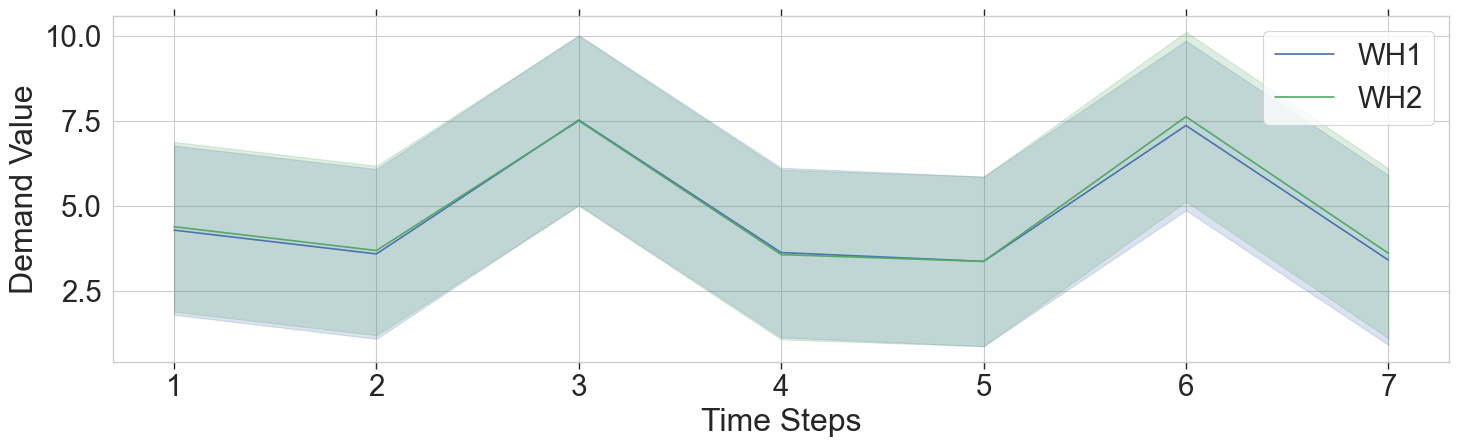

In [20]:
np.random.seed(SEED)
env.reset(SEED)
visualize_demand(env, NUM_EPISODES)

In [21]:
# saving env settings
save_env_settings(env)

# Methods

## Visualize Transitions Methods

In [22]:
def prepare_metric_plot(ylabel, n,
                        episode_duration=env.T-(2*env.lead_times_len),
                        plots_n=4+(2*env.distr_warehouses_num)+(
                            env.lead_times_len*env.distr_warehouses_num)):
    """
    Auxiliary function.
    """
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel, fontsize='medium', ha='center')

    plt.xticks(np.arange(min(range(episode_duration)),
                         max(range(episode_duration))+1))
    plt.tick_params(axis='x', which='both',
                    top=True, bottom=True,
                    labelbottom=False)


def visualize_transitions(returns_trace, algorithm,
                          local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize transitions (stock levels, production and shipping controls,
    reward) along the episodes.
    """
    if env.distr_warehouses_num <= 3 and env.product_types_num <= 1:
        transitions = np.array(
            [(return_trace)
             for return_trace in zip(*returns_trace)])
        states_trace, actions_trace, rewards_trace = (transitions.T[0],
                                                      transitions.T[1],
                                                      abs(transitions.T[2]))
        episode_duration = env.T-(2*env.lead_times_len)

        logger.debug(f"\n-- visualize_transitions --"
                     f"\nstates_trace is "
                     f"{states_trace}"
                     f"\nactions_trace is "
                     f"{actions_trace}"
                     f"\nrewards_trace is "
                     f"{rewards_trace}")

        if env.distr_warehouses_num == 3:
            fig = plt.figure(figsize=(10, 40))
        elif env.distr_warehouses_num == 2:
            fig = plt.figure(figsize=(10, 30))
        else:
            fig = plt.figure(figsize=(10, 20))

        # states transitions
        states = np.array(
            [(state_trace)
             for state_trace in zip(*states_trace)])

        logger.debug(f"\nstates is "
                     f"{states}")

        # factory stocks
        prepare_metric_plot('Stocks,\nFactory',
                            1)
        tmp_mean = []
        for t in range(len(states)):
            tmp_mean.append(
                np.mean(
                    [np.sum(state.factory_stocks)
                     for state in states[t]], axis=0))
        tmp_std = []
        for t in range(len(states)):
            tmp_std.append(
                np.std(
                    [np.sum(state.factory_stocks)
                     for state in states[t]], axis=0))
        plt.plot(range(episode_duration),
                 tmp_mean,
                 color='purple', alpha=.5)
        plt.fill_between(range(episode_duration),
                         list(np.array(tmp_mean) -
                              np.array(tmp_std)),
                         list(np.array(tmp_mean) +
                              np.array(tmp_std)),
                         color='purple', alpha=.2)

        logger.debug(f"\nfactory_stocks (mean) is "
                     f"{tmp_mean}"
                     f"\nfactory_stocks (std) is "
                     f"{tmp_std}")

        logger.debug(f"\nfactory_stocks (mean for product) is "
                     f"{tmp_mean}"
                     f"\nfactory_stocks (std for product) is "
                     f"{tmp_std}")

        # distribution warehouses stocks
        for j in range(env.distr_warehouses_num):
            prepare_metric_plot(f"Stocks,\nWH{j+1}",
                                2+j)
            tmp_mean = []
            for t in range(len(states)):
                tmp_mean.append(
                    np.mean(
                        [np.sum(state.distr_warehouses_stocks[j])
                         for state in states[t]], axis=0))
            tmp_std = []
            for t in range(len(states)):
                tmp_std.append(
                    np.std(
                        [np.sum(state.distr_warehouses_stocks[j])
                         for state in states[t]], axis=0))
            plt.plot(range(episode_duration),
                     tmp_mean,
                     color='purple', alpha=.5)
            plt.fill_between(range(episode_duration),
                             list(np.array(tmp_mean) -
                                  np.array(tmp_std)),
                             list(np.array(tmp_mean) +
                                  np.array(tmp_std)),
                             color='purple', alpha=.2)

        logger.debug(f"\ndistr_warehouses_stocks (mean) is "
                     f"{tmp_mean}"
                     f"\ndistr_warehouses_stocks (std) is "
                     f"{tmp_std}")

        # actions (transitions)
        actions = np.array(
            [(action_trace)
             for action_trace in zip(*actions_trace)])

        logger.debug(f"\nactions is "
                     f"{actions}")

        # production level
        prepare_metric_plot('Prod,\nFactory',
                            2+env.distr_warehouses_num)
        tmp_mean = []
        for t in range(len(actions)):
            tmp_mean.append(
                np.mean(
                    [np.sum(action.production_level)
                     for action in actions[t]], axis=0))
        tmp_std = []
        for t in range(len(actions)):
            tmp_std.append(
                np.std(
                    [np.sum(action.production_level)
                     for action in actions[t]], axis=0))
        plt.plot(range(episode_duration),
                 tmp_mean,
                 color='blue', alpha=.5)
        plt.fill_between(range(episode_duration),
                         list(np.array(tmp_mean) -
                              np.array(tmp_std)),
                         list(np.array(tmp_mean) +
                              np.array(tmp_std)),
                         color='blue', alpha=.2)

        logger.debug(f"\nproduction_level (mean) is "
                     f"{tmp_mean}"
                     f"\nproduction_level (std) is "
                     f"{tmp_std}")

        # shipped stocks
        for j in range(env.distr_warehouses_num):
            prepare_metric_plot(f"Ship,\nWH{j+1}",
                                3+env.distr_warehouses_num+j)
            tmp_mean = []
            for t in range(len(actions)):
                tmp_mean.append(
                    np.mean(
                        [np.sum(action.shipped_stocks[j])
                         for action in actions[t]], axis=0))
            tmp_std = []
            for t in range(len(actions)):
                tmp_std.append(
                    np.std(
                        [np.sum(action.shipped_stocks[j])
                         for action in actions[t]], axis=0))
            plt.plot(range(episode_duration),
                     tmp_mean,
                     color='blue', alpha=.5)
            plt.fill_between(range(episode_duration),
                             list(np.array(tmp_mean) -
                                  np.array(tmp_std)),
                             list(np.array(tmp_mean) +
                                  np.array(tmp_std)),
                             color='blue', alpha=.2)

        logger.debug(f"\nshipped_stocks (mean) is "
                     f"{tmp_mean}"
                     f"\nshipped_stocks (std) is "
                     f"{tmp_std}")

        # lead times stocks
        cont = 0
        for l in range(env.lead_times_len):
            for j in range(env.distr_warehouses_num):
                prepare_metric_plot(f"In Transit,\nL{l+1} WH{j+1}",
                                    3+(2*env.distr_warehouses_num)+j+cont)
                tmp_mean = []
                for t in range(len(states)):
                    tmp_mean.append(
                        np.mean(
                            [np.sum(state.lead_times[l][j])
                             for state in states[t]], axis=0))
                tmp_std = []
                for t in range(len(states)):
                    tmp_std.append(
                        np.std(
                            [np.sum(state.lead_times[l][j])
                             for state in states[t]], axis=0))
                plt.plot(range(episode_duration),
                         tmp_mean,
                         color='green', alpha=.5)
                plt.fill_between(range(episode_duration),
                                 list(np.array(tmp_mean) -
                                      np.array(tmp_std)),
                                 list(np.array(tmp_mean) +
                                      np.array(tmp_std)),
                                 color='green', alpha=.2)
            cont += env.distr_warehouses_num

        logger.debug(f"\nlead_times_stocks (mean) is "
                     f"{tmp_mean}"
                     f"\nlead_times_stocks (std) is "
                     f"{tmp_std}")

        # profit
        prepare_metric_plot('\nCosts',
                            3+(2*env.distr_warehouses_num)+(
                                env.lead_times_len*env.distr_warehouses_num))
        reward_mean = np.array(
            np.mean(rewards_trace, axis=0),
            dtype=np.int32)
        reward_std = np.array(
            np.std(rewards_trace.astype(np.int32), axis=0),
            dtype=np.int32)
        plt.plot(range(episode_duration),
                 reward_mean,
                 linewidth=2,
                 color='red', alpha=.5)
        plt.fill_between(range(episode_duration),
                         reward_mean -
                         reward_std,
                         reward_mean +
                         reward_std,
                         color='red', alpha=.2)

        logger.debug(f"\nprofit (mean) is "
                     f"{reward_mean}"
                     f"\nprofit (std) is "
                     f"{reward_std}")

        # cumulative profit
        prepare_metric_plot('Cum\nCosts',
                            4+(2*env.distr_warehouses_num)+(
                                env.lead_times_len*env.distr_warehouses_num))
        cum_reward = np.array(
            [np.cumsum(reward_trace)
             for reward_trace in rewards_trace])
        cum_reward_mean = np.array(
            np.mean(cum_reward, axis=0),
            dtype=np.int32)
        cum_reward_std = np.array(
            np.std(cum_reward.astype(np.int32), axis=0),
            dtype=np.int32)
        plt.plot(range(episode_duration),
                 cum_reward_mean,
                 linewidth=2,
                 color='red', alpha=.5)
        plt.fill_between(range(episode_duration),
                         cum_reward_mean -
                         cum_reward_std,
                         cum_reward_mean +
                         cum_reward_std,
                         color='red', alpha=.2)

        logger.debug(f"\ncumulative profit (mean) is "
                     f"{cum_reward_mean}"
                     f"\ncumulative profit (std) is "
                     f"{cum_reward_std}")

        fig.align_labels()
        plt.ticklabel_format(axis='y', style='plain',
                             useOffset=False)
        plt.tight_layout()

        # creating necessary subdir and saving plot
        if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
            os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
        plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}"
                    f"/transitions_{algorithm}.pdf",
                    format='pdf', bbox_inches='tight')

## Visualize Cumulative Profit Methods

In [23]:
def calculate_cum_profit(returns_trace, print_reward=True):
    """
    Calculate the cumulative profit for each episode.
    """
    rewards_trace = []
    for return_trace in returns_trace:
        rewards_trace.append(abs(
            np.sum(return_trace.T[2])))

    if print_reward:
        print(f"reward: mean "
              f"{np.mean(rewards_trace)}, "
              f"std "
              f"{np.std(rewards_trace)}, "
              f"max "
              f"{np.max(rewards_trace)}, "
              f"min "
              f"{np.min(rewards_trace)}")

    return rewards_trace


def visualize_cum_profit(rewards_trace, algorithm,
                         local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize the cumulative profit boxplot along the episodes.
    """
    xticks = []
    if not isinstance(algorithm, list):
        xticks.append(algorithm)
    else:
        xticks = algorithm

    plt.figure(figsize=(15, 5))
    plt.boxplot(rewards_trace)

    plt.ylabel('Cumulative Costs')
    plt.xticks(np.arange(1,
                         len(xticks)+1),
               xticks)
    plt.tick_params(axis='x', which='both',
                    top=False, bottom=True,
                    labelbottom=True)
    plt.ticklabel_format(axis='y', style='plain',
                         useOffset=False)
    plt.tight_layout()

    # creating necessary subdir and saving plot
    if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
        os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
    plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}"
                f"/cum_profit_{algorithm}.pdf",
                format='pdf', bbox_inches='tight')

    # saving the cumulative profit as text
    if not isinstance(algorithm, list):
        f = open(f"{local_dir}/{plots_dir}/{algorithm}"
                 f"/cum_profit_{algorithm}.txt",
                 'w', encoding='utf-8')
        f.write(f"reward: mean "
                f"{np.mean(rewards_trace)}, "
                f"std "
                f"{np.std(rewards_trace)}, "
                f"max "
                f"{np.max(rewards_trace)}, "
                f"min "
                f"{np.min(rewards_trace)}")
        f.close()


def save_checkpoint(checkpoint, algorithm,
                    local_dir=local_dir, plots_dir=plots_dir):
    """
    Save Ax BS/(s, Q)-policy parameters or RLib Agent checkpoint.
    """
    f = open(f"{local_dir}/{plots_dir}/{algorithm}"
             f"/best_checkpoint_{algorithm}.txt",
             'w', encoding='utf-8')
    f.write(checkpoint)
    f.close()


def save_object(obj, obj_name, algorithm,
                local_dir=local_dir, plots_dir=plots_dir):
    try:
        with open(f"{local_dir}/{plots_dir}/{algorithm}/"
                  f"/{obj_name}_{algorithm}.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print(f"{e.__class__} occurred!")


def convert_seconds_to_min_sec(seconds_float):
    # Get the minutes part and the remaining seconds
    minutes, seconds = divmod(seconds_float, 60)

    # Combine minutes and seconds in requested format
    min_sec = minutes + seconds / 100

    return min_sec

# OR-Tools Methods

Code inspired by hands-on tutorial ['A Python OR-Tools Model for Seasonal Inventory Planning'](https://towardsdatascience.com/a-python-or-tools-model-for-seasonal-inventory-planning-483aaf5aa8b).

## Parameters Methods [OR-Tools]

In [24]:
def create_parameters_ortools(env, num_episodes=1):
    """
    Transforms env parameters from numpy.array to lists.
    """
    # number of (time) steps for MIP solver
    num_steps = env.T
    steps = np.arange(0, num_steps, 1)
    steps = dict(enumerate(steps.flatten(), 0))
    for t in steps:
        steps[t] = f"{steps[t]}"

    # generating demands (MIP solver knows the episodes' demands a priori)
    demands_episodes = []
    for _ in range(num_episodes):
        demands_episode = env.generate_episode_demands()
        demands_episodes.append(demands_episode)
    demands_episodes = np.array(demands_episodes)

    # mean of demands
    demands_mean_episodes = np.array([np.mean(d, axis=0)
                                      for d in zip(*demands_episodes)])
    # demands as list
    demands_mean_list = np.around(demands_mean_episodes).tolist()

    # deterministic demand, equivalent to the mean value (as list)
    demand = {}
    for j in range(env.distr_warehouses_num):
        demand[j] = {}
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            demand[j][i] = {}
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                demand[j][i][t] = demands_mean_list[t][j][i]

    logger.debug(f"\n-- OR-Tools -- create_parameters_ortools"
                 f"\ndemands_mean_episodes is "
                 f"{demands_mean_episodes}"
                 f"\ndemands_mean_list is "
                 f"{demands_mean_list}"
                 f"\ndemand is "
                 f"{demand}")

    # initial stocks and capacities (as lists)
    initial_stocks = 0
    factory_capacities = env.storage_capacities.tolist()[0]
    distr_w_capacities = env.storage_capacities.tolist()[1:]
    transportation_capacities = env.transportation_capacities.tolist()

    # costs (as lists)
    sale_prices = env.sale_prices.tolist()
    production_costs = env.production_costs.tolist()

    transportation_costs_fixed = env.transportation_costs_fixed.tolist()
    transportation_costs_unit = env.transportation_costs_unit.tolist()

    factory_storage_costs = env.storage_costs.tolist()[0]
    distr_w_storage_costs = env.storage_costs.tolist()[1:]
    penalty_costs = env.penalty_costs.tolist()

    logger.debug(f"\nnum_steps is "
                 f"{num_steps}"
                 f"\nsteps is "
                 f"{steps}"
                 f"\ndemand is "
                 f"{demand}"
                 f"\ninitial_stocks is "
                 f"{initial_stocks}"
                 f"\nfactory_capacities is "
                 f"{factory_capacities}"
                 f"\ndistr_w_capacities is "
                 f"{distr_w_capacities}"
                 f"\ntransportation_capacities is "
                 f"{transportation_capacities}"
                 f"\nsale_prices is "
                 f"{sale_prices}"
                 f"\nproduction_costs is "
                 f"{production_costs}"
                 f"\ntransportation_costs_fixed is "
                 f"{transportation_costs_fixed}"
                 f"\ntransportation_costs_unit is "
                 f"{transportation_costs_unit}"
                 f"\nfactory_storage_costs is "
                 f"{factory_storage_costs}"
                 f"\ndistr_w_storage_costs is "
                 f"{distr_w_storage_costs}"
                 f"\npenalty_costs is "
                 f"{penalty_costs}")

    return (steps, demand, initial_stocks,
            factory_capacities, distr_w_capacities,
            transportation_capacities,
            sale_prices, production_costs,
            transportation_costs_fixed, transportation_costs_unit,
            factory_storage_costs, distr_w_storage_costs,
            penalty_costs)

## Decision Variables [OR-Tools]

In [25]:
def decision_variables_ortools(env, solver):
    """
    Defines OR-Tools decision variables for each warehouse (including factory)
    and for each product type.
    """
    # factory decision variables
    prod_level = {}
    stocks_factory = {}

    for i in range(env.product_types_num):
        prod_level[i] = {}
        stocks_factory[i] = {}

    for i in range(env.product_types_num):
        for t in range(env.T):
            prod_level[i][t] = solver.IntVar(
                0, int(env.prod_level_max[i]),
                'prod_level')
            stocks_factory[i][t] = solver.IntVar(
                0, solver.infinity(),
                'stocks_factory')

    # distr_w decision variables
    in_transit_stocks = {}
    shipped_stocks = {}
    stocks_distr_w = {}
    transportation_numbers = {}

    for j in range(env.distr_warehouses_num):
        shipped_stocks[j] = {}
        stocks_distr_w[j] = {}
        transportation_numbers[j] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            shipped_stocks[j][i] = {}
            stocks_distr_w[j][i] = {}
            transportation_numbers[j][i] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                shipped_stocks[j][i][t] = solver.IntVar(
                    0, int(env.storage_capacities[j+1][i]),
                    'shipped_stocks')
                stocks_distr_w[j][i][t] = solver.IntVar(
                    -solver.infinity(), solver.infinity(),
                    'stocks_distr_w')
                transportation_numbers[j][i][t] = solver.IntVar(
                    0, solver.infinity(),
                    'transportation_numbers')

    if env.lead_times_len > 0:
        for l in range(env.lead_times_len):
            in_transit_stocks[l] = {}
        for l in range(env.lead_times_len):
            for j in range(env.distr_warehouses_num):
                in_transit_stocks[l][j] = {}
        for l in range(env.lead_times_len):
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    in_transit_stocks[l][j][i] = {}
        for l in range(env.lead_times_len):
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    for t in range(env.T):
                        in_transit_stocks[l][j][i][t] = solver.IntVar(
                            0, int(env.storage_capacities[j+1][i]),
                            'in_transit_stocks')

    logger.debug(f"\n-- OR-Tools -- decision_variables_ortools"
                 f"\nprod_level is "
                 f"{prod_level}"
                 f"\nstocks_factory "
                 f"{stocks_factory}"
                 f"\nin_transit_stocks is "
                 f"{in_transit_stocks}"
                 f"\nshipped_stocks is "
                 f"{shipped_stocks}"
                 f"\nstocks_distr_w is "
                 f"{stocks_distr_w}"
                 f"\ntransportation_numbers is "
                 f"{transportation_numbers}")

    print(f"number of variables is {solver.NumVariables()}")

    return (prod_level, stocks_factory,
            in_transit_stocks,
            shipped_stocks, stocks_distr_w,
            transportation_numbers)


def s_decision_variables_ortools(env, solver):
    """
    Defines OR-Tools decision variables (storage costs) for each warehouse
    (including factory) and for each product type.
    """
    # dummy variable for storage costs (factory)
    dummy_s_costs_factory = {}

    for i in range(env.product_types_num):
        dummy_s_costs_factory[i] = {}

    for i in range(env.product_types_num):
        for t in range(env.T):
            dummy_s_costs_factory[i][t] = solver.IntVar(
                0, solver.infinity(),
                'dummy_s_costs_factory')

    # dummy variable for storage costs (distr_w)
    dummy_s_costs_distr_w = {}

    for j in range(env.distr_warehouses_num):
        dummy_s_costs_distr_w[j] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            dummy_s_costs_distr_w[j][i] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                dummy_s_costs_distr_w[j][i][t] = solver.IntVar(
                    0, solver.infinity(),
                    'dummy_s_costs_distr_w')

    logger.debug(f"\n-- OR-Tools -- s_decision_variables_ortools"
                 f"\ndummy_s_costs_factory is "
                 f"{dummy_s_costs_factory}"
                 f"\ndummy_s_costs_distr_w "
                 f"{dummy_s_costs_distr_w}")

    print(f"number of variables is {solver.NumVariables()}")

    return (dummy_s_costs_factory, dummy_s_costs_distr_w)


def p_decision_variables_ortools(env, solver):
    """
    Defines OR-Tools decision variables (penalty costs) for each warehouse
    (including factory) and for each product type.
    """
    # dummy variable for penalty costs (factory)
    dummy_p_costs_factory = {}

    for i in range(env.product_types_num):
        dummy_p_costs_factory[i] = {}

    for i in range(env.product_types_num):
        for t in range(env.T):
            dummy_p_costs_factory[i][t] = solver.IntVar(
                -solver.infinity(), 0,
                'dummy_p_costs_factory')

    # dummy variable for penalty costs (distr_w)
    dummy_p_costs_distr_w = {}

    for j in range(env.distr_warehouses_num):
        dummy_p_costs_distr_w[j] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            dummy_p_costs_distr_w[j][i] = {}

    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                dummy_p_costs_distr_w[j][i][t] = solver.IntVar(
                    -solver.infinity(), 0,
                    'dummy_p_costs_distr_w')

    logger.debug(f"\n-- OR-Tools -- p_decision_variables_ortools"
                 f"\ndummy_p_costs_factory is "
                 f"{dummy_p_costs_factory}"
                 f"\ndummy_p_costs_distr_w "
                 f"{dummy_p_costs_distr_w}")

    print(f"number of variables is {solver.NumVariables()}")

    return (dummy_p_costs_factory, dummy_p_costs_distr_w)

## Constraints [OR-Tools]

In [26]:
def constraints_ortools(env, solver, demands, initial_stocks,
                        prod_level, stocks_factory,
                        in_transit_stocks,
                        shipped_stocks, stocks_distr_w,
                        transportation_numbers, transportation_capacities,
                        factory_capacities, distr_w_capacities):
    """
    Defines OR-Tools constraints for each warehouse (including factory) and for
    each product type.
    """
    # step 0 (factory)
    for i in range(env.product_types_num):
        solver.Add(
            stocks_factory[i][0]
            == initial_stocks +
            prod_level[i][0] -
            sum(shipped_stocks[j][i][0]
                for j in range(env.distr_warehouses_num)))
        solver.Add(
            initial_stocks + prod_level[i][0] >=
            sum(shipped_stocks[j][i][0]
                for j in range(env.distr_warehouses_num)))
        solver.Add(
            initial_stocks + prod_level[i][0] <=
            factory_capacities[i])

    # step 0 (distr_w)
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            if env.lead_times_len > 0:
                solver.Add(
                    stocks_distr_w[j][i][0]
                    == initial_stocks -
                    demands[j][i][0])
                solver.Add(
                    initial_stocks <=
                    distr_w_capacities[j][i])
            else:
                solver.Add(
                    stocks_distr_w[j][i][0]
                    == initial_stocks +
                    shipped_stocks[j][i][0] -
                    demands[j][i][0])
                solver.Add(
                    initial_stocks +
                    shipped_stocks[j][i][0] <=
                    distr_w_capacities[j][i])
            solver.Add(
                transportation_numbers[j][i][0] >=
                shipped_stocks[j][i][0] /
                transportation_capacities[j][i])

    if env.lead_times_len > 0:
        # steps = 0 (lead_times)
        for l in range(env.lead_times_len-1, 0, -1):
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    solver.Add(
                        in_transit_stocks[l][j][i][0]
                        == initial_stocks)
        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                solver.Add(
                    in_transit_stocks[0][j][i][0]
                    == shipped_stocks[j][i][0])

    # steps > 0 (factory)
    for i in range(env.product_types_num):
        for t in range(1, env.T):
            solver.Add(
                stocks_factory[i][t]
                == stocks_factory[i][t-1] +
                prod_level[i][t] -
                sum(shipped_stocks[j][i][t]
                    for j in range(env.distr_warehouses_num)))
            solver.Add(
                stocks_factory[i][t-1] + prod_level[i][t] >=
                sum(shipped_stocks[j][i][t]
                    for j in range(env.distr_warehouses_num)))
            solver.Add(
                stocks_factory[i][t-1] + prod_level[i][t] <=
                factory_capacities[i])

    # steps > 0 (distr_w)
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(1, env.T):
                if env.lead_times_len > 0:
                    solver.Add(
                        stocks_distr_w[j][i][t]
                        == stocks_distr_w[j][i][t-1] +
                        in_transit_stocks[env.lead_times_len-1][j][i][t-1] -
                        demands[j][i][t])
                    solver.Add(
                        stocks_distr_w[j][i][t-1] +
                        in_transit_stocks[env.lead_times_len-1][j][i][t-1] <=
                        distr_w_capacities[j][i])
                else:
                    solver.Add(
                        stocks_distr_w[j][i][t]
                        == stocks_distr_w[j][i][t-1] +
                        shipped_stocks[j][i][t] -
                        demands[j][i][t])
                    solver.Add(
                        stocks_distr_w[j][i][t-1] +
                        shipped_stocks[j][i][t] <=
                        distr_w_capacities[j][i])
                solver.Add(
                    transportation_numbers[j][i][t] >=
                    shipped_stocks[j][i][t] /
                    transportation_capacities[j][i])

    if env.lead_times_len > 0:
        # steps > 0 (lead_times)
        for l in range(env.lead_times_len-1, 0, -1):
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    for t in range(1, env.T):
                        solver.Add(
                            in_transit_stocks[l][j][i][t]
                            == in_transit_stocks[l-1][j][i][t-1])
        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                for t in range(1, env.T):
                    solver.Add(
                        in_transit_stocks[0][j][i][t]
                        == shipped_stocks[j][i][t])

    print(f"number of constraints is {solver.NumConstraints()}")


def s_constraints_ortools(env, solver,
                          stocks_factory, factory_storage_costs,
                          stocks_distr_w, distr_w_storage_costs,
                          dummy_s_costs_factory, dummy_s_costs_distr_w):
    """
    Defines OR-Tools (storage costs) constraints for each warehouse (including
    factory) and for each product type.
    https://math.stackexchange.com/questions/679121/
    """
    # steps >= 0 (factory)
    for i in range(env.product_types_num):
        for t in range(0, env.T):
            solver.Add(dummy_s_costs_factory[i][t] >=
                       factory_storage_costs[i]*stocks_factory[i][t])
            solver.Add(dummy_s_costs_factory[i][t] >= 0)

    # steps >= 0 (distr_w)
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(0, env.T):
                solver.Add(dummy_s_costs_distr_w[j][i][t] >=
                           distr_w_storage_costs[j][i] *
                           stocks_distr_w[j][i][t])
                solver.Add(dummy_s_costs_distr_w[j][i][t] >= 0)

    print(f"number of constraints is {solver.NumConstraints()}")


def p_constraints_ortools(env, solver, penalty_costs,
                          stocks_factory, stocks_distr_w,
                          dummy_p_costs_factory, dummy_p_costs_distr_w):
    """
    Defines OR-Tools (penalty costs) constraints for each warehouse (including
    factory) and for each product type.
    https://math.stackexchange.com/questions/679121/
    """
    # steps >= 0 (factory)
    for i in range(env.product_types_num):
        for t in range(0, env.T):
            solver.Add(dummy_p_costs_factory[i][t] <=
                       penalty_costs[i]*stocks_factory[i][t])
            solver.Add(dummy_p_costs_factory[i][t] <= 0)

    # steps >= 0 (distr_w)
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(0, env.T):
                solver.Add(dummy_p_costs_distr_w[j][i][t] <=
                           penalty_costs[i] *
                           stocks_distr_w[j][i][t])
                solver.Add(dummy_p_costs_distr_w[j][i][t] <= 0)

    print(f"number of constraints is {solver.NumConstraints()}")

## Objective Function [OR-Tools]

In [27]:
def obj_func_ortools(env, demands, sale_prices,
                     prod_level, production_costs,
                     shipped_stocks, transportation_numbers,
                     transportation_costs_fixed, transportation_costs_unit,
                     dummy_s_costs_factory, dummy_s_costs_distr_w,
                     dummy_p_costs_factory, dummy_p_costs_distr_w):
    """
    Defines OR-Tools objective function.
    """
    # revenues and transportation costs
    total_revenues = []
    total_transportation_costs_fixed = []
    total_transportation_costs_unit = []
    total_transportation_costs = []
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                total_revenues.append(sale_prices[i] *
                                      demands[j][i][t])
                total_transportation_costs_fixed.append(
                    transportation_costs_fixed[j][i] *
                    transportation_numbers[j][i][t])
                total_transportation_costs_unit.append(
                    transportation_costs_unit[j][i] *
                    shipped_stocks[j][i][t])
    total_revenues = sum(total_revenues)
    total_transportation_costs_fixed = sum(total_transportation_costs_fixed)
    total_transportation_costs_unit = sum(total_transportation_costs_unit)
    total_transportation_costs = total_transportation_costs_fixed + \
        total_transportation_costs_unit

    # production costs
    total_production_costs = []
    for i in range(env.product_types_num):
        for t in range(env.T):
            total_production_costs.append(production_costs[i]*prod_level[i][t])
    total_production_costs = sum(total_production_costs)

    # storage costs
    total_storage_costs = []
    for i in range(env.product_types_num):
        for t in range(env.T):
            total_storage_costs.append(dummy_s_costs_factory[i][t])
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                total_storage_costs.append(dummy_s_costs_distr_w[j][i][t])
    total_storage_costs = sum(total_storage_costs)

    # penalty costs
    total_penalty_costs = []
    for i in range(env.product_types_num):
        for t in range(env.T):
            total_penalty_costs.append(dummy_p_costs_factory[i][t])
    for j in range(env.distr_warehouses_num):
        for i in range(env.product_types_num):
            for t in range(env.T):
                total_penalty_costs.append(dummy_p_costs_distr_w[j][i][t])
    total_penalty_costs = -sum(total_penalty_costs)

    # reward
    reward = total_revenues - total_production_costs - \
        total_transportation_costs - total_storage_costs - total_penalty_costs

    logger.debug(f"\n--- OR-Tools --- objective_function_ortools"
                 f"\ntotal_revenues is "
                 f"{total_revenues}"
                 f"\ntotal_production_costs is "
                 f"{total_production_costs}"
                 f"\ntotal_transportation_costs_fixed is "
                 f"{total_transportation_costs_fixed}"
                 f"\ntotal_transportation_costs_unit is "
                 f"{total_transportation_costs_unit}"
                 f"\ntotal_transportation_costs is "
                 f"{total_transportation_costs}"
                 f"\ntotal_storage_costs is "
                 f"{total_storage_costs}"
                 f"\ntotal_penalty_costs is "
                 f"{total_penalty_costs}"
                 f"\nreward is "
                 f"{reward}")

    return reward

## Results [OR-Tools]

In [28]:
def results_ortools(env, solver, steps, demands,
                    prod_level, stocks_factory,
                    in_transit_stocks,
                    shipped_stocks, stocks_distr_w,
                    factory_capacities, distr_w_capacities,
                    transportation_numbers, transportation_capacities,
                    local_dir, plots_dir):
    """
    Prepare and display OR-Tools results.
    """
    # factory results
    results_stocks_factory = []
    results_prod_level = []

    for t in range(env.T):
        for i in range(env.product_types_num):
            results_stocks_factory.append(
                stocks_factory[i][t].solution_value())
            results_prod_level.append(
                prod_level[i][t].solution_value())

    # factory results (in terms of steps)
    results_stocks_factory = np.array(
        results_stocks_factory).reshape(env.T,
                                        env.product_types_num)
    results_prod_level = np.array(
        results_prod_level).reshape(env.T,
                                    env.product_types_num)

    # distr_w results
    results_in_transit_stocks = []
    results_stocks_distr_w = []
    results_demands = []
    results_shipped_stocks = []
    results_transportation_numbers = []

    for t in range(env.T):
        for i in range(env.product_types_num):
            for j in range(env.distr_warehouses_num):
                results_stocks_distr_w.append(
                    stocks_distr_w[j][i][t].solution_value())
                results_demands.append(
                    demands[j][i][t])
                results_shipped_stocks.append(
                    shipped_stocks[j][i][t].solution_value())
                results_transportation_numbers.append(
                    transportation_numbers[j][i][t].solution_value())

    if env.lead_times_len > 0:
        for t in range(env.T):
            for l in range(env.lead_times_len):
                for j in range(env.distr_warehouses_num):
                    for i in range(env.product_types_num):
                        results_in_transit_stocks.append(
                            in_transit_stocks[l][j][i][t].solution_value())

    # distr_w results (in terms of steps)
    results_stocks_distr_w = np.array(
        results_stocks_distr_w).reshape(env.T,
                                        env.product_types_num,
                                        env.distr_warehouses_num)
    results_demands = np.array(
        results_demands).reshape(env.T,
                                 env.product_types_num,
                                 env.distr_warehouses_num)
    results_shipped_stocks = np.array(
        results_shipped_stocks).reshape(env.T,
                                        env.product_types_num,
                                        env.distr_warehouses_num)

    if env.lead_times_len > 0:
        results_in_transit_stocks = np.array(
            results_in_transit_stocks).reshape(env.T,
                                               env.lead_times_len,
                                               env.product_types_num,
                                               env.distr_warehouses_num)

    results_transportation_numbers = np.array(
        results_transportation_numbers).reshape(env.T,
                                                env.product_types_num,
                                                env.distr_warehouses_num)
    transportation_capacities = np.array(
        transportation_capacities).reshape(env.product_types_num,
                                           env.distr_warehouses_num)

    if env.lead_times_len > 0:
        # results (as pandas DataFrame)
        results_ortools = pd.DataFrame(
            columns=['step',
                     'start_stocks factory',
                     'start_stocks distr_w',
                     'demands',
                     'prod level',
                     'prod level max',
                     'shipped stocks',
                     'in transit stocks',
                     'transp numbers',
                     'transp capacities',
                     'transp capacities used (in %)',
                     'end_stocks factory',
                     'factory capacities',
                     'factory capacities used (in %)',
                     'end_stocks distr_w',
                     'distr_w capacities',
                     'distr_w capacities used (in %)'])

        for t in range(env.T):
            results_ortools.loc[t] = [
                steps[t],
                results_stocks_factory[t-1],
                results_stocks_distr_w[t-1],
                results_demands[t],
                results_prod_level[t],
                env.prod_level_max,
                results_shipped_stocks[t],
                results_in_transit_stocks[t],
                results_transportation_numbers[t],
                transportation_capacities,
                np.around(
                    results_shipped_stocks[t] /
                    ((results_transportation_numbers[t] +
                      np.finfo('float').eps) *
                     transportation_capacities) *
                    100).astype(np.int32),
                results_stocks_factory[t],
                factory_capacities,
                np.around(
                    results_stocks_factory[t] /
                    factory_capacities *
                    100).astype(np.int32),
                results_stocks_distr_w[t],
                distr_w_capacities,
                np.around(
                    results_stocks_distr_w[t].flatten() /
                    list(np.array(distr_w_capacities).flat) *
                    100).astype(np.int32)]
    else:
        # results (as pandas DataFrame)
        results_ortools = pd.DataFrame(
            columns=['step',
                     'start_stocks factory',
                     'start_stocks distr_w',
                     'demands',
                     'prod level',
                     'prod level max',
                     'shipped stocks',
                     'transp numbers',
                     'transp capacities',
                     'transp capacities used (in %)',
                     'end_stocks factory',
                     'factory capacities',
                     'factory capacities used (in %)',
                     'end_stocks distr_w',
                     'distr_w capacities',
                     'distr_w capacities used (in %)'])

        for t in range(env.T):
            results_ortools.loc[t] = [
                steps[t],
                results_stocks_factory[t-1],
                results_stocks_distr_w[t-1],
                results_demands[t],
                results_prod_level[t],
                env.prod_level_max,
                results_shipped_stocks[t],
                results_transportation_numbers[t],
                transportation_capacities,
                np.around(
                    results_shipped_stocks[t] /
                    ((results_transportation_numbers[t] +
                      np.finfo('float').eps) *
                     transportation_capacities) *
                    100).astype(np.int32),
                results_stocks_factory[t],
                factory_capacities,
                np.around(
                    results_stocks_factory[t] /
                    factory_capacities *
                    100).astype(np.int32),
                results_stocks_distr_w[t],
                distr_w_capacities,
                np.around(
                    results_stocks_distr_w[t].flatten() /
                    list(np.array(distr_w_capacities).flat) *
                    100).astype(np.int32)]

    # display results
    display(results_ortools)

    # creating necessary subdir and saving plot
    if not os.path.exists(f"{local_dir}/{plots_dir}/EVPI"):
        os.makedirs(f"{local_dir}/{plots_dir}/EVPI")

    # saving pandas DataFrame as an image
    dfi.export(results_ortools,
               f"{local_dir}/{plots_dir}"
               f"/EVPI/results_ortools_df.png",
               table_conversion='matplotlib')
    # saving pandas DataFrame as LaTeX table
    f = open(f"{local_dir}/{plots_dir}/EVPI"
             f"/results_ortools_df.tex",
             'w', encoding='utf-8')
    f.write(results_ortools.style.to_latex())
    f.close()

## Simulator Methods [OR-Tools]

In [29]:
def simulate_episode_ortools_det(env, prod_level, shipped_stocks, seed):
    """
    OR-Tools single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_ortools_det --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        action = Action(state.product_types_num, state.distr_warehouses_num)
        for j in range(state.distr_warehouses_num):
            for i in range(state.product_types_num):
                action.shipped_stocks[j][i] = \
                    shipped_stocks[t][j][i]

        for i in range(state.product_types_num):
            action.production_level[i] = prod_level[t][i]

        state, reward, _ = env.step(state, action)
        transitions_full.append(np.array(
            [state, action, reward],
            dtype=object))
        if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
            transitions.append(np.array(
                [state, action, reward],
                dtype=object))

        logger.debug(f"\naction is "
                     f"{action}"
                     f"\naction.production_level is "
                     f"{action.production_level}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nstate.demand_history is "
                     f"{state.demand_history}"
                     f"\nt is "
                     f"{t}"
                     f"\nreward is "
                     f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_ortools_det(env, prod_level, shipped_stocks, num_episodes=1, seed=SEED):
    """
    OR-Tools simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_ortools_det_testing = []

    prod_level_episodes = np.array(
        prod_level).reshape(num_episodes,
                            env.T,
                            env.product_types_num)
    shipped_stocks_episodes = np.array(
        shipped_stocks).reshape(num_episodes,
                                env.T,
                                env.distr_warehouses_num,
                                env.product_types_num)

    for episode in range(num_episodes):
        seed = None
        if episode == 0:
            seed = seed

        start_ortools_det = default_timer()
        rt_full, rt = simulate_episode_ortools_det(
            env,
            prod_level_episodes[episode],
            shipped_stocks_episodes[episode],
            seed)
        end_ortools_det = default_timer()
        
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_ortools_det_testing.append(end_ortools_det-start_ortools_det)

    logger.debug(f"\n-- simulate_ortools_det --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_ortools_det_testing]

In [30]:
def simulate_episode_ortools(env, prod_level, shipped_stocks, seed):
    """
    OR-Tools single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_ortools --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        action = Action(state.product_types_num, state.distr_warehouses_num)
        for j in range(state.distr_warehouses_num):
            for i in range(state.product_types_num):
                action.shipped_stocks[j][i] = \
                    shipped_stocks[j][i][t].solution_value()

        for i in range(state.product_types_num):
            action.production_level[i] = prod_level[i][t].solution_value()

        state, reward, _ = env.step(state, action)
        transitions_full.append(np.array(
            [state, action, reward],
            dtype=object))
        if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
            transitions.append(np.array(
                [state, action, reward],
                dtype=object))

        logger.debug(f"\naction is "
                     f"{action}"
                     f"\naction.production_level is "
                     f"{action.production_level}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nstate.demand_history is "
                     f"{state.demand_history}"
                     f"\nt is "
                     f"{t}"
                     f"\nreward is "
                     f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_ortools(env, prod_level, shipped_stocks, num_episodes=1, seed=SEED):
    """
    OR-Tools simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_ortools_testing = []

    for episode in range(num_episodes):
        seed = None
        if episode == 0:
            seed = seed

        start_ortools = default_timer()
        rt_full, rt = simulate_episode_ortools(
            env,
            prod_level,
            shipped_stocks,
            seed)
        end_ortools = default_timer()
        
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_ortools_testing.append(end_ortools-start_ortools)

    logger.debug(f"\n-- simulate_ortools --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_ortools_testing]

# OR-Tools Optimize (LP-DET)

In [31]:
cum_profit_solver_ortools_det = []
time_ortools_iterations = []

prod_level_ortools_det = []
shipped_stocks_ortools_det = []

np.random.seed(SEED)
env.reset(SEED)
for n in range(NUM_EPISODES):
    # ortools parameters
    (steps_ortools_det, demands_ortools_det, initial_stocks_ortools_det,
     factory_capacities_ortools_det, distr_w_capacities_ortools_det,
     transportation_capacities_ortools_det,
     sale_prices_ortools_det, production_costs_ortools_det,
     transportation_costs_fixed_ortools_det,
     transportation_costs_unit_ortools_det,
     factory_storage_costs_ortools_det, distr_w_storage_costs_ortools_det,
     penalty_costs_ortools_det) = create_parameters_ortools(env)

    # MIP solver (with SCIP backend)
    # https://developers.google.com/optimization/mip/mip_example
    # https://www.scipopt.org/
    solver_det = pywraplp.Solver.CreateSolver('SCIP')
    solver_det.SetSolverSpecificParametersAsString(
        'randomization/randomseedshift=2023')
    solver_det.set_time_limit(30*1000)

    # ortools decision variables
    (prod_level_det, stocks_factory_det,
     in_transit_stocks_det,
     shipped_stocks_det, stocks_distr_w_det,
     transportation_numbers_det) = decision_variables_ortools(
        env, solver_det)

    # ortools constraints
    constraints_ortools(env, solver_det, demands_ortools_det,
                        initial_stocks_ortools_det,
                        prod_level_det, stocks_factory_det,
                        in_transit_stocks_det,
                        shipped_stocks_det, stocks_distr_w_det,
                        transportation_numbers_det,
                        transportation_capacities_ortools_det,
                        factory_capacities_ortools_det,
                        distr_w_capacities_ortools_det)

    # storage costs decision variables
    (dummy_s_costs_factory_det,
     dummy_s_costs_distr_w_det) = s_decision_variables_ortools(env, solver_det)
    # storage costs constraints
    s_constraints_ortools(env, solver_det,
                          stocks_factory_det,
                          factory_storage_costs_ortools_det,
                          stocks_distr_w_det,
                          distr_w_storage_costs_ortools_det,
                          dummy_s_costs_factory_det, dummy_s_costs_distr_w_det)

    # penalty costs decision variables
    (dummy_p_costs_factory_det,
     dummy_p_costs_distr_w_det) = p_decision_variables_ortools(env, solver_det)
    # penalty costs constraints
    p_constraints_ortools(env, solver_det, penalty_costs_ortools_det,
                          stocks_factory_det, stocks_distr_w_det,
                          dummy_p_costs_factory_det, dummy_p_costs_distr_w_det)

    # reward
    reward = obj_func_ortools(env, demands_ortools_det,
                              sale_prices_ortools_det,
                              prod_level_det, production_costs_ortools_det,
                              shipped_stocks_det, transportation_numbers_det,
                              transportation_costs_fixed_ortools_det,
                              transportation_costs_unit_ortools_det,
                              dummy_s_costs_factory_det,
                              dummy_s_costs_distr_w_det,
                              dummy_p_costs_factory_det,
                              dummy_p_costs_distr_w_det)

    # ortools solution
    solver_det.Maximize(reward)
    status_det = solver_det.Solve()

    if (status_det == pywraplp.Solver.OPTIMAL or
            status_det == pywraplp.Solver.FEASIBLE):
        print(f"objective value is {solver_det.Objective().Value()}")
        time_ortools_iteration = solver_det.wall_time()/1000
        print(f"problem solved in {time_ortools_iteration} seconds")
        print(f"problem solved in {solver_det.iterations()} iterations\n")

        for t in range(env.T):
            for i in range(env.product_types_num):
                prod_level_ortools_det.append(
                    prod_level_det[i][t].solution_value())
            for j in range(env.distr_warehouses_num):
                for i in range(env.product_types_num):
                    shipped_stocks_ortools_det.append(
                        shipped_stocks_det[j][i][t].solution_value())
    else:
        print('NO OPTIMAL SOLUTION!')

    cum_profit_solver_ortools_det.append(abs(solver_det.Objective().Value()))
    time_ortools_iterations.append(time_ortools_iteration)

number of variables is 56
number of constraints is 63
number of variables is 77
number of constraints is 105
number of variables is 98
number of constraints is 147
objective value is -97.15999959409233
problem solved in 0.014 seconds
problem solved in 48 iterations

number of variables is 56
number of constraints is 63
number of variables is 77
number of constraints is 105
number of variables is 98
number of constraints is 147
objective value is -94.45999960601328
problem solved in 0.013 seconds
problem solved in 69 iterations

number of variables is 56
number of constraints is 63
number of variables is 77
number of constraints is 105
number of variables is 98
number of constraints is 147
objective value is -96.45999960601327
problem solved in 0.013 seconds
problem solved in 114 iterations

number of variables is 56
number of constraints is 63
number of variables is 77
number of constraints is 105
number of variables is 98
number of constraints is 147
objective value is -82.75999963656

In [32]:
# calculating and printing the LP-DET training time
time_ortools_det_total_training = np.round((np.sum(time_ortools_iterations)), 6)
time_ortools_det_mean_training = np.round((np.mean(time_ortools_iterations)), 6)
time_ortools_det_std_training = np.round((np.std(time_ortools_iterations)), 6)
print(f"total training time LP-DET (in seconds) is {time_ortools_det_total_training}")
print(f"mean training time LP-DET (in seconds) is {time_ortools_det_mean_training}")
print(f"std training time LP-DET (in seconds) is {time_ortools_det_std_training}")

total training time LP-DET (in seconds) is 3.29
mean training time LP-DET (in seconds) is 0.01316
std training time LP-DET (in seconds) is 0.001745


In [33]:
# evaluating the LP-DET policy
np.random.seed(SEED)
env.reset(SEED)
(returns_trace_ortools_det_full, returns_trace_ortools_det,
 time_ortools_det_testing) = simulate_ortools_det(env,
                                                  prod_level_ortools_det,
                                                  shipped_stocks_ortools_det,
                                                  NUM_EPISODES)

In [34]:
# calculating and printing the LP-DET testing time
time_ortools_det_total_testing = np.round((np.sum(time_ortools_det_testing)), 6)
time_ortools_det_mean_testing = np.round((np.mean(time_ortools_det_testing)), 6)
time_ortools_det_std_testing = np.round((np.std(time_ortools_det_testing)), 6)
print(f"total testing time LP-DET (in seconds) is {time_ortools_det_total_testing}")
print(f"mean testing time LP-DET (in seconds) is {time_ortools_det_mean_testing}")
print(f"std testing time LP-DET (in seconds) is {time_ortools_det_std_testing}")

total testing time LP-DET (in seconds) is 3.341719
mean testing time LP-DET (in seconds) is 0.013367
std testing time LP-DET (in seconds) is 0.001251


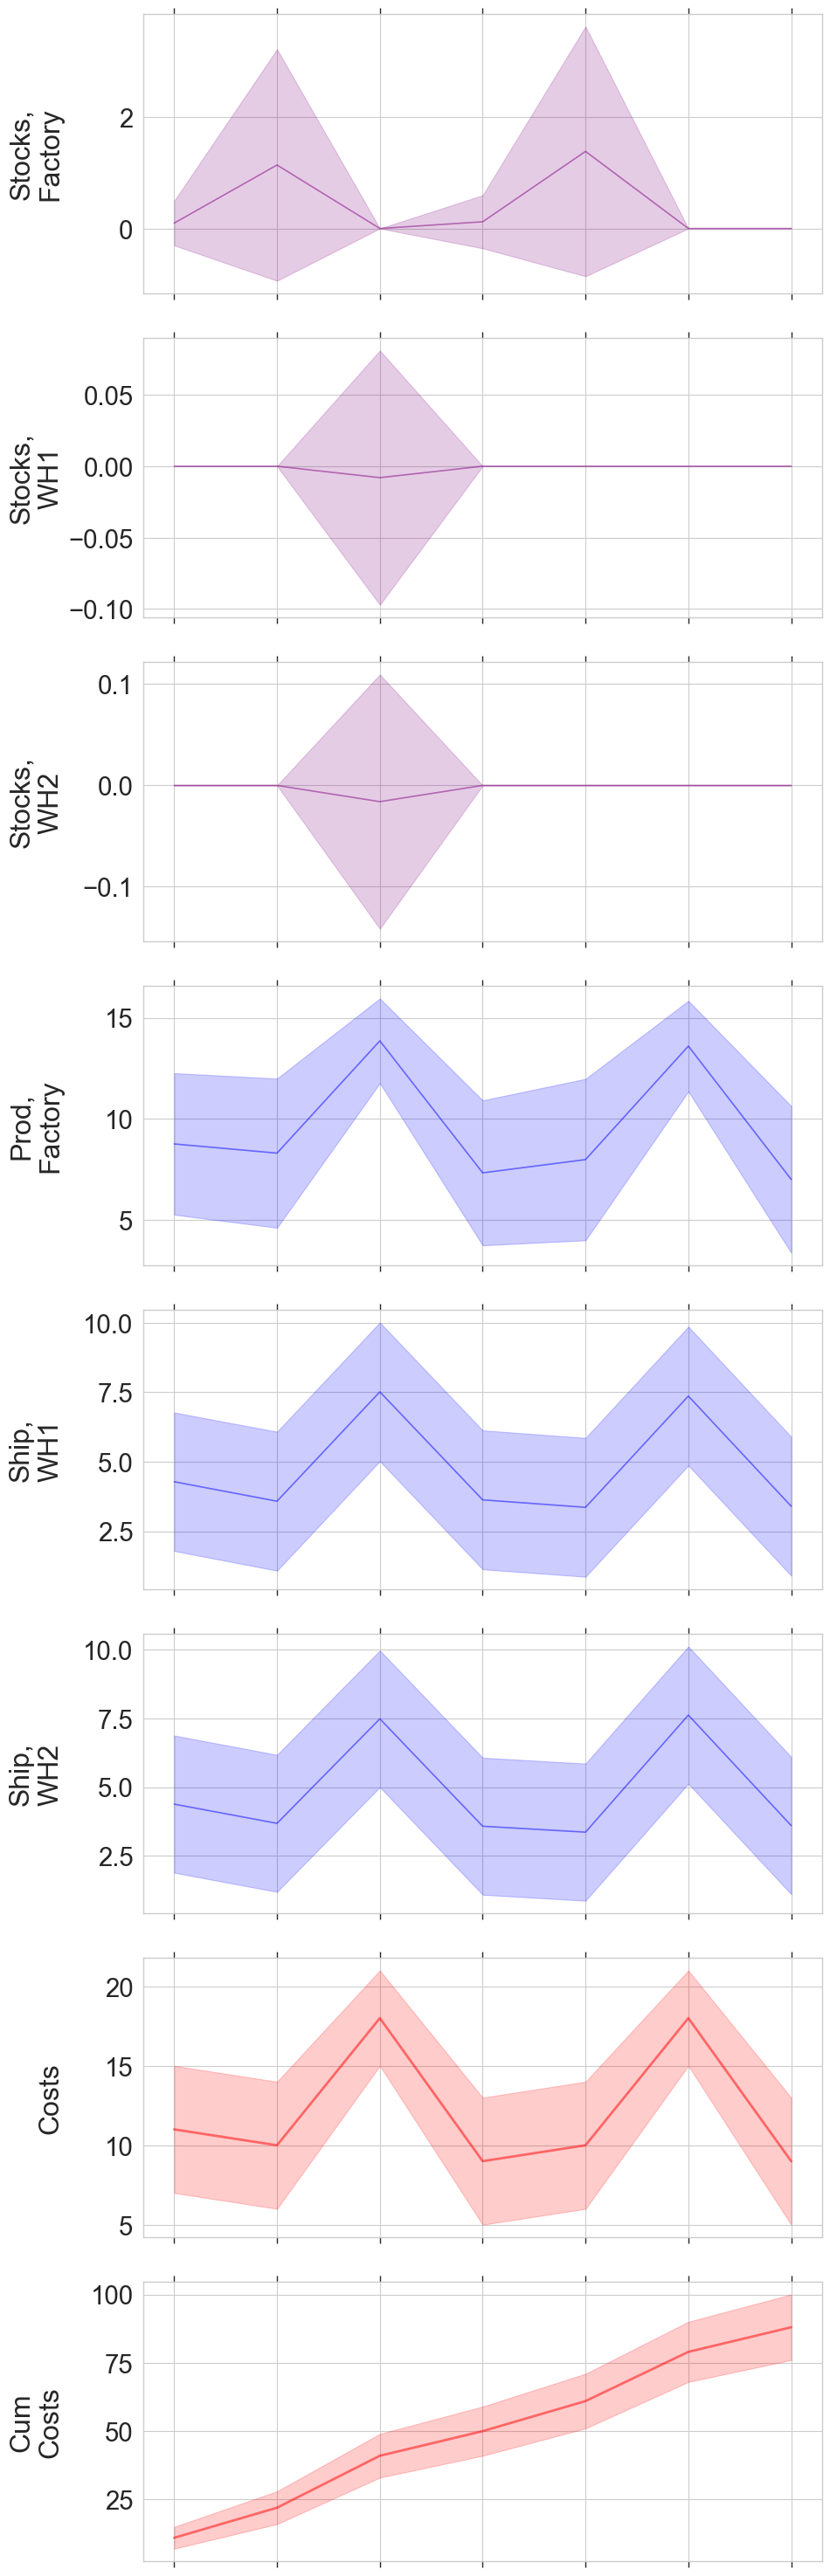

In [35]:
visualize_transitions(returns_trace_ortools_det, 'PI')

In [36]:
# cumulative profit of the LP-DET policy
cum_profit_ortools_det = calculate_cum_profit(returns_trace_ortools_det)

reward: mean 88.8537996269092, std 12.03271335683799, max 129.0599995404482, min 57.9599997214973


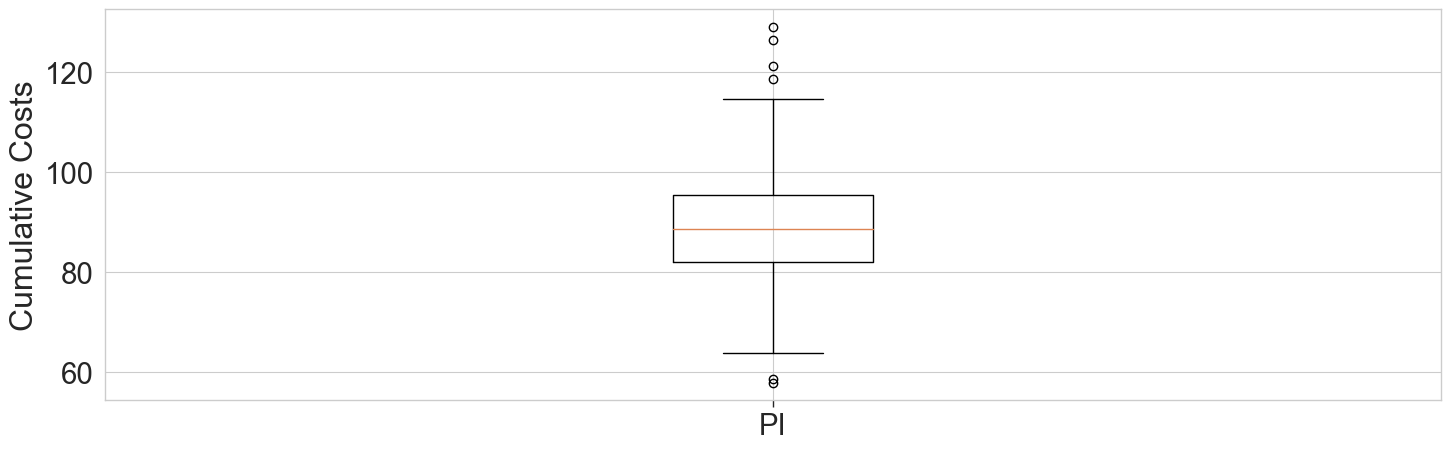

In [37]:
visualize_cum_profit(cum_profit_ortools_det, 'PI')

In [38]:
save_object(returns_trace_ortools_det_full, 'transitions_full', 'PI')
save_object(returns_trace_ortools_det, 'transitions', 'PI')
save_object(cum_profit_ortools_det, 'cum_profit', 'PI')

# OR-Tools Optimize (LP-MEAN)

In [39]:
# ortools parameters
(steps_ortools, demands_ortools, initial_stocks_ortools,
 factory_capacities_ortools, distr_w_capacities_ortools,
 transportation_capacities_ortools,
 sale_prices_ortools, production_costs_ortools,
 transportation_costs_fixed_ortools, transportation_costs_unit_ortools,
 factory_storage_costs_ortools, distr_w_storage_costs_ortools,
 penalty_costs_ortools) = create_parameters_ortools(env, NUM_EPISODES)

In [40]:
# MIP solver (with SCIP backend)
# https://developers.google.com/optimization/mip/mip_example
# https://www.scipopt.org/
solver_mean = pywraplp.Solver.CreateSolver('SCIP')
solver_mean.SetSolverSpecificParametersAsString(
    'randomization/randomseedshift=2023')
solver_mean.set_time_limit(30*1000)

In [41]:
# ortools decision variables
(prod_level, stocks_factory,
 in_transit_stocks,
 shipped_stocks, stocks_distr_w,
 transportation_numbers) = decision_variables_ortools(env, solver_mean)

number of variables is 56


In [42]:
# ortools constraints
constraints_ortools(env, solver_mean, demands_ortools, initial_stocks_ortools,
                    prod_level, stocks_factory,
                    in_transit_stocks,
                    shipped_stocks, stocks_distr_w,
                    transportation_numbers, transportation_capacities_ortools,
                    factory_capacities_ortools, distr_w_capacities_ortools)

number of constraints is 63


In [43]:
# storage costs decision variables
(dummy_s_costs_factory,
 dummy_s_costs_distr_w) = s_decision_variables_ortools(env, solver_mean)
# storage costs constraints
s_constraints_ortools(env, solver_mean,
                      stocks_factory, factory_storage_costs_ortools,
                      stocks_distr_w, distr_w_storage_costs_ortools,
                      dummy_s_costs_factory, dummy_s_costs_distr_w)

number of variables is 77
number of constraints is 105


In [44]:
# penalty costs decision variables
(dummy_p_costs_factory,
 dummy_p_costs_distr_w) = p_decision_variables_ortools(env, solver_mean)
# penalty costs constraints
p_constraints_ortools(env, solver_mean, penalty_costs_ortools,
                      stocks_factory, stocks_distr_w,
                      dummy_p_costs_factory, dummy_p_costs_distr_w)

number of variables is 98
number of constraints is 147


In [45]:
# reward
reward = obj_func_ortools(env, demands_ortools, sale_prices_ortools,
                          prod_level, production_costs_ortools,
                          shipped_stocks, transportation_numbers,
                          transportation_costs_fixed_ortools,
                          transportation_costs_unit_ortools,
                          dummy_s_costs_factory, dummy_s_costs_distr_w,
                          dummy_p_costs_factory, dummy_p_costs_distr_w)

In [46]:
# ortools solution
solver_mean.Maximize(reward)
status = solver_mean.Solve()

In [47]:
# printing the LP-MEAN results
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print(f"objective value is {solver_mean.Objective().Value()}")
    print(f"problem solved in {solver_mean.iterations()} iterations")
    time_ortools_total_training = np.round((solver_mean.wall_time()/1000), 6)
    results_ortools(env, solver_mean,
                    steps_ortools, demands_ortools,
                    prod_level, stocks_factory,
                    in_transit_stocks,
                    shipped_stocks, stocks_distr_w,
                    factory_capacities_ortools, distr_w_capacities_ortools,
                    transportation_numbers, transportation_capacities_ortools,
                    local_dir, plots_dir)
else:
    print('NO OPTIMAL SOLUTION!')

objective value is -86.87999963387846
problem solved in 60 iterations


step start_stocks factory start_stocks distr_w       demands prod level  \
0    0                [0.0]         [[0.0, 0.0]]  [[5.0, 4.0]]      [9.0]   
1    1                [0.0]         [[0.0, 0.0]]  [[4.0, 4.0]]      [8.0]   
2    2                [0.0]         [[0.0, 0.0]]  [[8.0, 7.0]]     [15.0]   
3    3                [0.0]         [[0.0, 0.0]]  [[3.0, 3.0]]      [6.0]   
4    4                [0.0]         [[0.0, 0.0]]  [[3.0, 3.0]]      [6.0]   
5    5                [0.0]         [[0.0, 0.0]]  [[7.0, 8.0]]     [15.0]   
6    6                [0.0]         [[0.0, 0.0]]  [[4.0, 3.0]]      [7.0]   

  prod level max shipped stocks transp numbers transp capacities  \
0           [15]   [[5.0, 4.0]]   [[2.0, 2.0]]          [[3, 3]]   
1           [15]   [[4.0, 4.0]]   [[2.0, 2.0]]          [[3, 3]]   
2           [15]   [[8.0, 7.0]]   [[3.0, 3.0]]          [[3, 3]]   
3           [15]   [[3.0, 3.0]]   [[1.0, 1.0]]          [[3, 3]]   
4           [15]   [[3.0, 3.0]]   [[1.0, 1.0]]          [[3, 3]]   
5           [15]   [[7.0, 8.0]]   [[3.0, 3.0]]          [[3, 3]]   
6           [15]   [[4.0, 3.0]]   [[2.0, 1.0]]          [[3, 3]]   

  transp capacities used (in %) end_stocks factory factory capacities  \
0                    [[83, 67]]              [0.0]               [20]   
1                    [[67, 67]]              [0.0]               [20]   
2                    [[89, 78]]              [0.0]               [20]   
3                  [[100, 100]]              [0.0]               [20]   
4                  [[100, 100]]              [0.0]               [20]   
5                    [[78, 89]]              [0.0]               [20]   
6                   [[67, 100]]              [0.0]               [20]   

  factory capacities used (in %) end_stocks distr_w distr_w capacities  \
0                            [0]       [[0.0, 0.0]]       [[10], [10]]   
1                            [0]       [[0.0, 0.0]]       [[10], [10]]   
2                            [0]       [[0.0, 0.0]]       [[10], [10]]   
3                            [0]       [[0.0, 0.0]]       [[10], [10]]   
4                            [0]       [[0.0, 0.0]]       [[10], [10]]   
5                            [0]       [[0.0, 0.0]]       [[10], [10]]   
6                            [0]       [[0.0, 0.0]]       [[10], [10]]   

  distr_w capacities used (in %)  
0                         [0, 0]  
1                         [0, 0]  
2                         [0, 0]  
3                         [0, 0]  
4                         [0, 0]  
5                         [0, 0]  
6                         [0, 0]

In [48]:
# calculating and printing the LP-MEAN training time
print(f"total training time LP-MEAN (in seconds) is {time_ortools_total_training}")

total training time LP-MEAN (in seconds) is 14.422


In [49]:
# evaluating the ortools policy
np.random.seed(SEED)
env.reset(SEED)
(returns_trace_ortools_full, returns_trace_ortools,
 time_ortools_testing) = simulate_ortools(env,
                                          prod_level,
                                          shipped_stocks,
                                          NUM_EPISODES)

In [50]:
# calculating and printing the LP-MEAN testing time
time_ortools_total_testing = np.round((np.sum(time_ortools_testing)), 6)
time_ortools_mean_testing = np.round((np.mean(time_ortools_testing)), 6)
time_ortools_std_testing = np.round((np.std(time_ortools_testing)), 6)
print(f"total testing time LP-MEAN (in seconds) is {time_ortools_total_testing}")
print(f"mean testing time LP-MEAN (in seconds) is {time_ortools_mean_testing}")
print(f"std testing time LP-MEAN (in seconds) is {time_ortools_det_std_testing}")

total testing time LP-MEAN (in seconds) is 3.434732
mean testing time LP-MEAN (in seconds) is 0.013739
std testing time LP-MEAN (in seconds) is 0.001251


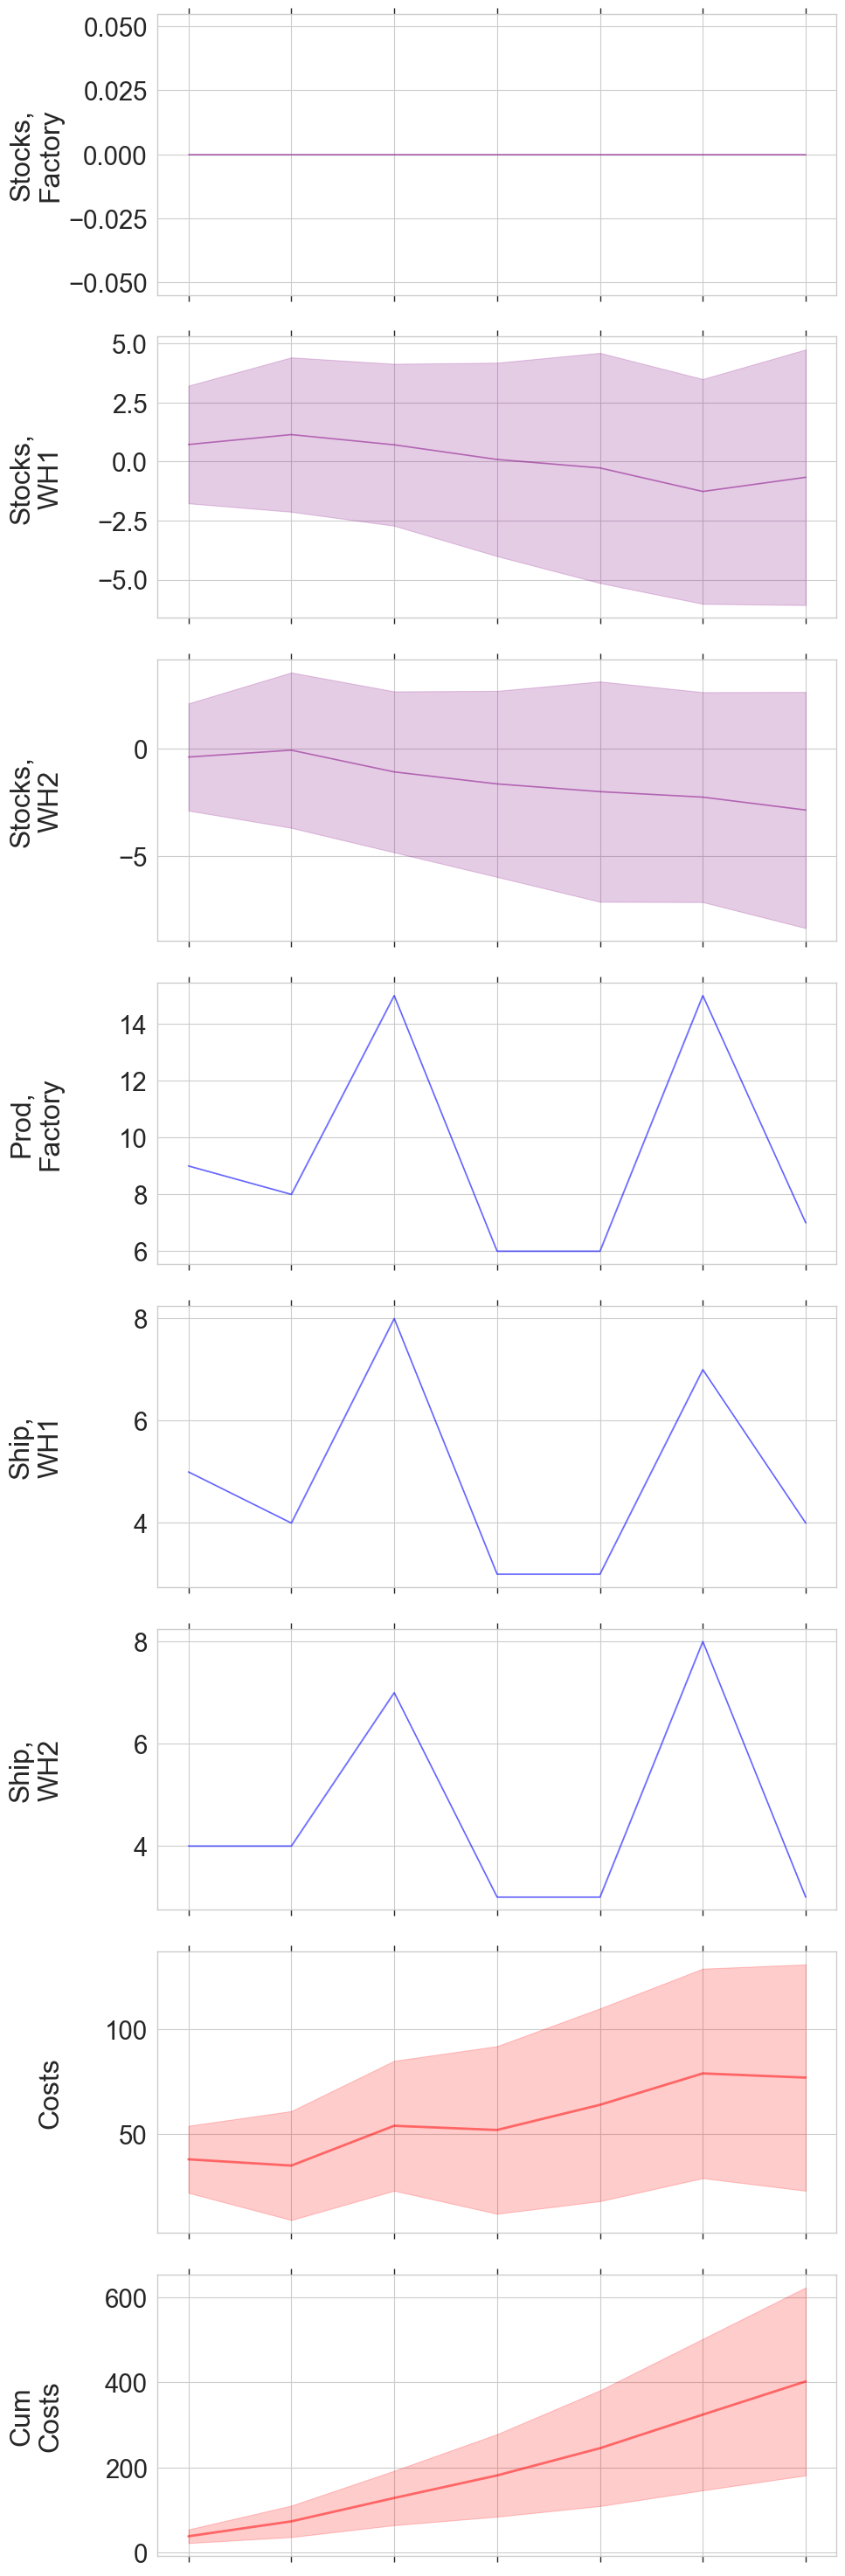

In [51]:
visualize_transitions(returns_trace_ortools, 'EVPI')

In [52]:
# cumulative profit of the ortools policy
cum_profit_ortools = calculate_cum_profit(returns_trace_ortools)

reward: mean 402.1679996338785, std 221.81937935176, max 1296.8799996338785, min 125.87999963387847


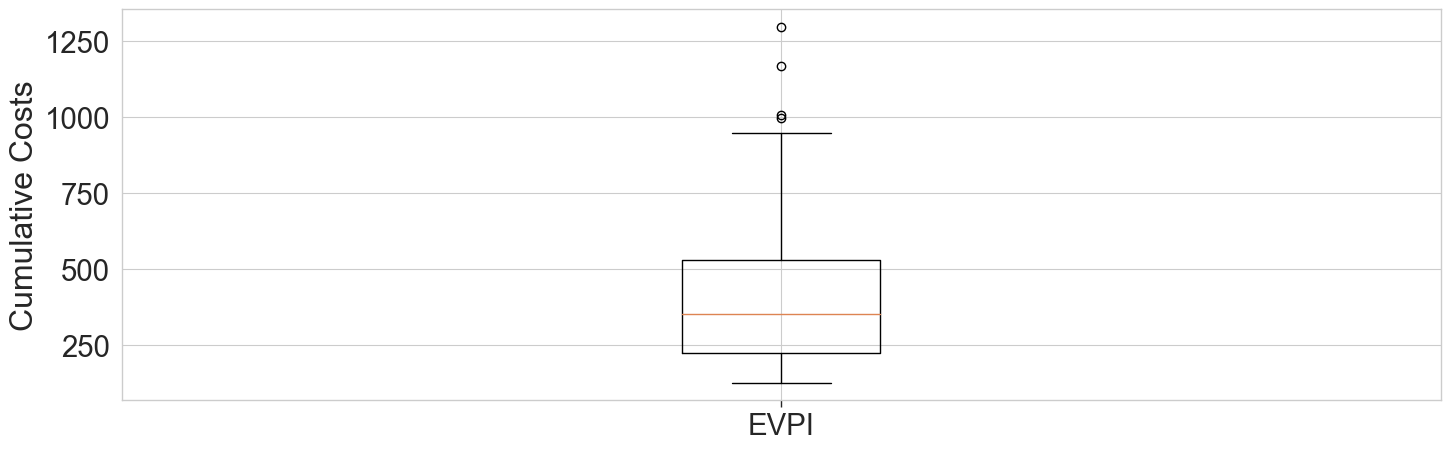

In [53]:
visualize_cum_profit(cum_profit_ortools, 'EVPI')

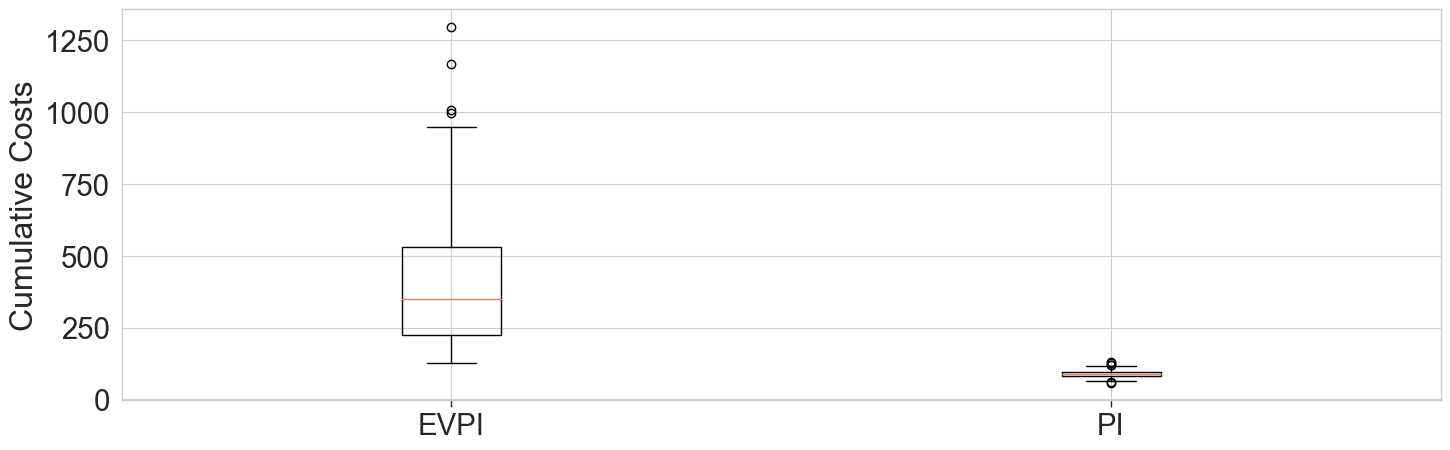

In [54]:
visualize_cum_profit([cum_profit_ortools,
                      cum_profit_ortools_det],
                     ['EVPI',
                      'PI'])

In [55]:
save_object(returns_trace_ortools_full, 'transitions_full', 'EVPI')
save_object(returns_trace_ortools, 'transitions', 'EVPI')
save_object(cum_profit_ortools, 'cum_profit', 'EVPI')

# Gurobi

## parameters

In [109]:
rolling_horizon = 4

## Scenario Tree [Gurobi]

In [111]:
class ScenarioTree(nx.DiGraph):
    def __init__(self, branching_factors, r=0):
        nx.DiGraph.__init__(self)

        self.initial_value = 0
        self.branching_factors = branching_factors
        self.tree_depth = len(self.branching_factors)
        self.scenarios_num = np.prod(self.branching_factors)

        # generating demands (Gurobi solver knows the episodes' demands
        # distribution a priori)
        stationary_demands = []
        stationary_demands.append(np.fromfunction(
            lambda j, i, t: env.stationary_demand(j+1, i+1, t+r),
            (env.distr_warehouses_num, env.product_types_num, env.T),
            dtype=np.int32))
        stationary_demands = np.array(stationary_demands[0]).tolist()

        # root node
        self.start_node = self.initial_value
        self.add_node(self.start_node,
                      obs=np.repeat(self.initial_value,
                                    env.distr_warehouses_num),
                      prob=1,
                      node_id=0,
                      step=0,
                      stage=0)
        last_nodes_added = [self.start_node]
        nodes_count = 1
        nodes_per_level_num = 1

        self.outcomes = [
            [0, 0],
            [0, env.d_var[0]],
            [env.d_var[0], 0],
            [env.d_var[0], env.d_var[0]]
            ]

        # tree nodes
        for t in range(self.tree_depth):
            next_stage = []
            nodes_per_level_num *= self.branching_factors[t]
            for node_parent in last_nodes_added:
                self.probs_scenario = 1 / self.branching_factors[t] 
                self.demands_scenario = [stationary_demands[j][0][t]
                                         for j in range(env.distr_warehouses_num)]
                for b in range(self.branching_factors[t]):
                    node_new_id = nodes_count
                    self.add_node(node_new_id,
                                  obs=[sum(x) for x in zip(self.demands_scenario,
                                                           self.outcomes[b])],
                                  prob=self.nodes[node_parent]['prob'] *
                                  self.probs_scenario,
                                  node_id=nodes_count,
                                  step=t+1,
                                  stage=t+1)
                    self.add_edge(node_parent, node_new_id)
                    next_stage.append(node_new_id)
                    nodes_count += 1
            last_nodes_added = next_stage
            self.nodes_num = nodes_count
        self.leaves = last_nodes_added

        print(f"\n{self.nodes()[i]}" for i in range(self.nodes_num))

        logger.debug(f"\n-- ScenarioTree -- __init__"
                     f"\nbranching_factors is "
                     f"{self.branching_factors}"
                     f"\ntree_depth is "
                     f"{self.tree_depth}"
                     f"\nscenarios_num is "
                     f"{self.scenarios_num}"
                     f"\ndemands_scenario is "
                     f"{self.demands_scenario}"
                     f"\nprobs_scenario is "
                     f"{self.probs_scenario}"
                     f"\nstart_node is "
                     f"{self.start_node}")

    def get_leaves(self):
        return self.leaves

    def plot(self, local_dir=local_dir, plots_dir=plots_dir):
        """Prints the tree."""
        try:
            pos = graphviz_layout(self, prog="dot")
            nx.draw(self, pos,
                    with_labels=True, arrows=True)

            # creating necessary subdir and saving plot
            if not os.path.exists(f"{local_dir}/{plots_dir}/MS"):
                os.makedirs(f"{local_dir}/{plots_dir}/MS")
            plt.savefig(f"{local_dir}/{plots_dir}/MS"
                        f"/plot_ScenarioTree.pdf",
                        format='pdf', bbox_inches='tight')
        except Exception as e:
            print(f"{e.__class__} occurred!")

## Parameters Methods [Gurobi]

In [112]:
def create_parameters_gurobi(env):
    """
    Transforms env parameters from numpy.array to lists.
    """
    # initial stocks and capacities (as lists)
    initial_stocks = 0
    factory_capacities = env.storage_capacities.tolist()[0]
    distr_w_capacities = env.storage_capacities.tolist()[1:]
    transportation_capacities = env.transportation_capacities.tolist()

    # costs (as lists)
    sale_prices = env.sale_prices.tolist()
    production_costs = env.production_costs.tolist()

    transportation_costs_fixed = env.transportation_costs_fixed.tolist()
    transportation_costs_unit = env.transportation_costs_unit.tolist()

    factory_storage_costs = env.storage_costs.tolist()[0]
    distr_w_storage_costs = env.storage_costs.tolist()[1:]
    penalty_costs = env.penalty_costs.tolist()

    logger.debug(f"\n-- Gurobi -- create_parameters_gurobi"
                 f"\ninitial_stocks is "
                 f"{initial_stocks}"
                 f"\nfactory_capacities is "
                 f"{factory_capacities}"
                 f"\ndistr_w_capacities is "
                 f"{distr_w_capacities}"
                 f"\ntransportation_capacities is "
                 f"{transportation_capacities}"
                 f"\nsale_prices is "
                 f"{sale_prices}"
                 f"\nproduction_costs is "
                 f"{production_costs}"
                 f"\ntransportation_costs_fixed is "
                 f"{transportation_costs_fixed}"
                 f"\ntransportation_costs_unit is "
                 f"{transportation_costs_unit}"
                 f"\nfactory_storage_costs is "
                 f"{factory_storage_costs}"
                 f"\ndistr_w_storage_costs is "
                 f"{distr_w_storage_costs}"
                 f"\npenalty_costs is "
                 f"{penalty_costs}")

    return (initial_stocks,
            factory_capacities, distr_w_capacities,
            transportation_capacities,
            sale_prices, production_costs,
            transportation_costs_fixed, transportation_costs_unit,
            factory_storage_costs, distr_w_storage_costs,
            penalty_costs)

## Decision Variables [Gurobi]

In [113]:
def decision_variables_gurobi(env, solver,
                              scenario_tree):
    """
    Defines Gurobi decision variables for each warehouse (including factory)
    and for each product type.
    """
    # factory decision variables
    prod_level = solver.addVars(
        scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=env.prod_level_max[0],
        name='prod_level')
    stocks_factory = solver.addVars(
        scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_factory')

    # distr_w decision variables
    shipped_stocks = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='shipped_stocks')
    stocks_distr_w_pos = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_distr_w_pos')
    stocks_distr_w_neg = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_distr_w_neg')

    # transportation decision variables
    transportation_numbers = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.INTEGER,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='transportation_numbers')

    logger.debug(f"\n-- Gurobi -- decision_variables_gurobi"
                 f"\nprod_level is "
                 f"{prod_level}"
                 f"\nstocks_factory is"
                 f"{stocks_factory}"
                 f"\nshipped_stocks is "
                 f"{shipped_stocks}"
                 f"\nstocks_distr_w_pos is "
                 f"{stocks_distr_w_pos}"
                 f"\nstocks_distr_w_neg is "
                 f"{stocks_distr_w_neg}"
                 f"\ntransportation_numbers is "
                 f"{transportation_numbers}")

    return (prod_level, stocks_factory,
            shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
            transportation_numbers)

## Constraints [Gurobi]

In [114]:
def constraints_gurobi(env, solver,
                       scenario_tree,
                       prod_level, stocks_factory,
                       shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
                       transportation_numbers, transportation_capacities,
                       factory_capacities, distr_w_capacities):
    """
    Defines Gurobi constraints for each warehouse (including factory) and for
    each product type.
    """
    # step 0 (factory and warehouses)
    solver.addConstrs((
        stocks_factory[n] + prod_level[n] >=
        grb.quicksum(
        shipped_stocks[j, n]
        for j in range(env.distr_warehouses_num))
        for n in range(scenario_tree.nodes_num)),
        name='no_backlog_factory_stocks')

    solver.addConstrs(
        (stocks_factory[n] + prod_level[n] <=
         factory_capacities[0]
         for n in range(scenario_tree.nodes_num)),
        name='factory_capacities')
    solver.addConstrs(
        (stocks_distr_w_pos[j, n] + shipped_stocks[j, n] <=
         distr_w_capacities[j][0]
         for j in range(env.distr_warehouses_num)
         for n in range(scenario_tree.nodes_num)),
        name='distr_w_capacities')

    # step 0 state (factory and warehouses)
    state_gurobi = env.initial_state()
    constr_factory_stocks = solver.addConstr(
        stocks_factory[0] ==
        state_gurobi.factory_stocks[0],
        name='state_factory_stocks_0')
    constr_distr_warehouses_stocks = solver.addConstrs(
        (stocks_distr_w_pos[j, 0] - stocks_distr_w_neg[j, 0] ==
         state_gurobi.distr_warehouses_stocks[j]
         for j in range(env.distr_warehouses_num)),
        name='state_distr_warehouses_stocks_0')

    # steps > 0 (factory and warehouses)
    constr_scenario_tree = []
    for n in range(1, scenario_tree.nodes_num):
        parent = list(scenario_tree.predecessors(n))[0]
        solver.addConstr(
            stocks_factory[n] ==
            stocks_factory[parent] +
            prod_level[parent] -
            grb.quicksum(
                shipped_stocks[j, parent]
                for j in range(env.distr_warehouses_num)),
            name="factory_stocks")
        constr_scenario_tree.append(solver.addConstrs(
            (stocks_distr_w_pos[j, n] -
             stocks_distr_w_neg[j, n] ==
             stocks_distr_w_pos[j, parent] - stocks_distr_w_neg[j, parent] +
             shipped_stocks[j, parent] - scenario_tree.nodes()[parent]['obs'][j]
             for j in range(env.distr_warehouses_num)),
            name="distr_warehouses_stocks"))

    solver.addConstrs(
        (shipped_stocks[j, n] <= distr_w_capacities[j][0]
         for j in range(env.distr_warehouses_num)
         for n in range(scenario_tree.nodes_num)),
        name='shipped_stocks_capacities')
    solver.addConstrs(
        (shipped_stocks[j, n] <= transportation_numbers[j, n] *
         transportation_capacities[j][0]
         for j in range(env.distr_warehouses_num)
         for n in range(scenario_tree.nodes_num)),
        name='transportation_capacities')

    return (constr_factory_stocks, constr_distr_warehouses_stocks,
            constr_scenario_tree)

## Objective Function [Gurobi]

In [115]:
def obj_func_gurobi(env, scenario_tree,
                    stocks_factory,
                    prod_level, production_costs,
                    stocks_distr_w_pos, stocks_distr_w_neg,
                    shipped_stocks, transportation_numbers,
                    transportation_costs_fixed, transportation_costs_unit,
                    factory_storage_costs, distr_w_storage_costs,
                    penalty_costs):
    """
    Defines Gurobi objective function.
    """
    # production costs
    total_production_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        production_costs[0] * prod_level[n]
        for n in range(scenario_tree.nodes_num))

    # transportation costs
    total_transportation_costs_fixed = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        transportation_costs_fixed[j][0] * transportation_numbers[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_transportation_costs_unit = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        transportation_costs_unit[j][0] * shipped_stocks[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_transportation_costs = total_transportation_costs_fixed + \
        total_transportation_costs_fixed

    # storage costs
    total_factory_storage_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        factory_storage_costs[0] * stocks_factory[n]
        for n in range(scenario_tree.nodes_num))
    total_distr_w_storage_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        distr_w_storage_costs[j][0] * stocks_distr_w_pos[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_storage_costs = total_factory_storage_costs + \
        total_distr_w_storage_costs

    # penalty costs
    total_distr_w_penalty_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        penalty_costs[0] * stocks_distr_w_neg[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_penalty_costs = total_distr_w_penalty_costs

    # reward
    reward = total_production_costs + \
        total_transportation_costs + total_storage_costs + total_penalty_costs

    logger.debug(f"\n--- Gurobi --- objective_function_gurobi"
                 f"\ntotal_production_costs is "
                 f"{total_production_costs}"
                 f"\ntotal_transportation_costs_fixed is "
                 f"{total_transportation_costs_fixed}"
                 f"\ntotal_transportation_costs_unit is "
                 f"{total_transportation_costs_unit}"
                 f"\ntotal_transportation_costs is "
                 f"{total_transportation_costs}"
                 f"\ntotal_storage_costs is "
                 f"{total_storage_costs}"
                 f"\ntotal_penalty_costs is "
                 f"{total_penalty_costs}"
                 f"\nreward is "
                 f"{reward}")

    return reward

## Simulator Methods [Gurobi]

In [117]:
def simulate_episode_gurobi(env, solver,
                            prod_level, shipped_stocks,
                            stocks_distr_w_pos, stocks_distr_w_neg,
                            constr_factory_stocks,
                            constr_distr_warehouses_stocks,
                            constr_scenario_tree,
                            rolling_horizon, seed):
    """
    Gurobi single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_gurobi --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        action = Action(state.product_types_num, state.distr_warehouses_num)
        scenario_tree = ScenarioTree(branching_factors=np.repeat(
            4, rolling_horizon),
            r=t)
        for i in range(state.product_types_num):
            constr_factory_stocks.rhs = state.factory_stocks[i]
        for j in range(state.distr_warehouses_num):
            for i in range(state.product_types_num):
                constr_distr_warehouses_stocks[j].rhs = \
                    state.distr_warehouses_stocks[j][i]

        for n in range(1, scenario_tree.nodes_num):
            parent = list(scenario_tree.predecessors(n))[0]
            solver.remove(constr_scenario_tree[n-1])
            constr_scenario_tree[n-1] = solver.addConstrs(
                (stocks_distr_w_pos[j, n] - stocks_distr_w_neg[j, n] ==
                 stocks_distr_w_pos[j, parent] -
                 stocks_distr_w_neg[j, parent] +
                 shipped_stocks[j, parent] - scenario_tree.nodes()[n]['obs'][j]
                 for j in range(env.distr_warehouses_num)),
                name="distr_warehouses_stocks")

        # updating the model
        solver.update()
        if not os.path.exists(f"{local_dir}/{plots_dir}/MS"):
            os.makedirs(f"{local_dir}/{plots_dir}/MS")
        solver.write(f"{local_dir}/{plots_dir}/MS"
                     f"/MS_{t}.lp")
        # solving the model
        solver.optimize()
        if solver.Status in (grb.GRB.INF_OR_UNBD,
                             grb.GRB.INFEASIBLE,
                             grb.GRB.UNBOUNDED):
            print(f"THE MODEL CANNOT BE SOLVED! ({solver.Status})")
        else:
            if solver.Status != grb.GRB.OPTIMAL:
                print(f"SOLUTION NON OPTIMAL! ({solver.Status})")
            else:
                print(f"SOLUTION OPTIMAL! ({solver.Status})")
            for j in range(state.distr_warehouses_num):
                for i in range(state.product_types_num):
                    action.production_level[i] = prod_level[0].X
                    action.shipped_stocks[j][i] = shipped_stocks[j, 0].X

            state, reward, _ = env.step(state, action)
            transitions_full.append(np.array(
                [state, action, reward],
                dtype=object))
            if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
                transitions.append(np.array(
                    [state, action, reward],
                    dtype=object))

            logger.debug(f"\naction is "
                         f"{action}"
                         f"\naction.production_level is "
                         f"{action.production_level}"
                         f"\naction.shipped_stocks is "
                         f"{action.shipped_stocks}"
                         f"\nstate is "
                         f"{state}"
                         f"\nstate.factory_stocks is "
                         f"{state.factory_stocks}"
                         f"\nstate.distr_warehouses_stocks is "
                         f"{state.distr_warehouses_stocks}"
                         f"\nstate.demand_history is "
                         f"{state.demand_history}"
                         f"\nt is "
                         f"{t}"
                         f"\nreward is "
                         f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_gurobi(env, solver,
                    prod_level, shipped_stocks,
                    stocks_distr_w_pos, stocks_distr_w_neg,
                    constr_factory_stocks,
                    constr_distr_warehouses_stocks,
                    constr_scenario_tree,
                    rolling_horizon,
                    num_episodes=1, seed=SEED):
    """
    Gurobi simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_gurobi_testing = []

    for episode in range(num_episodes):
        seed = None
        if episode == 0:
            seed = seed

        start_gurobi = default_timer()
        rt_full, rt = simulate_episode_gurobi(
            env, solver,
            prod_level, shipped_stocks,
            stocks_distr_w_pos, stocks_distr_w_neg,
            constr_factory_stocks,
            constr_distr_warehouses_stocks,
            constr_scenario_tree,
            rolling_horizon, seed)
        end_gurobi = default_timer()
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_gurobi_testing.append(end_gurobi-start_gurobi)

    logger.debug(f"\n-- simulate_gurobi --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_gurobi_testing]

In [118]:
# initializing the scenario tree
scenario_tree = ScenarioTree(branching_factors=np.repeat(4, rolling_horizon))

# plotting the scenario tree
scenario_tree.plot()

# Gurobi solver (with multiple scenarios)
# https://www.gurobi.com/documentation/9.5/refman/multiple_scenarios.html
# https://www.gurobi.com/documentation/9.5/examples/multiscenario_py.html
solver_st = grb.Model('Gurobi_solver')
# setting the seed
solver_st.setParam('Seed', SEED)
# setting the time limit (in seconds)
solver_st.setParam('TimeLimit', 60)
# silencing the computation output
solver_st.setParam('OutputFlag', 0)
# updating the solver
solver_st.update()

# Gurobi parameters
(initial_stocks_gurobi,
 factory_capacities_gurobi, distr_w_capacities_gurobi,
 transportation_capacities_gurobi,
 sale_prices_gurobi, production_costs_gurobi,
 transportation_costs_fixed_gurobi, transportation_costs_unit_gurobi,
 factory_storage_costs_gurobi, distr_w_storage_costs_gurobi,
 penalty_costs_gurobi) = create_parameters_gurobi(env)

# Gurobi decision variables
(prod_level, stocks_factory,
 shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
 transportation_numbers) = decision_variables_gurobi(env, solver_st,
                                                     scenario_tree)

# Gurobi constraints
(constr_factory_stocks, constr_distr_warehouses_stocks,
 constr_scenario_tree) = constraints_gurobi(
    env, solver_st,
    scenario_tree,
    prod_level, stocks_factory,
    shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
    transportation_numbers, transportation_capacities_gurobi,
    factory_capacities_gurobi, distr_w_capacities_gurobi)

# reward
reward = obj_func_gurobi(env, scenario_tree,
                         stocks_factory,
                         prod_level, production_costs_gurobi,
                         stocks_distr_w_pos, stocks_distr_w_neg,
                         shipped_stocks, transportation_numbers,
                         transportation_costs_fixed_gurobi,
                         transportation_costs_unit_gurobi,
                         factory_storage_costs_gurobi, distr_w_storage_costs_gurobi,
                         penalty_costs_gurobi)

# setting the objective function
solver_st.setObjective(reward, grb.GRB.MINIMIZE)
# updating the solver
solver_st.update()
# optimizing the solver
solver_st.optimize()

print(f"number of variables is {len(solver_st.getVars())}")
print(f"number of constraints is {len(solver_st.getConstrs())}")

# evaluating the Gurobi policy
np.random.seed(SEED)
env.reset(SEED)
(returns_trace_gurobi_full, returns_trace_gurobi,
 time_gurobi_testing) = simulate_gurobi(env, solver_st,
                                        prod_level, shipped_stocks,
                                        stocks_distr_w_pos, stocks_distr_w_neg,
                                        constr_factory_stocks,
                                        constr_distr_warehouses_stocks,
                                        constr_scenario_tree,
                                        rolling_horizon,
                                        NUM_EPISODES)

# calculating and printing the Gurobi training time
time_gurobi_total_training =  np.round((np.sum(time_gurobi_testing)), 6)
time_gurobi_mean_training = np.round((np.mean(time_gurobi_testing)), 6)
time_gurobi_std_training = np.round((np.std(time_gurobi_testing)), 6)
print(f"total training time Gurobi (in seconds) is {time_gurobi_total_training}")
print(f"mean training time Gurobi (in seconds) is {time_gurobi_mean_training}")
print(f"std training time Gurobi (in seconds) is {time_gurobi_std_training}")

<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB473EDC8>
<class 'FileNotFoundError'> occurred!
Set parameter Seed to value 2023
Set parameter TimeLimit to value 60
number of variables is 3410
number of constraints is 3751
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EACE6F748>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EACE6F748>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EACE6F748>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EAC7A22C8>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EAC7A22C8>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EACE6F748>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EAC7A22C8>
SOLUTION OPTIMAL! (2)
<generator object Scenari

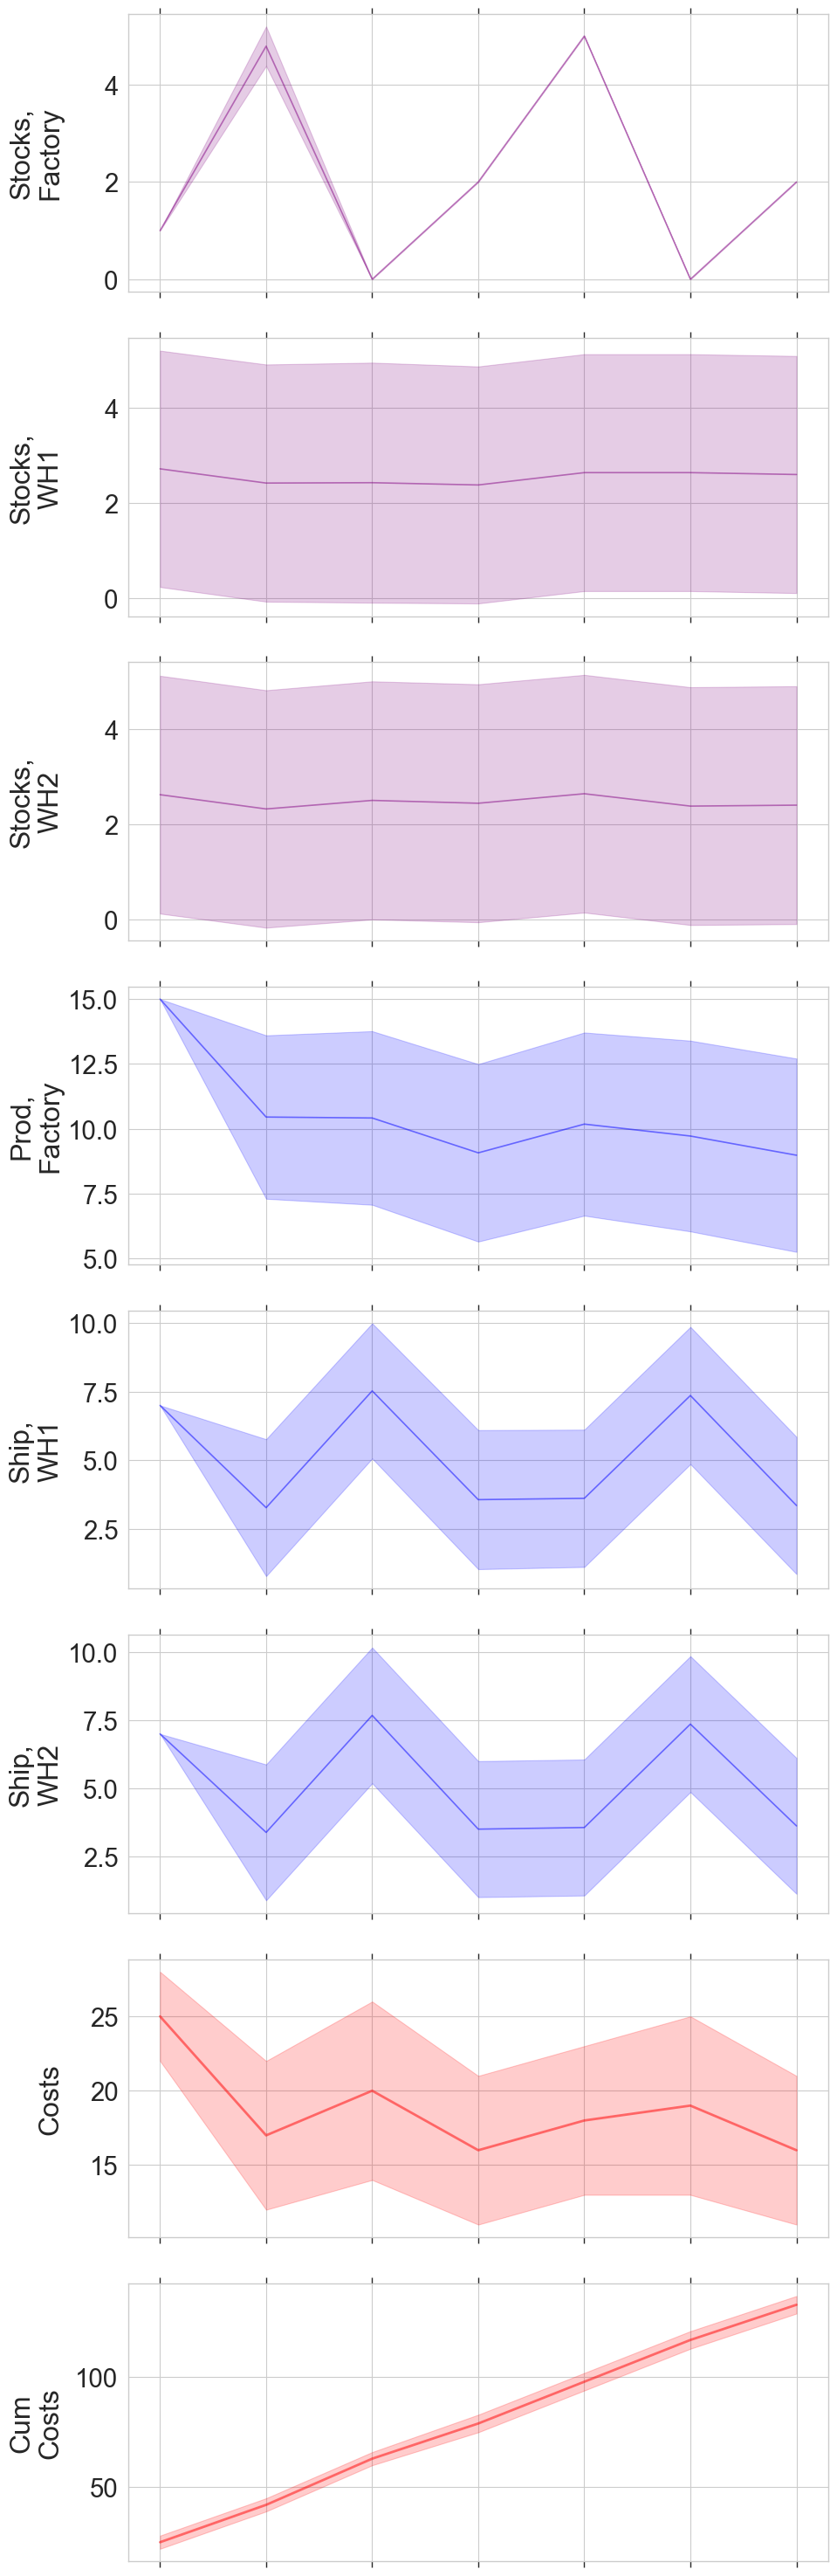

In [119]:
visualize_transitions(returns_trace_gurobi, 'MS')

In [120]:
# cumulative profit of the Gurobi policy
cum_profit_gurobi = calculate_cum_profit(returns_trace_gurobi)

reward: mean 133.93859961692243, std 4.825309511089897, max 152.50999954529107, min 124.5599996894598


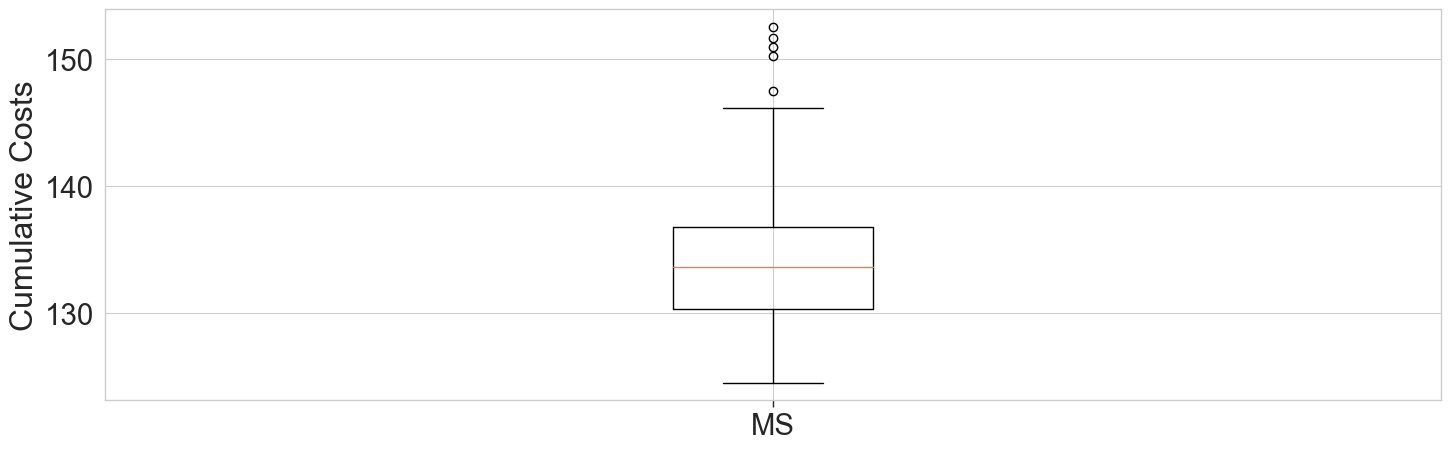

In [121]:
visualize_cum_profit(cum_profit_gurobi, 'MS')

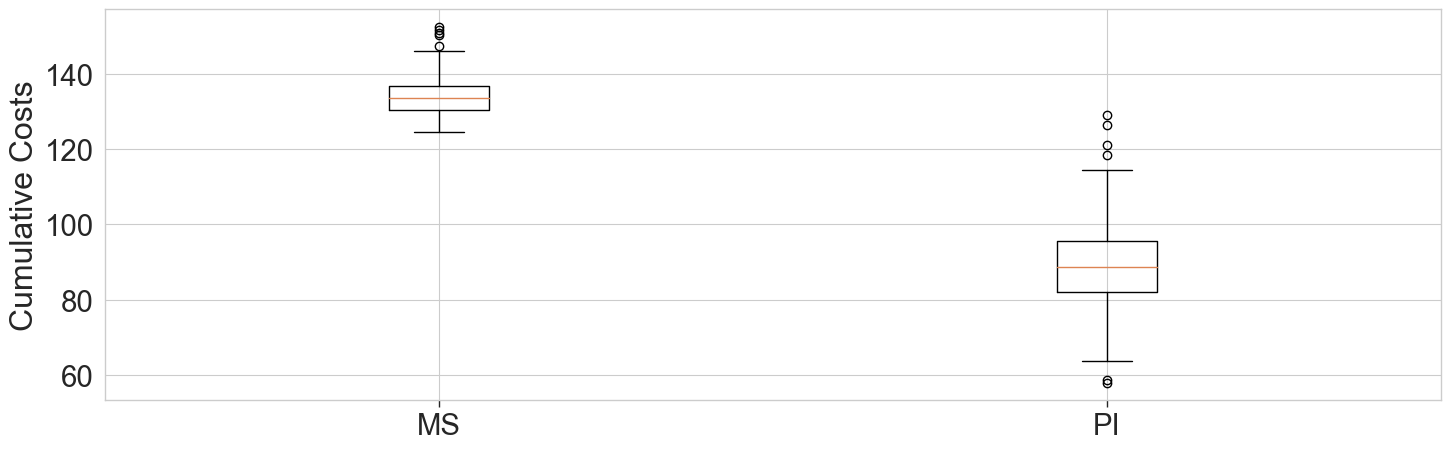

In [122]:
visualize_cum_profit([cum_profit_gurobi,
                      cum_profit_ortools_det],
                     ['MS',
                      'PI'])

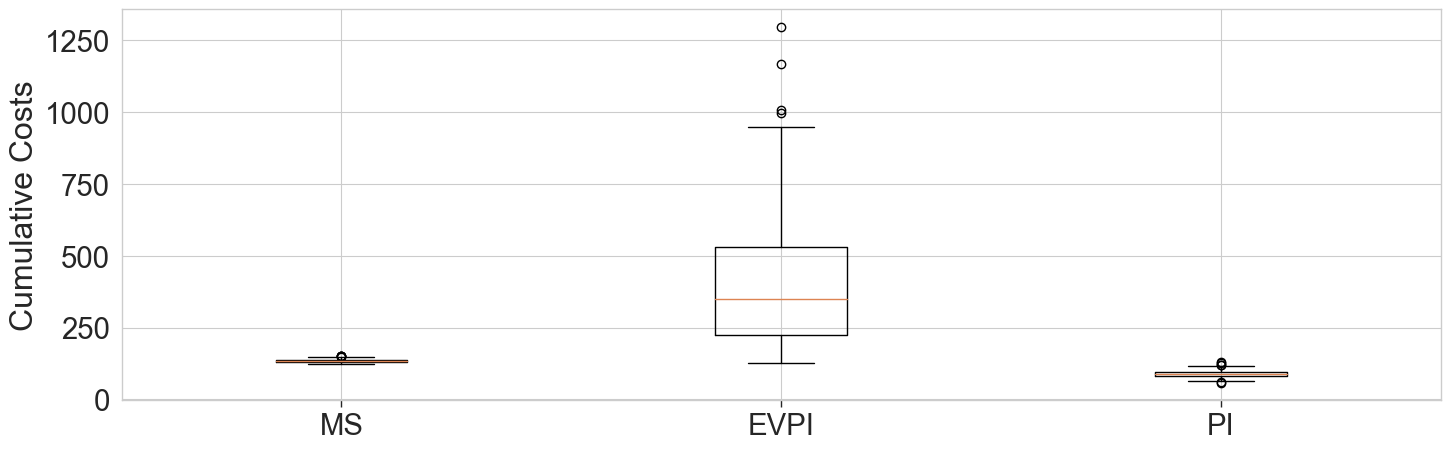

In [123]:
visualize_cum_profit([cum_profit_gurobi,
                      cum_profit_ortools,
                      cum_profit_ortools_det],
                     ['MS',
                      'EVPI',
                      'PI'])

In [124]:
save_object(returns_trace_gurobi_full, 'transitions_full', 'MS')
save_object(returns_trace_gurobi, 'transitions', 'MS')
save_object(cum_profit_gurobi, 'cum_profit', 'MS')

# sQ-Policy Class

In [131]:
class sQPolicy:
    """
    To assess and compare performances achieved by the adopted DRL algorithms,
    we implement a static reorder policy known in the specialized literature as
    the (s, Q)-policy. This policy can be expressed by a rule, which can be
    summarized as follows: at each time step t, the current stock level for a
    specific warehouse and product type is compared to the reorder point s.
    If the stock level falls below the reorder point s, then the (s, Q)-policy
    orders Q units of product; otherwise, it does not take any action.
    """

    def __init__(self, factory_s, factory_Q, warehouses_s, warehouses_Q):
        self.factory_s = factory_s
        self.factory_Q = factory_Q
        self.warehouses_s = warehouses_s
        self.warehouses_Q = warehouses_Q

        logger.debug(f"\n--- sQPolicy --- __init__"
                     f"\nfactory_s is "
                     f"{self.factory_s}"
                     f"\nfactory_Q is "
                     f"{self.factory_Q}"
                     f"\nwarehouses_s is "
                     f"{self.warehouses_s}"
                     f"\nwarehouses_Q is "
                     f"{self.warehouses_Q}")

    def select_action(self, state):
        action = Action(state.product_types_num, state.distr_warehouses_num)

        # reordering decisions are made independently for factory and
        # distribution warehouses, so policy parameters (s and Q) can be
        # different for each warehouse
        for j in range(state.distr_warehouses_num):
            for i in range(state.product_types_num):
                if state.distr_warehouses_stocks[j][i] < \
                        self.warehouses_s[j][i]:
                    action.shipped_stocks[j][i] = \
                        self.warehouses_Q[j][i]

        for i in range(state.product_types_num):
            if (state.factory_stocks[i] -
                    np.sum(action.shipped_stocks, axis=0)[i]) < \
                    self.factory_s[i]:
                action.production_level[i] = \
                    self.factory_Q[i]

        logger.debug(f"\n--- sQPolicy --- select_action"
                     f"\nstate is "
                     f"{state}"
                     f"\naction is "
                     f"{action}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nwarehouses_s is "
                     f"{self.warehouses_s}"
                     f"\nwarehouses_Q is "
                     f"{self.warehouses_Q}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nnp.sum(action.shipped_stocks, axis=0) is "
                     f"{np.sum(action.shipped_stocks, axis=0)}"
                     f"\nstate.factory_stocks - "
                     f"np.sum(action.shipped_stocks, axis=0) is "
                     f"""{state.factory_stocks -
                         np.sum(action.shipped_stocks, axis=0)}"""
                     f"\nfactory_s is "
                     f"{self.factory_s}"
                     f"\nfactory_Q is "
                     f"{self.factory_Q}"
                     f"\naction.production_level is "
                     f"{action.production_level}")

        return action

# sQ-Policy Config [Ax]

## sQ Parameters [Ax]

In [132]:
# total trials for Ax (s, Q)-policy optimization
total_trials_sQ = 75
# number of episodes for each trial
num_episodes_sQ = [NUM_EPISODES]
# number of iterations for each number of episodes
iterations_sQ = 1

## sQ Parameters Methods [Ax]

In [134]:
def create_parameters_sQ(env):
    """
    Create Ax (s, Q)-policy parameters (s and Q) for the factory, the
    distribution warehouses and for each product type.
    """
    # factory parameters
    factory_parameters = [
        {'name': 'factory',
         'type': 'range',
         'value_type': 'int', },
    ]

    factory_parameters_sQ = []

    # factory parameters (s and Q) for each product type, according to storage
    # capacities
    for factory_parameter in factory_parameters:
        for i in range(env.product_types_num):
            factory_parameters_sQ.append(
                {**factory_parameter,
                 'name': factory_parameter['name'] + '_s_' + str(i+1),
                 'bounds': [0, env.storage_capacities[0][i].item(0)], })
            factory_parameters_sQ.append(
                {**factory_parameter,
                 'name': factory_parameter['name'] + '_Q_' + str(i+1),
                 'bounds': [0, env.prod_level_max[i].item(0)], })

    # distribution warehouses parameters
    w_parameters = [
        {'name': 'w',
         'type': 'range',
         'value_type': 'int', },
    ]

    w_parameters_sQ = []

    # distribution warehouses parameters (s and Q) for each product type,
    # according to storage capacities
    for w_parameter in w_parameters:
        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                w_parameters_sQ.append(
                    {**w_parameter,
                     'name': w_parameter['name'] + str(j+1) + '_s_' + str(i+1),
                     'bounds': [0, env.storage_capacities[j+1][i].item(0)], })
                w_parameters_sQ.append(
                    {**w_parameter,
                     'name': w_parameter['name'] + str(j+1) + '_Q_' + str(i+1),
                     'bounds': [0, env.storage_capacities[j+1][i].item(0)], })

    # final Ax (s, Q)-policy parameters
    parameters_sQ = factory_parameters_sQ + w_parameters_sQ

    logger.debug(f"\n-- create_parameters_SQ --"
                 f"\nparameters_SQ is "
                 f"{parameters_sQ}")

    return parameters_sQ

## Simulator Methods [Ax]

In [135]:
def simulate_episode_policy(env, policy, seed):
    """
    Single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_policy --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions_full.append(np.array(
            [state, action, reward],
            dtype=object))
        if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
            transitions.append(np.array(
                [state, action, reward],
                dtype=object))

        logger.debug(f"\naction is "
                     f"{action}"
                     f"\naction.production_level is "
                     f"{action.production_level}"
                     f"\naction.shipped_stocks is "
                     f"{action.shipped_stocks}"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nstate.demand_history is "
                     f"{state.demand_history}"
                     f"\nt is "
                     f"{t}"
                     f"\nreward is "
                     f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_policy(env, policy, testing=True, num_episodes=1, seed=SEED):
    """
    Simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_policy_testing = []

    for episode in range(num_episodes):
        seed = None
        if testing == True and episode == 0:
            seed = seed
        start_policy = default_timer()
        rt_full, rt = simulate_episode_policy(env,
                                              policy,
                                              seed)
        end_policy = default_timer()
        
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_policy_testing.append(end_policy-start_policy)

    logger.debug(f"\n-- simulate_policy --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_policy_testing]

# sQ-Policy Methods [Ax]

## Optimize sQ Methods [Ax]

In [136]:
def opt_func_sQ(p):
    """
    Evaluation function to optimize (to maximize).
    """
    args = [[],
            [],
            [],
            []]

    # nested list for warehouses parameters
    args[2] = [[] for _ in range(env.distr_warehouses_num)]
    args[3] = [[] for _ in range(env.distr_warehouses_num)]

    for i in range(env.product_types_num):
        args[0].append(p[f"factory_s_{i+1}"])
        args[1].append(p[f"factory_Q_{i+1}"])
        for j in range(env.distr_warehouses_num):
            args[2][j].append(p[f"w{j+1}_s_{i+1}"])
            args[3][j].append(p[f"w{j+1}_Q_{i+1}"])

    policy = sQPolicy(*args)

    return -np.mean(calculate_cum_profit(simulate_policy(env, policy,
                                                         False, NUM_EPISODES)[0],
                                                         print_reward=False))


def optimize_sQ(num_episodes_sQ, iterations_sQ, parameters_sQ, total_trials_sQ,
                seed, num_episodes=1):
    """
    Brute force search through the parameter space using the Adaptive
    Experimentation Platform developed by Facebook. This framework provides a
    very convenient API and uses Bayesian optimization internally.
    """
    best_mean_cum_profit_sQ = None
    for num_episode_sQ in num_episodes_sQ:
        for iteration in range(iterations_sQ):
            # Ax optimization runs total_trials times, each trial sees a given
            # number of episodes and this procedure is repeated for each
            # iteration, searching the best parameters for the Ax (s, Q)-policy
            start_sQ = default_timer()
            parameters, values, experiment, model = optimize(
                parameters=parameters_sQ,
                evaluation_function=opt_func_sQ,
                objective_name='episode_reward_mean',
                minimize=False,
                total_trials=total_trials_sQ,
                random_seed=seed)
            end_sQ = default_timer()
            time_training_sQ = end_sQ-start_sQ

            # setting the optimised parameters for current num episodes and
            # iteration
            policy_sQ = sQPolicy(
                [parameters[f"factory_s_{i+1}"]
                 for i in range(env.product_types_num)],
                [parameters[f"factory_Q_{i+1}"]
                 for i in range(env.product_types_num)],
                [[parameters[f"w{j+1}_s_{i+1}"]
                  for i in range(env.product_types_num)]
                 for j in range(env.distr_warehouses_num)],
                [[parameters[f"w{j+1}_Q_{i+1}"]
                  for i in range(env.product_types_num)]
                 for j in range(env.distr_warehouses_num)])

            # evaluating the Ax (s, Q)-policy for current num episodes and
            # iteration
            np.random.seed(seed)
            env.reset(seed)
            (returns_trace_sQ_full, returns_trace_sQ,
             time_testing_sQ) = simulate_policy(env, policy_sQ, True, num_episodes)
            
            # printing current num episodes and iteration
            print(f"--num episodes: {num_episode_sQ}, "
                  f"iteration: {iteration+1}")

            # cumulative profit of the Ax (s, Q)-policy for current
            # num episodes and iteration
            cum_profit_sQ_full = calculate_cum_profit(returns_trace_sQ_full)

            # finding the best parameters for the Ax (s, Q)-policy
            if (best_mean_cum_profit_sQ is None or
                    np.mean(cum_profit_sQ_full) > best_mean_cum_profit_sQ):
                best_mean_cum_profit_sQ = np.mean(cum_profit_sQ_full)
                best_num_episodes = num_episode_sQ
                best_iteration = iteration
                best_parameters = parameters
                best_values = values
                best_experiment = experiment
                best_model = model
                time_sQ = [time_training_sQ, time_testing_sQ]
                best_policy_sQ = policy_sQ
                best_returns_trace_sQ_full = returns_trace_sQ_full
                best_returns_trace_sQ = returns_trace_sQ
                best_cum_profit_sQ = calculate_cum_profit(returns_trace_sQ)

    logger.debug(f"\n-- optimize_sQ --"
                 f"\nbest_mean_cum_profit_sQ is "
                 f"{best_mean_cum_profit_sQ}"
                 f"\nbest_num_episodes is "
                 f"{best_num_episodes}"
                 f"\nbest_iteration is "
                 f"{best_iteration}"
                 f"\nbest_parameters is "
                 f"{best_parameters}"
                 f"\nbest_values is "
                 f"{best_values}"
                 f"\nbest_experiment is "
                 f"{best_experiment}"
                 f"\nbest_model is "
                 f"{best_model}"
                 f"\ntime_sQ is "
                 f"{time_sQ}"
                 f"\nbest_policy_sQ is "
                 f"{best_policy_sQ}"
                 f"\nbest_returns_trace_sQ_full is "
                 f"{best_returns_trace_sQ_full}"
                 f"\nbest_returns_trace_sQ is "
                 f"{best_returns_trace_sQ}"
                 f"\nbest_cum_profit_sQ is "
                 f"{best_cum_profit_sQ}")

    return (best_mean_cum_profit_sQ, best_num_episodes, best_iteration,
            best_parameters, best_values, best_experiment, best_model,
            time_sQ, best_policy_sQ, best_returns_trace_sQ_full,
            best_returns_trace_sQ, best_cum_profit_sQ)

## Visualize Rewards Methods [Ax]

In [137]:
def visualize_optimization_trace_sQ(experiment, verbose,
                                    local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot the mean reward along the trials iterations.
    """
    try:
        best_objectives = np.array(
            [[trial.objective_mean
              for trial in experiment.trials.values()]])
        best_objective_plot = optimization_trace_single_method_plotly(
            y=np.maximum.accumulate(best_objectives, axis=1),
            ylabel='Reward Mean',
            title='sQ Performance vs. Trials Iterations')
        if verbose == 3:
            best_objective_plot.show()
        # creating necessary subdir and saving plot
        if not os.path.exists(f"{local_dir}/{plots_dir}"
                              f"/sQ"):
            os.makedirs(f"{local_dir}/{plots_dir}"
                        f"/sQ")
        best_objective_plot.write_image(f"{local_dir}/{plots_dir}"
                                        f"/sQ"
                                        f"/optimization_trace.pdf")
    except Exception as e:
        print(f"{e.__class__} occurred!")


def visualize_contour_sQ(model, parameters, env, verbose,
                         local_dir=local_dir, plots_dir=plots_dir):
    """
    Plot the contours, showing the episode reward mean as a function of two
    selected parameters (e.g., 'factory_s_1' and 'factory_Q_1').
    """
    try:
        # creating necessary subdir
        if not os.path.exists(f"{local_dir}/{plots_dir}"
                              f"/sQ/contours"):
            os.makedirs(f"{local_dir}/{plots_dir}"
                        f"/sQ/contours")

        # saving plots
        if env.product_types_num == 2:
            for p in range(0,
                           env.product_types_num,
                           1):
                contour = plot_contour_plotly(
                    model=model,
                    metric_name='episode_reward_mean',
                    param_x=list(parameters)[p],
                    param_y=list(parameters)[p+2])
                contour.write_image(f"{local_dir}/{plots_dir}"
                                    f"/sQ/contours"
                                    f"/contour_"
                                    f"{list(parameters)[p]}_"
                                    f"{list(parameters)[p+2]}.pdf")
                if verbose == 3:
                    contour.show()
            for p in range(2*env.product_types_num,
                           len(parameters),
                           2):
                contour = plot_contour_plotly(
                    model=model,
                    metric_name='episode_reward_mean',
                    param_x=list(parameters)[p],
                    param_y=list(parameters)[p+1])
                contour.write_image(f"{local_dir}/{plots_dir}"
                                    f"/sQ/contours"
                                    f"/contour_"
                                    f"{list(parameters)[p]}_"
                                    f"{list(parameters)[p+1]}.pdf")
                if verbose == 3:
                    contour.show()
        elif env.product_types_num == 1:
            for p in range(0,
                           len(parameters),
                           2):
                contour = plot_contour_plotly(
                    model=model,
                    metric_name='episode_reward_mean',
                    param_x=list(parameters)[p],
                    param_y=list(parameters)[p+1])
                contour.write_image(f"{local_dir}/{plots_dir}"
                                    f"/sQ/contours"
                                    f"/contour_"
                                    f"{list(parameters)[p]}_"
                                    f"{list(parameters)[p+1]}.pdf")
                if verbose == 3:
                    contour.show()

        # interactive contour plot
        if verbose == 3:
            render(interact_contour(model=model,
                   metric_name='episode_reward_mean'))
    except Exception as e:
        print(f"{e.__class__} occurred!")


def move_dir_sQ(local_dir=local_dir, plots_dir=plots_dir):
    """
    Move dirs whose name starts with 'sQ_' (related to all optimizations) in
    the main sQ dir.
    """
    try:
        src_dir = f"{local_dir}/{plots_dir}/"
        dst_dir = f"{local_dir}/{plots_dir}/sQ"

        pattern = src_dir + "sQ_*"
        for file in glob.iglob(pattern, recursive=True):
            shutil.move(file, dst_dir)
            print('moved:', file)
    except Exception as e:
        print(f"{e.__class__} occurred!")

# sQ-Policy Optimize [Ax]

In [138]:
# (s, Q)-policy parameters
parameters_sQ = create_parameters_sQ(env)
parameters_sQ

[{'name': 'factory_s_1',
  'type': 'range',
  'value_type': 'int',
  'bounds': [0, 20]},
 {'name': 'factory_Q_1',
  'type': 'range',
  'value_type': 'int',
  'bounds': [0, 15]},
 {'name': 'w1_s_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 10]},
 {'name': 'w1_Q_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 10]},
 {'name': 'w2_s_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 10]},
 {'name': 'w2_Q_1', 'type': 'range', 'value_type': 'int', 'bounds': [0, 10]}]

In [139]:
# (s, Q)-policy optimization
(best_mean_cum_profit_sQ, best_num_episodes_sQ, best_iteration_sQ,
 best_parameters_sQ, best_values_sQ, best_experiment_sQ, best_model_sQ,
 time_sQ, best_policy_sQ, best_returns_trace_sQ_full,
 best_returns_trace_sQ, best_cum_profit_sQ) = \
    optimize_sQ(num_episodes_sQ, iterations_sQ, parameters_sQ, total_trials_sQ,
                SEED, NUM_EPISODES)

[INFO 03-26 20:57:56] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='factory_s_1', parameter_type=INT, range=[0, 20]), RangeParameter(name='factory_Q_1', parameter_type=INT, range=[0, 15]), RangeParameter(name='w1_s_1', parameter_type=INT, range=[0, 10]), RangeParameter(name='w1_Q_1', parameter_type=INT, range=[0, 10]), RangeParameter(name='w2_s_1', parameter_type=INT, range=[0, 10]), RangeParameter(name='w2_Q_1', parameter_type=INT, range=[0, 10])], parameter_constraints=[]).
[INFO 03-26 20:57:56] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 03-26 20:57:56] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 12 trials, GPEI for subsequent trials]). Iterations after 12 will take longer to generate due to  model-fitting.
[INFO 0

--num episodes: 250, iteration: 1
reward: mean 200.46927955056728, std 16.964118008397822, max 324.9399994574487, min 163.23999946936965
reward: mean 200.46927955056728, std 16.964118008397822, max 324.9399994574487, min 163.23999946936965


In [140]:
# printing the best Ax mean cum profit with related num episodes and iteration
print(f"best num episodes is {best_num_episodes_sQ} "
      f"at iteration {best_iteration_sQ+1} "
      f"\nmean cum profit: {best_mean_cum_profit_sQ}")

best num episodes is 250 at iteration 1 
mean cum profit: 200.46927955056728


In [141]:
visualize_optimization_trace_sQ(best_experiment_sQ, VERBOSE)

<class 'UnicodeDecodeError'> occurred!


In [142]:
visualize_contour_sQ(best_model_sQ, best_parameters_sQ, env, VERBOSE)

[ERROR 03-26 21:08:01] ax.plot.helper: Have observations of arms with different features but same name. Arbitrary one will be plotted.


<class 'AttributeError'> occurred!


In [143]:
# displaying and saving the (s, Q)-policy best parameters
display(best_parameters_sQ)
save_checkpoint(str(best_parameters_sQ), 'sQ')

{'factory_s_1': 20,
 'factory_Q_1': 14,
 'w1_s_1': 8,
 'w1_Q_1': 8,
 'w2_s_1': 9,
 'w2_Q_1': 8}

In [144]:
# calculating and printing the (s, Q)-policy training time
time_sQ_training = time_sQ[0]
time_sQ_total_training = np.round(convert_seconds_to_min_sec(time_sQ[0]), 6)
print(f"total training time sQ (in minutes) is {time_sQ_total_training}")

total training time sQ (in minutes) is 8.18642


In [145]:
# calculating and printing the (s, Q)-policy testing time
time_sQ_testing = time_sQ[1]
time_sQ_total_testing = np.round((np.sum(time_sQ_testing)), 6)
time_sQ_mean_testing = np.round((np.mean(time_sQ_testing)), 6)
time_sQ_std_testing = np.round((np.std(time_sQ_testing)), 6)
print(f"total testing time sQ (in seconds) is {time_sQ_total_testing}")
print(f"mean testing time sQ (in seconds) is {time_sQ_mean_testing}")
print(f"std testing time sQ (in seconds) is {time_sQ_std_testing}")

total testing time sQ (in seconds) is 4.713993
mean testing time sQ (in seconds) is 0.018856
std testing time sQ (in seconds) is 0.002652


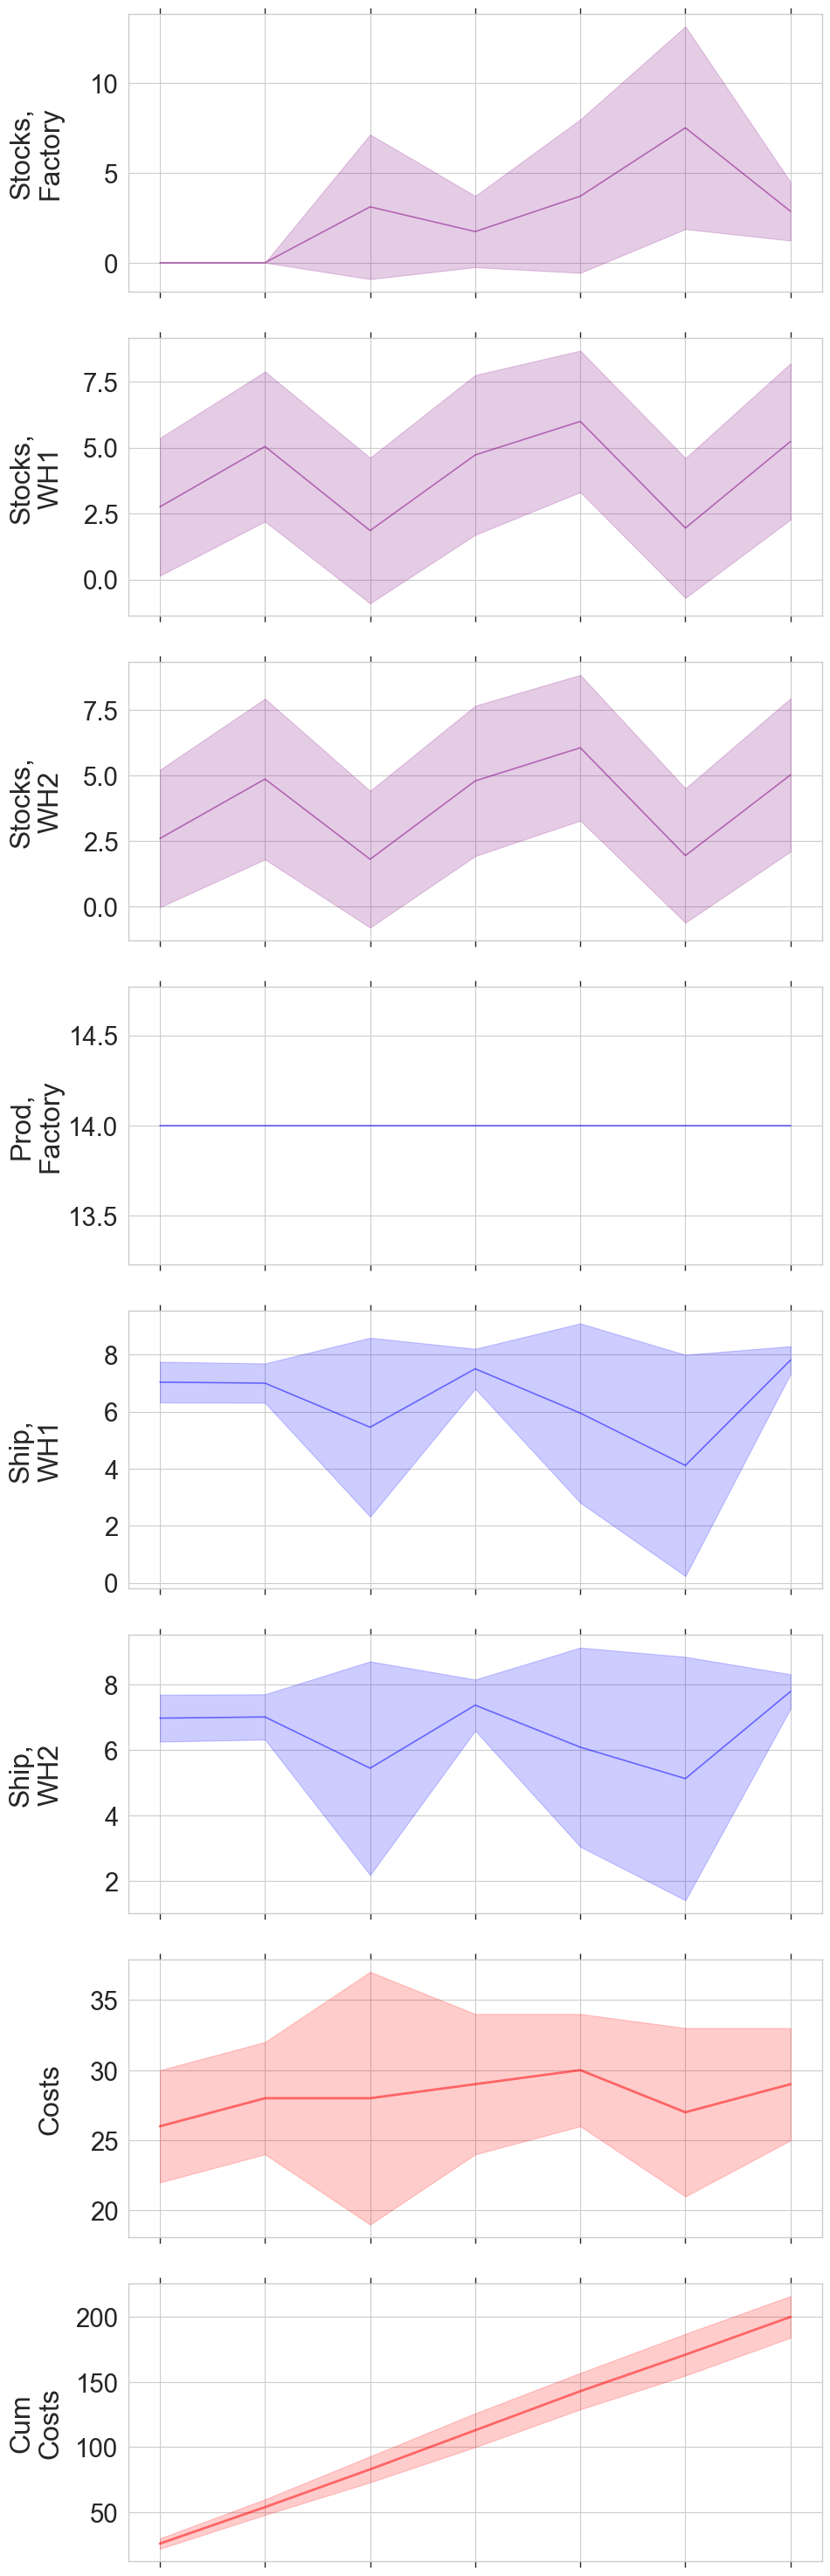

In [146]:
visualize_transitions(best_returns_trace_sQ, 'sQ')

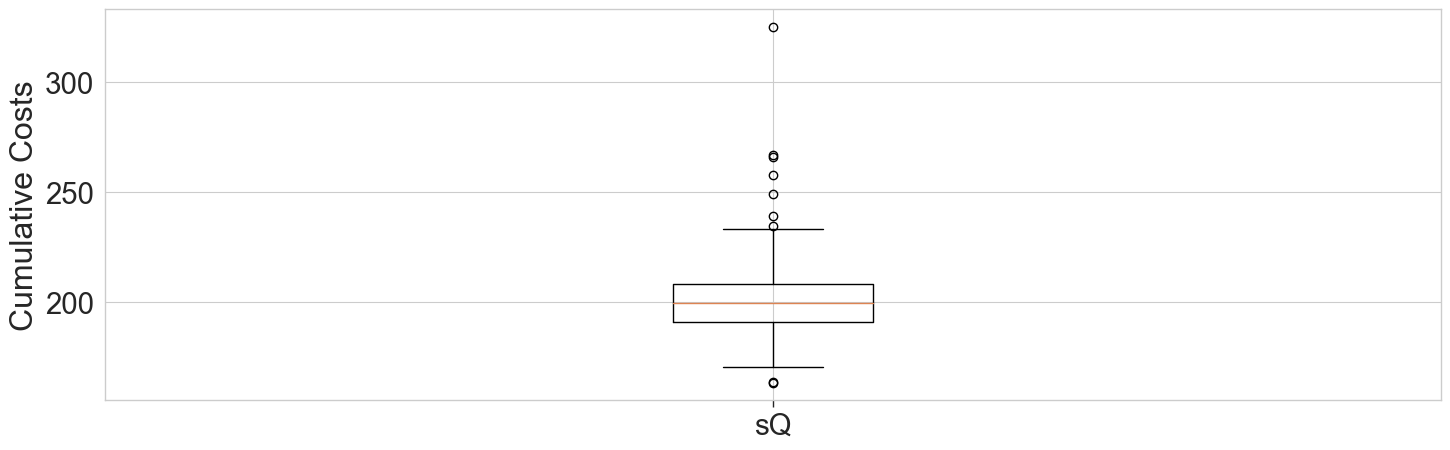

In [147]:
visualize_cum_profit(best_cum_profit_sQ, 'sQ')

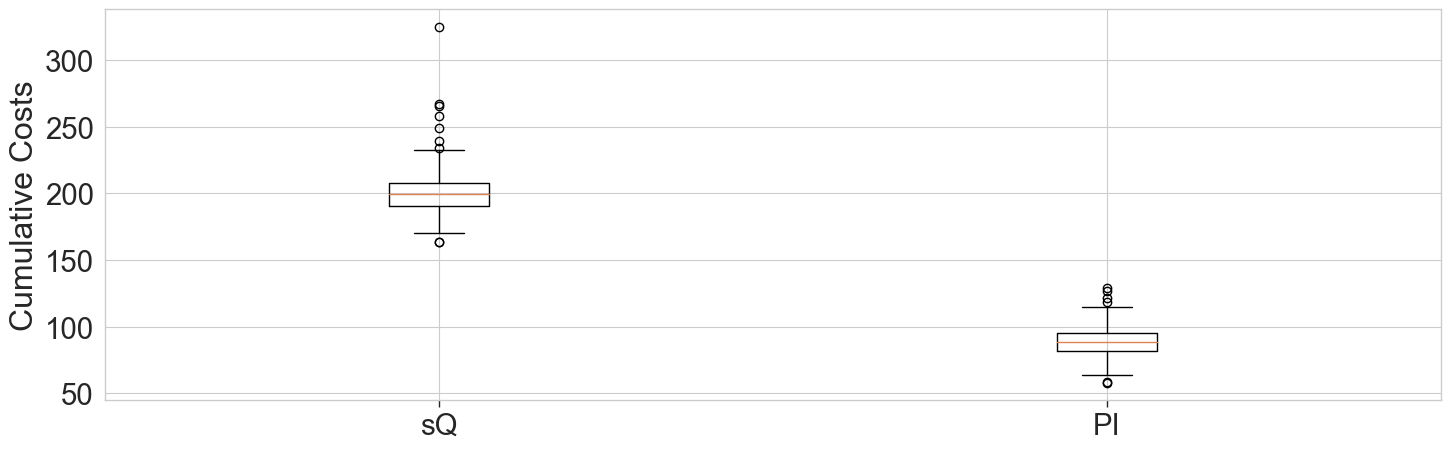

In [148]:
visualize_cum_profit([best_cum_profit_sQ,
                      cum_profit_ortools_det],
                     ['sQ',
                      'PI'])

In [149]:
# moving the (s, Q)-policy optimization dirs in the main sQ dir
move_dir_sQ()

In [150]:
save_object(best_returns_trace_sQ_full, 'transitions_full', 'sQ')
save_object(best_returns_trace_sQ, 'transitions', 'sQ')
save_object(best_cum_profit_sQ, 'cum_profit', 'sQ')

# Reinforcement Learning Config [Tune]

## Parameters [Tune]

In [64]:
# number of episodes for RLib agents
num_episodes_ray = 75000
# stop trials at least from this number of episodes
grace_period_ray = num_episodes_ray / 10
# number of episodes to consider
std_episodes_ray = 5.0
# number of epochs to wait for a change in the episodes
top_episodes_ray = NUM_EPISODES

In [65]:
# dir for saving Ray results
ray_dir = 'ray_results'
# creating necessary dir
if not os.path.exists(f"{local_dir+'/'+ray_dir}"):
    os.makedirs(f"{local_dir+'/'+ray_dir}")

## Algorithms [Tune]

In [66]:
# https://docs.ray.io/en/latest/rllib-algorithms.html
# https://docs.ray.io/en/master/rllib-training.html#common-parameters
# adopted algorithms
algorithms = {
    'PPO': ppo.PPO,
}

## PPO Config [Tune]

In [67]:
# https://docs.ray.io/en/master/rllib-algorithms.html#ppo
config_PPO = ppo.DEFAULT_CONFIG.copy()
config_PPO['seed'] = SEED
config_PPO['log_level'] = 'WARN'

config_PPO['env'] = SupplyChain
config_PPO['horizon'] = env.T-1
config_PPO['batch_mode'] = 'complete_episodes'

config_PPO['model']['fcnet_hiddens'] = tune.grid_search([[64, 64]])
config_PPO['model']['fcnet_activation'] = tune.grid_search(['relu'])

config_PPO['lr'] = tune.grid_search([5e-5])
config_PPO['gamma'] = .99

config_PPO['rollout_fragment_length'] = tune.grid_search(['auto'])
config_PPO['train_batch_size'] = tune.grid_search([8000])

config_PPO['num_sgd_iter'] = tune.grid_search([15])
config_PPO['sgd_minibatch_size'] = tune.grid_search([512])

config_PPO['num_workers'] = 16-1
config_PPO['num_gpus'] = 0

config_PPO['framework'] = 'torch'

# Reinforcement Learning Methods [Tune]

## Train Agents Methods [Tune]

In [68]:
def train(algorithm, config, verbose,
          num_episodes_ray=num_episodes_ray, grace_period_ray=grace_period_ray,
          std_episodes_ray=std_episodes_ray, top_episodes_ray=top_episodes_ray,
          local_dir=local_dir, ray_dir=ray_dir):
    """
    Train a RLib Agent.
    """
    # initializing Ray
    ray.shutdown()
    ray.init(log_to_driver=False)

    logger.debug(f"\n-- train --"
                 f"\nalgorithm is "
                 f"{algorithm}"
                 f"\nconfig is "
                 f"{config}")

    # https://docs.ray.io/en/latest/tune/api_docs/execution.html
    # https://docs.ray.io/en/master/tune/api_docs/schedulers.html
    # https://docs.ray.io/en/latest/tune/api_docs/stoppers.html
    # https://docs.ray.io/en/master/tune/api_docs/analysis.html
    analysis = tune.run(algorithm,
                        config=config,
                        metric='episode_reward_mean',
                        mode='max',
                        scheduler=ASHAScheduler(
                            time_attr='episodes_total',
                            max_t=num_episodes_ray,
                            grace_period=grace_period_ray,
                            reduction_factor=5),
                        stop=CombinedStopper(
                            ExperimentPlateauStopper(
                                metric='episode_reward_mean',
                                std=std_episodes_ray,
                                top=top_episodes_ray,
                                mode='max',
                                patience=5),
                            MaximumIterationStopper(
                                max_iter=num_episodes_ray)
                        ),
                        checkpoint_freq=1,
                        keep_checkpoints_num=1,
                        checkpoint_score_attr='episode_reward_mean',
                        progress_reporter=tune.JupyterNotebookReporter(
                            overwrite=True),
                        max_failures=5,
                        verbose=verbose,
                        local_dir=os.getcwd()+'/'+local_dir+'/'+ray_dir)

    trial_dataframes = analysis.trial_dataframes
    best_result_df = analysis.best_result_df
    best_config = analysis.best_config
    best_checkpoint = analysis.best_checkpoint._local_path
    print(f"\ncheckpoint saved at {best_checkpoint}")

    # stopping Ray
    ray.shutdown()

    return trial_dataframes, best_result_df, best_config, best_checkpoint


def result_df_as_image(result_df, algorithm,
                       local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize the (DataFrame) RLib Agent's result as an image.
    """
    # creating necessary subdir and saving plot
    if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
        os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
    dfi.export(result_df.iloc[:, np.r_[:3, 9]],
               f"{local_dir}/{plots_dir}/{algorithm}"
               f"/best_result_{algorithm}.png",
               table_conversion='matplotlib')
    # saving pandas DataFrame as LaTeX table
    f = open(f"{local_dir}/{plots_dir}/{algorithm}"
             f"/best_result_{algorithm}.tex",
             'w', encoding='utf-8')
    f.write(result_df.iloc[:, np.r_[:3, 9]].style.to_latex())
    f.close()


def calculate_training_time(result_df):
    """
    Calculate a RLib Agent training time (minutes).
    """
    return result_df.time_total_s[0]


def calculate_training_episodes(result_df):
    """
    Calculate a RLib Agent training episodes (number).
    """
    return round(result_df.episodes_total[0],
                 -len(str(result_df.episodes_total[0]))+2)

## Simulator Methods [Tune]

In [69]:
def simulate_episode_tune(env, policy, seed):
    """
    Single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_tune --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        action = policy.compute_single_action(state.to_array(),
                                              normalize_actions=True,
                                              explore=False)[0].astype(
            np.int32)
        action_obj = Action(env.product_types_num,
                            env.distr_warehouses_num)
        action_obj.production_level = np.minimum(
            action[:env.product_types_num],
            env.prod_level_max)
        action_obj.shipped_stocks = action[
            env.product_types_num:
        ].reshape(env.distr_warehouses_num, env.product_types_num)

        state, reward, _ = env.step(state, action_obj)
        transitions_full.append(np.array(
            [state, action_obj, reward],
            dtype=object))
        if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
            transitions.append(np.array(
                [state, action_obj, reward],
                dtype=object))

        logger.debug(f"\naction is "
                     f"{action}"
                     f"\naction_obj is "
                     f"{action_obj}"
                     f"\naction_obj.production_level is "
                     f"{action_obj.production_level}"
                     f"\naction_obj.shipped_stocks is "
                     f"{action_obj.shipped_stocks}"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nstate.demand_history is "
                     f"{state.demand_history}"
                     f"\nt is "
                     f"{t}"
                     f"\nreward is "
                     f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_tune(env, policy, num_episodes=1, seed=SEED):
    """
    Simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_tune = []

    for episode in range(num_episodes):
        seed = None
        if episode == 0:
            seed = seed

        start_tune = default_timer()
        rt_full, rt = simulate_episode_tune(env,
                                            policy,
                                            seed)
        end_tune = default_timer()
        
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_tune.append(end_tune-start_tune)

    logger.debug(f"\n-- simulate_tune --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_tune]

## Policy Methods [Tune]

In [70]:
def load_policy(algorithm, config, checkpoint):
    """
    Load a RLib Agent policy.
    """
    # initializing Ray
    ray.shutdown()
    ray.init(log_to_driver=False)

    # loading policy
    trainer = algorithm(config=config)
    trainer.restore(f"{checkpoint}")
    policy = trainer.get_policy()

    # stopping Ray
    ray.shutdown()

    logger.debug(f"\n-- load_policy --"
                 f"\nalgorithm is "
                 f"{algorithm}"
                 f"\nconfig is "
                 f"{config}"
                 f"\ncheckpoint is "
                 f"{checkpoint}"
                 f"\ntrainer is "
                 f"{trainer}"
                 f"\npolicy is "
                 f"{policy}")

    return policy


def fix_best_checkpoint(checkpoint):
    """
    Fix a RLib Agent best checkpoint path.
    """
    # searching all checkpoints related to the best agent's result
    checkpoint_dir = checkpoint.rsplit('/', 1)[0]
    sub_dirs = [sub_dir for sub_dir in os.listdir(checkpoint_dir)
                if os.path.isdir(os.path.join(checkpoint_dir, sub_dir))]
    # finding the most recent checkpoint (the best one)
    sub_dirs.sort(reverse=True)

    # creating the fixed best checkpoint path
    fixed_checkpoint_dir = checkpoint_dir + '/' + sub_dirs[0] + '/'
    fixed_checkpoint_files = os.listdir(fixed_checkpoint_dir)
    fixed_checkpoint_files.sort()
    fixed_checkpoint_file = fixed_checkpoint_files[0].split('.')[0]
    best_checkpoint = fixed_checkpoint_dir + fixed_checkpoint_file

    logger.debug(f"\n-- fix_best_checkpoint --"
                 f"\nfixed_checkpoint_dir is "
                 f"{fixed_checkpoint_dir}"
                 f"\nfixed_checkpoint_file is "
                 f"{fixed_checkpoint_file}"
                 f"\nbest_checkpoint is "
                 f"{best_checkpoint}")

    return best_checkpoint

## Visualize Rewards Methods [Tune]

In [71]:
def apply_style_plot(ax, xticks_total, episodes_total, legend):
    """
    Auxiliary function.
    """
    ax.set_xticks([0,
                  xticks_total//2,
                  xticks_total])
    ax.set_xticklabels([str(0),
                       str(episodes_total//2),
                       str(episodes_total)])
    ax.set_xlabel('Episodes')
    ax.legend(legend, bbox_to_anchor=(1.04, .5), borderaxespad=0,
              frameon=False, loc='center left', fancybox=True, shadow=True)
    ax.ticklabel_format(axis='y', style='plain',
                        useOffset=False)


def visualize_rewards(results, best_result, algorithm, legend=[],
                      local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize the min, mean and max rewards along the episodes.
    """
    # creating necessary subdir and saving plot
    if not os.path.exists(f"{local_dir}/{plots_dir}/{algorithm}"):
        os.makedirs(f"{local_dir}/{plots_dir}/{algorithm}")
    xticks_total = len(list(results.values())[0])-1
    episodes_total = calculate_training_episodes(best_result)

    # min reward
    fig, ax = plt.subplots(figsize=(15, 5))
    for result in results.values():
        ax = result.episode_reward_min.plot(ax=ax)
    apply_style_plot(ax, xticks_total, episodes_total, legend)
    ax.set_ylabel('Min Reward')
    plt.tight_layout()
    plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}"
                f"/episode_reward_min_{algorithm}.pdf",
                format='pdf', bbox_inches='tight')

    # mean reward
    fig, ax = plt.subplots(figsize=(15, 5))
    for result in results.values():
        ax = result.episode_reward_mean.plot(ax=ax)
    apply_style_plot(ax, xticks_total, episodes_total, legend)
    ax.set_ylabel('Mean Reward')
    plt.tight_layout()
    plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}"
                f"/episode_reward_mean_{algorithm}.pdf",
                format='pdf', bbox_inches='tight')

    # max reward
    fig, ax = plt.subplots(figsize=(15, 5))
    for result in results.values():
        ax = result.episode_reward_max.plot(ax=ax)
    apply_style_plot(ax, xticks_total, episodes_total, legend)
    ax.set_ylabel('Max Reward')
    plt.tight_layout()
    plt.savefig(f"{local_dir}/{plots_dir}/{algorithm}"
                f"/episode_reward_max_{algorithm}.pdf",
                format='pdf', bbox_inches='tight')

# Reinforcement Learning Train Agents [Tune]

## PPO Agent [Tune]

In [72]:
# training a PPO agent
(results_PPO, best_result_PPO,
 best_config_PPO, checkpoint_PPO) = train(algorithms['PPO'],
                                          config_PPO,
                                          VERBOSE)


checkpoint saved at D:\UoE\Informatics\Year4\MLP\Group Project\source code\Optimizing-Supply-Chain-Drcision-Through-Reinforcement-Learning\SCIMAI-Gym-main\1P2W_2025-03-26_20-02-47\ray_results\PPO_2025-03-26_20-07-51\PPO_SupplyChain_ff3d7_00000_0_lr=0.0001,fcnet_activation=relu,fcnet_hiddens=64_64,num_sgd_iter=15,rollout_fragment_length=auto,sgd_2025-03-26_20-07-51\checkpoint_000057


In [73]:
# saving and showing the best result of the PPO agent
result_df_as_image(best_result_PPO, 'PPO')
best_result_PPO

episode_reward_max  episode_reward_min  episode_reward_mean  \
trial_id                                                                   
ff3d7_00000             -122.21             -243.61          -160.412509   

             episode_len_mean  episodes_this_iter  num_faulty_episodes  \
trial_id                                                                 
ff3d7_00000               6.0                1335                    0   

             num_healthy_workers  num_in_flight_async_reqs  \
trial_id                                                     
ff3d7_00000                   15                         0   

             num_remote_worker_restarts  num_agent_steps_sampled  ...  \
trial_id                                                          ...   
ff3d7_00000                           0                   456570  ...   

             info/learner/default_policy/learner_stats/grad_gnorm  \
trial_id                                                            
ff3d7_00000                                           3.500733      

             info/learner/default_policy/learner_stats/cur_kl_coeff  \
trial_id                                                              
ff3d7_00000                                                0.3        

             info/learner/default_policy/learner_stats/cur_lr  \
trial_id                                                        
ff3d7_00000                                           0.00005   

             info/learner/default_policy/learner_stats/total_loss  \
trial_id                                                            
ff3d7_00000                                            9.98932      

             info/learner/default_policy/learner_stats/policy_loss  \
trial_id                                                             
ff3d7_00000                                          -0.012834       

             info/learner/default_policy/learner_stats/vf_loss  \
trial_id                                                         
ff3d7_00000                                               10.0   

             info/learner/default_policy/learner_stats/vf_explained_var  \
trial_id                                                                  
ff3d7_00000                                          -0.003919            

             info/learner/default_policy/learner_stats/kl  \
trial_id                                                    
ff3d7_00000                                      0.007179   

             info/learner/default_policy/learner_stats/entropy  \
trial_id                                                         
ff3d7_00000                                           4.596896   

             info/learner/default_policy/learner_stats/entropy_coeff  
trial_id                                                              
ff3d7_00000                                                0.0        

[1 rows x 265 columns]

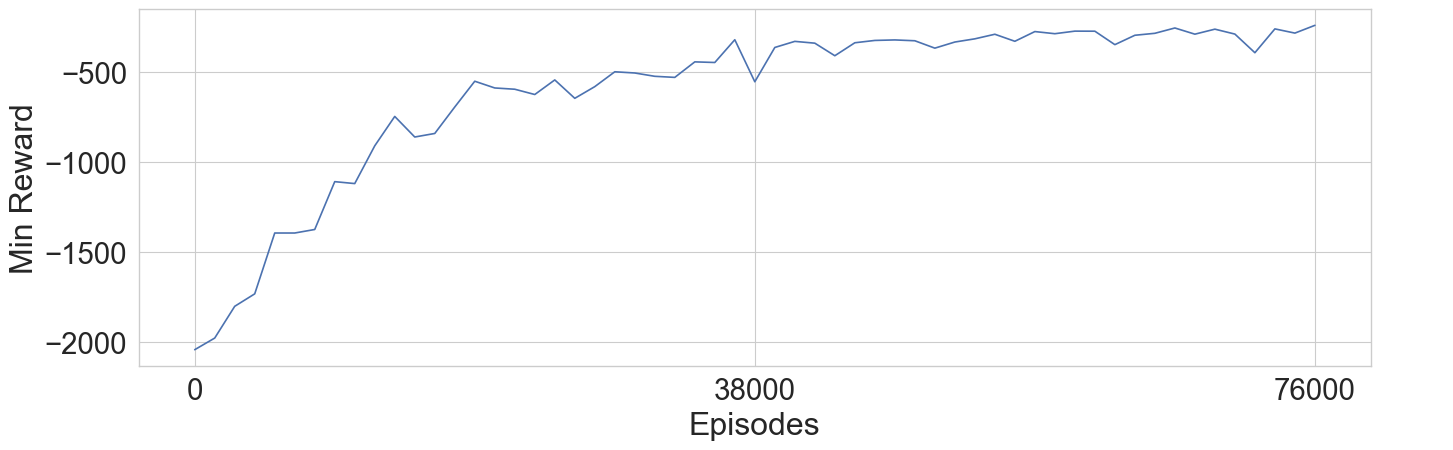

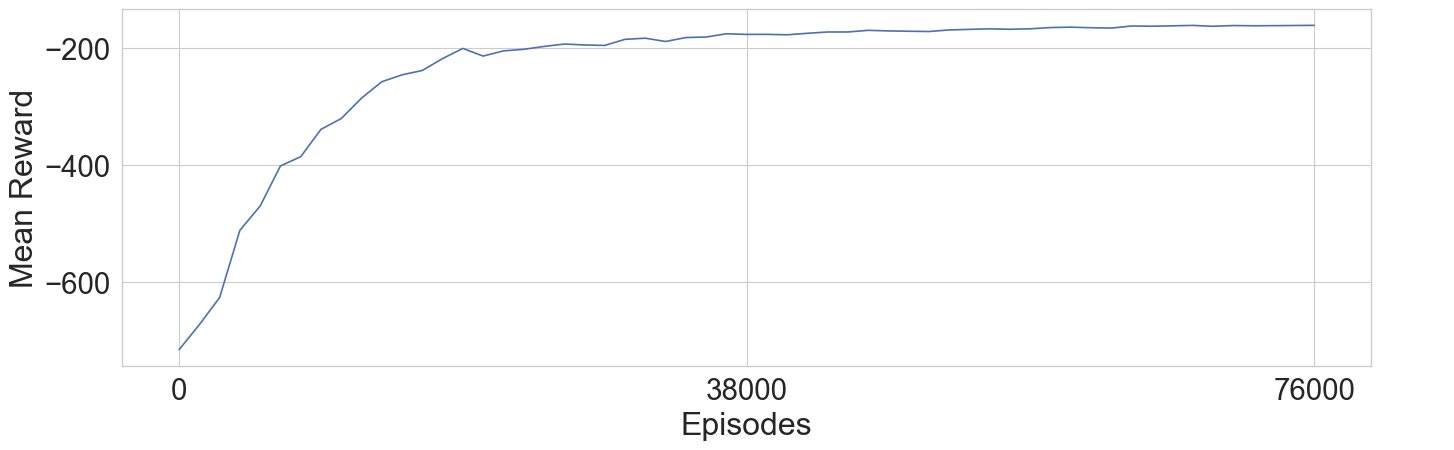

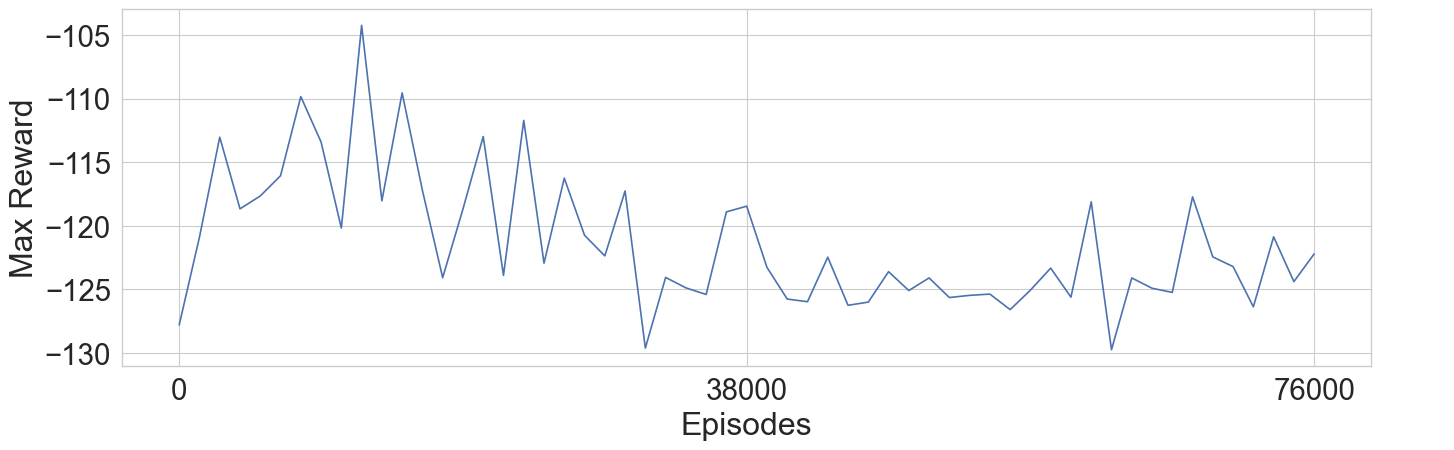

In [74]:
visualize_rewards(results_PPO, best_result_PPO, 'PPO')


In [75]:
# calculating and printing the PPO training time
time_PPO = calculate_training_time(best_result_PPO)
time_PPO_total_training = np.round(convert_seconds_to_min_sec(time_PPO), 6)
print(f"total training time PPO (in minutes) is {time_PPO_total_training}")

total training time PPO (in minutes) is 11.329831


In [76]:
# (fixing and) saving the PPO best checkpoint
best_checkpoint_PPO = fix_best_checkpoint(checkpoint_PPO)
save_checkpoint(best_checkpoint_PPO, 'PPO')

In [77]:
# loading the best PPO agent's policy
policy_PPO = load_policy(algorithms['PPO'],
                         best_config_PPO,
                         best_checkpoint_PPO)

2025-03-26 20:20:50,263	INFO worker.py:1550 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2025-03-26 20:20:54,968	INFO algorithm.py:507 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2025-03-26 20:21:08,675	INFO trainable.py:176 -- Trainable.setup took 13.712 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-03-26 20:21:08,690	WARNING algorithm_config.py:597 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
2025-03-26 20:21:08,828	INFO trainable.py:792 -- Restored on 127.0.0.1 from checkpoint: D:\UoE\Informatics\Year4\MLP\Group Project\source code\Optimizing-Supply-Chain-Drcision-Through-Reinforcement-Learning\SCIMAI-Gym-main\1P2W_2025-03-26_20-02-47\ray_results\PPO_2025-03-26_20-07-51\PPO_SupplyChain_ff3d7_00000_0_lr=0.0001,fcnet_activation=relu,fcnet_hiddens=64_64,num_

In [78]:
# evaluating the best PPO agent's policy
np.random.seed(SEED)
env.reset(SEED)
(returns_trace_PPO_full, returns_trace_PPO,
 time_PPO_testing) = simulate_tune(env, policy_PPO, NUM_EPISODES)

In [79]:
# calculating and printing the PPO testing time
time_PPO_total_testing = np.round((np.sum(time_PPO_testing)), 6)
time_PPO_mean_testing = np.round((np.mean(time_PPO_testing)), 6)
time_PPO_std_testing = np.round((np.std(time_PPO_testing)), 6)
print(f"total testing time PPO (in seconds) is {time_PPO_total_testing}")
print(f"mean testing time PPO (in seconds) is {time_PPO_mean_testing}")
print(f"std testing time PPO (in seconds) is {time_PPO_std_testing}")

total testing time PPO (in seconds) is 8.016422
mean testing time PPO (in seconds) is 0.032066
std testing time PPO (in seconds) is 0.004072


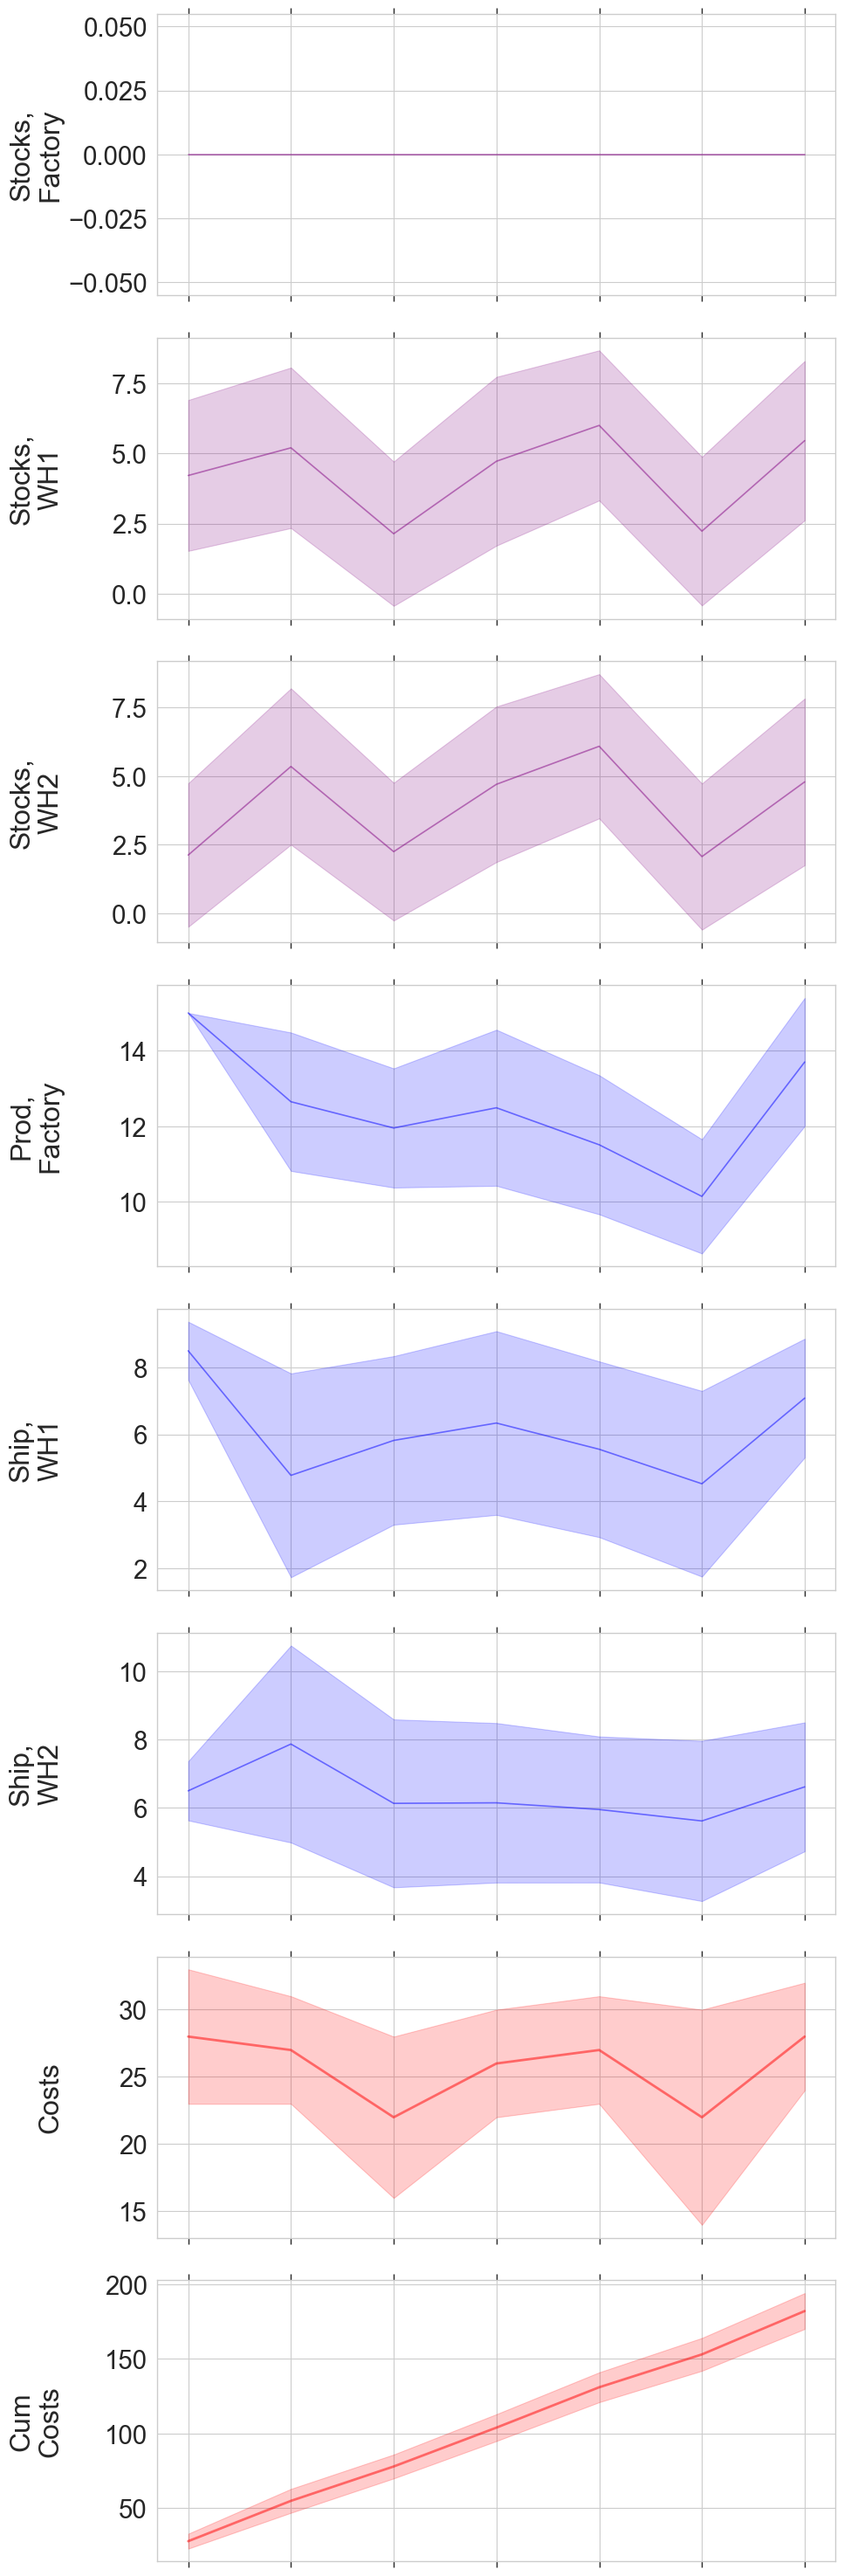

In [80]:
visualize_transitions(returns_trace_PPO, 'PPO')

In [81]:
# cumulative profit of the best PPO agent's policy
cum_profit_PPO = calculate_cum_profit(returns_trace_PPO)

reward: mean 182.21507953939587, std 12.498491431854385, max 225.37999953702092, min 158.3399995714426


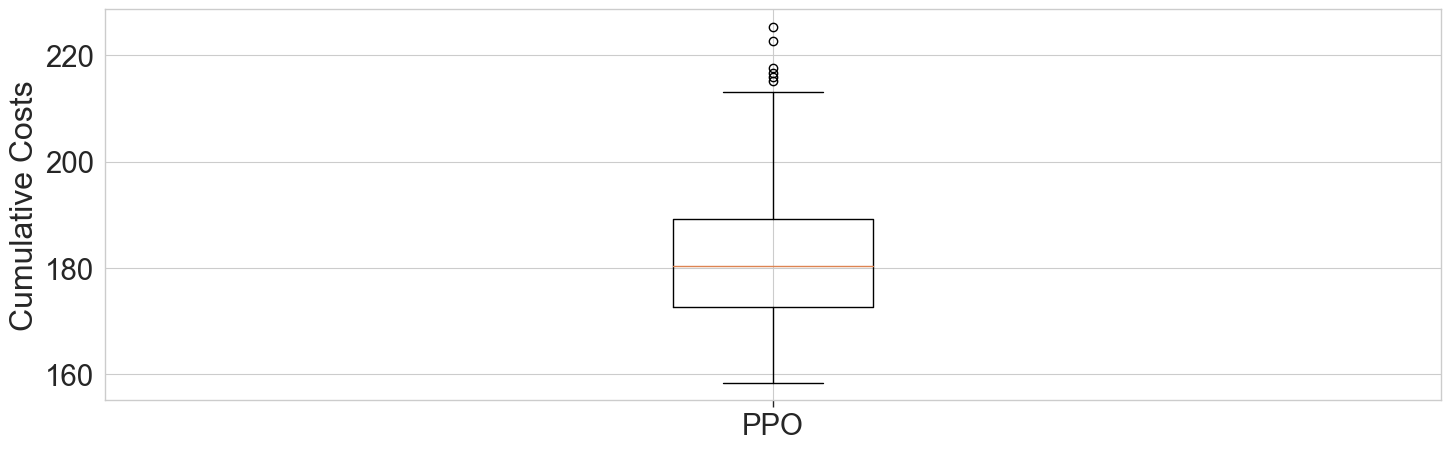

In [82]:
visualize_cum_profit(cum_profit_PPO, 'PPO')

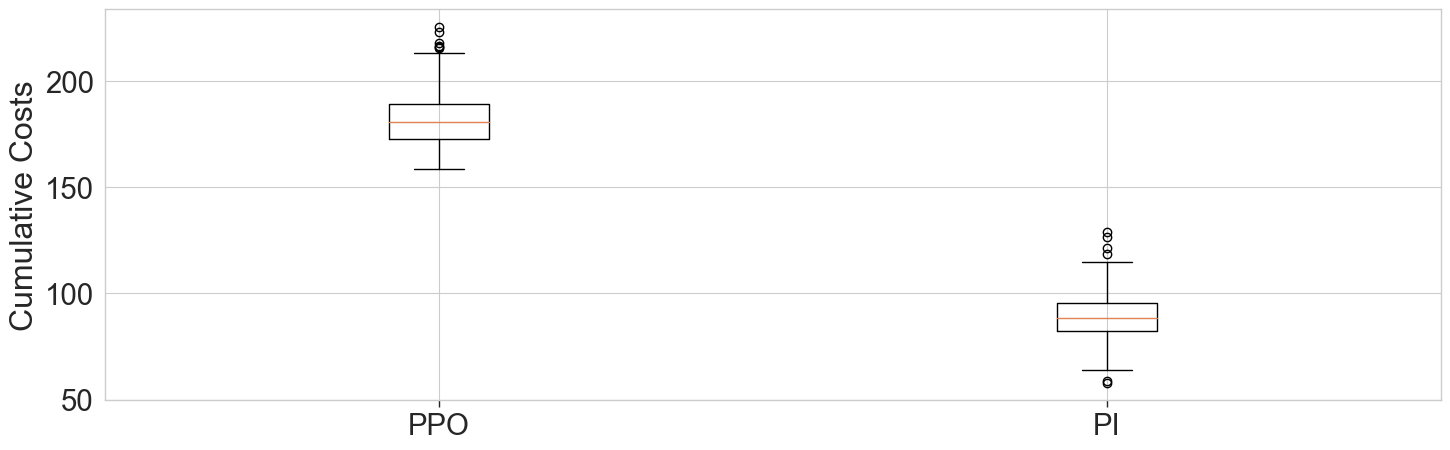

In [83]:
visualize_cum_profit([cum_profit_PPO,
                      cum_profit_ortools_det],
                     ['PPO',
                      'PI'])

In [84]:
save_object(returns_trace_PPO_full, 'transitions_full', 'PPO')
save_object(returns_trace_PPO, 'transitions', 'PPO')
save_object(cum_profit_PPO, 'cum_profit', 'PPO')

# Heuristic

## Parameters [Heuristic]

In [85]:
rolling_horizon = 2
bound_demands_scenario_1 = 0
bound_demands_scenario_2 = env.d_var[0]

## Scenario Tree [Heuristic]

In [86]:
class ScenarioTree(nx.DiGraph):
    def __init__(self, branching_factors, r=0,
                 bound_demands_1=bound_demands_scenario_1,
                 bound_demands_2=bound_demands_scenario_2):
        nx.DiGraph.__init__(self)

        self.initial_value = 0
        self.branching_factors = branching_factors
        self.tree_depth = len(self.branching_factors)
        self.scenarios_num = np.prod(self.branching_factors)

        # generating demands (Gurobi solver knows the episodes' demands
        # distribution a priori)
        stationary_demands = []
        stationary_demands.append(np.fromfunction(
            lambda j, i, t: env.stationary_demand(j+1, i+1, t+r),
            (env.distr_warehouses_num, env.product_types_num, env.T),
            dtype=np.int32))
        stationary_demands = np.array(stationary_demands[0]).tolist()

        # root node
        self.start_node = self.initial_value
        self.add_node(self.start_node,
                      obs=np.repeat(self.initial_value,
                                    env.distr_warehouses_num),
                      prob=1,
                      node_id=0,
                      step=0,
                      stage=0)
        last_nodes_added = [self.start_node]
        nodes_count = 1
        nodes_per_level_num = 1

        self.outcomes = [
            [bound_demands_1] * env.distr_warehouses_num,
            [bound_demands_2] * env.distr_warehouses_num,
            ]

        # tree nodes
        for t in range(self.tree_depth):
            next_stage = []
            nodes_per_level_num *= self.branching_factors[t]
            for node_parent in last_nodes_added:
                self.probs_scenario = 1 / self.branching_factors[t] 
                self.demands_scenario = [stationary_demands[j][0][t]
                                         for j in range(env.distr_warehouses_num)]
                for b in range(self.branching_factors[t]):
                    node_new_id = nodes_count
                    self.add_node(node_new_id,
                                  obs=[sum(x) for x in zip(self.demands_scenario,
                                                           self.outcomes[b])],
                                  prob=self.nodes[node_parent]['prob'] *
                                  self.probs_scenario,
                                  node_id=nodes_count,
                                  step=t+1,
                                  stage=t+1)
                    self.add_edge(node_parent, node_new_id)
                    next_stage.append(node_new_id)
                    nodes_count += 1
            last_nodes_added = next_stage
            self.nodes_num = nodes_count
        self.leaves = last_nodes_added

        print(f"\n{self.nodes()[i]}" for i in range(self.nodes_num))

        logger.debug(f"\n-- ScenarioTree -- __init__"
                     f"\nbranching_factors is "
                     f"{self.branching_factors}"
                     f"\ntree_depth is "
                     f"{self.tree_depth}"
                     f"\nscenarios_num is "
                     f"{self.scenarios_num}"
                     f"\ndemands_scenario is "
                     f"{self.demands_scenario}"
                     f"\nprobs_scenario is "
                     f"{self.probs_scenario}"
                     f"\nstart_node is "
                     f"{self.start_node}")

    def get_leaves(self):
        return self.leaves

    def plot(self, local_dir=local_dir, plots_dir=plots_dir):
        """Prints the tree."""
        try:
            pos = graphviz_layout(self, prog="dot")
            nx.draw(self, pos,
                    with_labels=True, arrows=True)

            # creating necessary subdir and saving plot
            if not os.path.exists(f"{local_dir}/{plots_dir}/MS"):
                os.makedirs(f"{local_dir}/{plots_dir}/MS")
            plt.savefig(f"{local_dir}/{plots_dir}/MS"
                        f"/plot_ScenarioTree.pdf",
                        format='pdf', bbox_inches='tight')
        except Exception as e:
            print(f"{e.__class__} occurred!")

## Parameters Methods [Heuristic]

In [87]:
def create_parameters_heuristic(env):
    """
    Transforms env parameters from numpy.array to lists.
    """
    # capacities (as lists)
    distr_w_capacities = env.storage_capacities.tolist()[1:]
    transportation_capacities = env.transportation_capacities.tolist()

    # costs (as lists)
    factory_storage_costs = env.storage_costs.tolist()[0]
    distr_w_storage_costs = env.storage_costs.tolist()[1:]

    transportation_costs_fixed = env.transportation_costs_fixed.tolist()
    transportation_costs_unit = env.transportation_costs_unit.tolist()

    sale_prices = env.sale_prices.tolist()
    penalty_costs = env.penalty_costs.tolist()

    logger.debug(f"\n-- Heuristic -- create_parameters_heuristic"
                 f"\ndistr_w_capacities is "
                 f"{distr_w_capacities}"
                 f"\ntransportation_capacities is "
                 f"{transportation_capacities}"
                 f"\nfactory_storage_costs is "
                 f"{factory_storage_costs}"
                 f"\ndistr_w_storage_costs is "
                 f"{distr_w_storage_costs}"
                 f"\ntransportation_costs_fixed is "
                 f"{transportation_costs_fixed}"
                 f"\ntransportation_costs_unit is "
                 f"{transportation_costs_unit}"
                 f"\nsale_prices is "
                 f"{sale_prices}"
                 f"\npenalty_costs is "
                 f"{penalty_costs}")

    return (distr_w_capacities,
            transportation_capacities,
            factory_storage_costs, distr_w_storage_costs,
            transportation_costs_fixed, transportation_costs_unit,
            sale_prices, penalty_costs)

## Decision Variables [Heuristic]

In [88]:
def decision_variables_heuristic(env, solver,
                                 scenario_tree):
    """
    Defines Heuristic decision variables for each warehouse (including factory)
    and for each product type.
    """
    # factory decision variables
    prod_level = solver.addVars(
        scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=env.prod_level_max[0],
        name='prod_level')
    stocks_factory = solver.addVars(
        scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_factory')

    # distr_w decision variables
    shipped_stocks = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='shipped_stocks')
    stocks_distr_w_pos = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_distr_w_pos')
    stocks_distr_w_neg = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='stocks_distr_w_neg')

    # transportation decision variables
    transportation_numbers = solver.addVars(
        env.distr_warehouses_num, scenario_tree.nodes_num,
        vtype=grb.GRB.CONTINUOUS,
        lb=0,
        ub=grb.GRB.INFINITY,
        name='transportation_numbers')

    logger.debug(f"\n-- Heuristic -- decision_variables_heuristic"
                 f"\nprod_level is "
                 f"{prod_level}"
                 f"\nstocks_factory is "
                 f"{stocks_factory}"
                 f"\nshipped_stocks is "
                 f"{shipped_stocks}"
                 f"\nstocks_distr_w_pos is "
                 f"{stocks_distr_w_pos}"
                 f"\nstocks_distr_w_neg is "
                 f"{stocks_distr_w_neg}"
                 f"\ntransportation_numbers is "
                 f"{transportation_numbers}")

    return (prod_level, stocks_factory,
            shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
            transportation_numbers)

## Constraints [Heuristic]

In [89]:
def constraints_heuristic(env, solver,
                          scenario_tree,
                          prod_level, stocks_factory,
                          shipped_stocks,
                          stocks_distr_w_pos, stocks_distr_w_neg,
                          transportation_numbers, transportation_capacities,
                          distr_w_capacities):
    """
    Defines Heuristic constraints for each warehouse (including factory) and
    for each product type.
    """
    # step 0 action (factory)
    action_heuristic = Action(
        env.product_types_num,
        env.distr_warehouses_num)
    constr_action_prod_level = solver.addConstr(
        prod_level[0] ==
        action_heuristic.production_level[0],
        name='action_prod_level_0')

    # step 0 (factory and warehouses)
    solver.addConstrs((
        stocks_factory[n] + prod_level[n] >=
        grb.quicksum(
            shipped_stocks[j, n]
            for j in range(env.distr_warehouses_num))
            for n in range(scenario_tree.nodes_num)),
        name='no_backlog_factory_stocks')
    solver.addConstrs(
        (stocks_distr_w_pos[j, n] + shipped_stocks[j, n] <=
         distr_w_capacities[j][0]
         for j in range(env.distr_warehouses_num)
         for n in range(scenario_tree.nodes_num)),
        name='distr_w_capacities')

    # step 0 state (factory and warehouses)
    state_heuristic = env.initial_state()
    constr_factory_stocks = solver.addConstr(
        stocks_factory[0] ==
        state_heuristic.factory_stocks[0],
        name='state_factory_stocks_0')
    constr_distr_warehouses_stocks = solver.addConstrs(
        (stocks_distr_w_pos[j, 0] - stocks_distr_w_neg[j, 0] ==
         state_heuristic.distr_warehouses_stocks[j]
         for j in range(env.distr_warehouses_num)),
        name='state_distr_warehouses_stocks_0')

    # steps > 0 (factory and warehouses)
    constr_scenario_tree = []
    for n in range(1, scenario_tree.nodes_num):
        parent = list(scenario_tree.predecessors(n))[0]
        solver.addConstr(
            stocks_factory[n] ==
            stocks_factory[parent] +
            prod_level[parent] -
            grb.quicksum(
                shipped_stocks[j, parent]
                for j in range(env.distr_warehouses_num)),
            name="factory_stocks")
        constr_scenario_tree.append(solver.addConstrs(
            (stocks_distr_w_pos[j, n] -
             stocks_distr_w_neg[j, n] ==
             stocks_distr_w_pos[j, parent] - stocks_distr_w_neg[j, parent] +
             shipped_stocks[j, parent] - scenario_tree.nodes()[n]['obs'][j]
             for j in range(env.distr_warehouses_num)),
            name="distr_warehouses_stocks"))

    solver.addConstrs(
        (shipped_stocks[j, n] <= transportation_numbers[j, n] *
         transportation_capacities[j][0]
         for j in range(env.distr_warehouses_num)
         for n in range(scenario_tree.nodes_num)),
        name='transportation_capacities')

    return (constr_factory_stocks, constr_distr_warehouses_stocks,
            constr_action_prod_level,
            constr_scenario_tree)

## Objective Function [Heuristic]

In [90]:
def obj_func_heuristic(env, scenario_tree,
                       stocks_factory,
                       factory_storage_costs,
                       stocks_distr_w_pos, stocks_distr_w_neg,
                       distr_w_storage_costs,
                       shipped_stocks, transportation_numbers,
                       transportation_costs_fixed, transportation_costs_unit,
                       penalty_costs):
    """
    Defines Gurobi objective function.
    """
    # transportation costs
    total_transportation_costs_fixed = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        transportation_costs_fixed[j][0] * transportation_numbers[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_transportation_costs_unit = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        transportation_costs_unit[j][0] * shipped_stocks[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_transportation_costs = total_transportation_costs_fixed + \
        total_transportation_costs_fixed

    # storage costs
    total_factory_storage_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        factory_storage_costs[0] * stocks_factory[n]
        for n in range(scenario_tree.nodes_num))
    total_distr_w_storage_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        distr_w_storage_costs[j][0] * stocks_distr_w_pos[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_storage_costs = total_factory_storage_costs + \
        total_distr_w_storage_costs

    # penalty costs
    total_distr_w_penalty_costs = grb.quicksum(
        scenario_tree.nodes()[n]['prob'] *
        penalty_costs[0] * stocks_distr_w_neg[j, n]
        for j in range(env.distr_warehouses_num)
        for n in range(scenario_tree.nodes_num))
    total_penalty_costs = total_distr_w_penalty_costs

    # reward
    reward = \
        total_transportation_costs + total_storage_costs + total_penalty_costs

    logger.debug(f"\n--- Gurobi --- objective_function_gurobi"
                 f"\ntotal_transportation_costs_fixed is "
                 f"{total_transportation_costs_fixed}"
                 f"\ntotal_transportation_costs_unit is "
                 f"{total_transportation_costs_unit}"
                 f"\ntotal_transportation_costs is "
                 f"{total_transportation_costs}"
                 f"\ntotal_storage_costs is "
                 f"{total_storage_costs}"
                 f"\ntotal_penalty_costs is "
                 f"{total_penalty_costs}"
                 f"\nreward is "
                 f"{reward}")

    return reward

## Simulator Methods [Heuristic]

In [91]:
def simulate_episode_heuristic(env, solver, policy,
                               prod_level, shipped_stocks,
                               stocks_distr_w_pos, stocks_distr_w_neg,
                               constr_factory_stocks,
                               constr_distr_warehouses_stocks,
                               constr_action_prod_level,
                               constr_scenario_tree,
                               rolling_horizon, seed):
    """
    Single episode simulator.
    """
    env.reset(seed)
    state = env.initial_state()
    transitions_full = []
    transitions = []

    logger.debug(f"\n-- simulate_episode_heuristic --"
                 f"\nstate is "
                 f"{state}"
                 f"\ntransitions_full is "
                 f"{transitions_full}"
                 f"\ntransitions is "
                 f"{transitions}")

    for t in range(env.T):
        # RLib action
        action = policy.compute_single_action(state.to_array(),
                                              normalize_actions=True,
                                              explore=False)[0].astype(
            np.int32)

        action_obj = Action(env.product_types_num,
                            env.distr_warehouses_num)
        action_obj.production_level = np.minimum(
            action[:env.product_types_num],
            env.prod_level_max)
        action_obj.shipped_stocks = action[
            env.product_types_num:
        ].reshape(env.distr_warehouses_num, env.product_types_num)

        # heuristic action
        action_heuristic = Action(env.product_types_num,
                                  env.distr_warehouses_num)
        action_heuristic.production_level = \
            np.minimum(
                action_obj.production_level,
                env.storage_capacities[0] - state.factory_stocks)

        # scenario tree
        scenario_tree = ScenarioTree(branching_factors=np.repeat(
            2, rolling_horizon),
            r=t)
        for i in range(env.product_types_num):
            constr_action_prod_level.rhs = \
                action_heuristic.production_level[i]
            constr_factory_stocks.rhs = state.factory_stocks[i]
        for j in range(env.distr_warehouses_num):
            for i in range(env.product_types_num):
                constr_distr_warehouses_stocks[j].rhs = \
                    state.distr_warehouses_stocks[j][i]

        for n in range(1, scenario_tree.nodes_num):
            parent = list(scenario_tree.predecessors(n))[0]
            solver.remove(constr_scenario_tree[n-1])
            constr_scenario_tree[n-1] = solver.addConstrs(
                (stocks_distr_w_pos[j, n] - stocks_distr_w_neg[j, n] ==
                 stocks_distr_w_pos[j, parent] -
                 stocks_distr_w_neg[j, parent] +
                 shipped_stocks[j, parent] - scenario_tree.nodes()[n]['obs'][j]
                 for j in range(env.distr_warehouses_num)),
                name="distr_warehouses_stocks")

        # updating the model
        solver.update()
        if not os.path.exists(f"{local_dir}/{plots_dir}/DRL-MS"):
            os.makedirs(f"{local_dir}/{plots_dir}/DRL-MS")
            solver.write(f"{local_dir}/{plots_dir}/DRL-MS"
                         f"/DRL-MS_{t}.lp")
        # solving the model
        solver.optimize()
        if solver.Status in (grb.GRB.INF_OR_UNBD,
                             grb.GRB.INFEASIBLE,
                             grb.GRB.UNBOUNDED):
            print(f"THE MODEL CANNOT BE SOLVED! ({solver.Status})")
        else:
            if solver.Status != grb.GRB.OPTIMAL:
                print(f"SOLUTION NON OPTIMAL! ({solver.Status})")
            else:
                print(f"SOLUTION OPTIMAL! ({solver.Status})")
            for j in range(state.distr_warehouses_num):
                for i in range(state.product_types_num):
                    action_heuristic.shipped_stocks[j][i] = \
                        shipped_stocks[j, 0].X

        state, reward, _ = env.step(state, action_heuristic)
        transitions_full.append(np.array(
            [state, action_heuristic, reward],
            dtype=object))
        if (t > env.lead_times_len-1 and t < env.T-env.lead_times_len):
            transitions.append(np.array(
                [state, action_heuristic, reward],
                dtype=object))

        logger.debug(f"\naction is "
                     f"{action}"
                     f"\naction_obj is "
                     f"{action_obj}"
                     f"\naction_obj.production_level is "
                     f"{action_obj.production_level}"
                     f"\naction_obj.shipped_stocks is "
                     f"{action_obj.shipped_stocks}"
                     f"\naction_heuristic is "
                     f"{action_heuristic}"
                     f"\naction_heuristic.production_level is "
                     f"{action_heuristic.production_level}"
                     f"\naction_heuristic.shipped_stocks is "
                     f"{action_heuristic.shipped_stocks}"
                     f"\nstate is "
                     f"{state}"
                     f"\nstate.factory_stocks is "
                     f"{state.factory_stocks}"
                     f"\nstate.distr_warehouses_stocks is "
                     f"{state.distr_warehouses_stocks}"
                     f"\nstate.demand_history is "
                     f"{state.demand_history}"
                     f"\nt is "
                     f"{t}"
                     f"\nreward is "
                     f"{reward}")

    logger.debug(f"\ntransitions_full [state, action, reward] is "
                 f"{transitions_full}"
                 f"\ntransitions [state, action, reward] is "
                 f"{transitions}")

    return [transitions_full, transitions]


def simulate_heuristic(env, solver, policy,
                       prod_level, shipped_stocks,
                       stocks_dist_w_pos, stocks_dist_w_neg,
                       constr_factory_stocks,
                       constr_distr_warehouses_stocks,
                       constr_action_prod_level,
                       constr_scenario_tree,
                       rolling_horizon,
                       num_episodes=1, seed=SEED):
    """
    Simulator.
    """
    returns_trace_full = []
    returns_trace = []
    time_heuristic = []

    for episode in range(num_episodes):
        seed = None
        if episode == 0:
            seed = seed

        start_heuristic = default_timer()
        rt_full, rt = simulate_episode_heuristic(
            env, solver, policy,
            prod_level, shipped_stocks,
            stocks_dist_w_pos, stocks_dist_w_neg,
            constr_factory_stocks,
            constr_distr_warehouses_stocks,
            constr_action_prod_level,
            constr_scenario_tree,
            rolling_horizon, seed)
        end_heuristic = default_timer()
        
        returns_trace_full.append(np.array(rt_full))
        returns_trace.append(np.array(rt))
        time_heuristic.append(end_heuristic-start_heuristic)

    logger.debug(f"\n-- simulate_heuristic --"
                 f"\nreturns_trace_full is "
                 f"{returns_trace_full}"
                 f"\nreturns_trace is "
                 f"{returns_trace}")

    return [returns_trace_full, returns_trace, time_heuristic]

# Heuristic Optimize

In [92]:
# initializing the scenario tree
scenario_tree = ScenarioTree(branching_factors=np.repeat(2, rolling_horizon))

<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB2F74148>


In [93]:
import sys
print(sys.path)
import gurobipy
print(gurobipy.__file__)

['d:\\Miniconda\\envs\\mlp_env\\lib\\site-packages\\ray\\thirdparty_files', 'd:\\Miniconda\\envs\\mlp_env\\lib\\site-packages\\ray\\pickle5_files', 'd:\\UoE\\Informatics\\Year4\\MLP\\Group Project\\source code\\Optimizing-Supply-Chain-Drcision-Through-Reinforcement-Learning\\SCIMAI-Gym-main', 'd:\\Miniconda\\envs\\mlp_env\\python37.zip', 'd:\\Miniconda\\envs\\mlp_env\\DLLs', 'd:\\Miniconda\\envs\\mlp_env\\lib', 'd:\\Miniconda\\envs\\mlp_env', '', 'C:\\Users\\28427\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\28427\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32', 'C:\\Users\\28427\\AppData\\Roaming\\Python\\Python37\\site-packages\\win32\\lib', 'C:\\Users\\28427\\AppData\\Roaming\\Python\\Python37\\site-packages\\Pythonwin', 'd:\\Miniconda\\envs\\mlp_env\\lib\\site-packages', 'd:\\Miniconda\\envs\\mlp_env\\lib\\site-packages\\win32', 'd:\\Miniconda\\envs\\mlp_env\\lib\\site-packages\\win32\\lib', 'd:\\Miniconda\\envs\\mlp_env\\lib\\site-packages\\Pythonwin

In [94]:
# heuristic solver (with multiple scenarios)
# https://www.gurobi.com/documentation/9.5/refman/multiple_scenarios.html
# https://www.gurobi.com/documentation/9.5/examples/multiscenario_py.html
solver_h = grb.Model('Heuristic_solver')
# setting the seed
solver_h.setParam('Seed', SEED)
# setting the time limit (in seconds)
solver_h.setParam('TimeLimit', 30)
# silencing the computation output
solver_h.setParam('OutputFlag', 0)
# updating the solver
solver_h.update()

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-26
Set parameter Seed to value 2023
Set parameter TimeLimit to value 30


In [95]:
# heuristic parameters
(distr_w_capacities_heuristic,
 transportation_capacities_heuristic,
 factory_storage_costs_heuristic, distr_w_storage_costs_heuristic,
 transportation_costs_fixed_heuristic, transportation_costs_unit_heuristic,
 sale_prices_heuristic, penalty_costs_heuristic) = create_parameters_heuristic(
    env)

In [96]:
# heuristic decision variables
(prod_level, stocks_factory,
 shipped_stocks, stocks_distr_w_pos, stocks_distr_w_neg,
 transportation_numbers) = decision_variables_heuristic(env, solver_h,
                                                        scenario_tree)

In [97]:
# heuristic constraints
(constr_factory_stocks, constr_distr_warehouses_stocks,
 constr_action_prod_level, constr_scenario_tree) = constraints_heuristic(
    env, solver_h,
    scenario_tree,
    prod_level, stocks_factory,
    shipped_stocks,
    stocks_distr_w_pos, stocks_distr_w_neg,
    transportation_numbers, transportation_capacities_heuristic,
    distr_w_capacities_heuristic)

In [98]:
# reward
reward = obj_func_heuristic(env, scenario_tree,
                            stocks_factory,
                            factory_storage_costs_heuristic,
                            stocks_distr_w_pos, stocks_distr_w_neg,
                            distr_w_storage_costs_heuristic,
                            shipped_stocks, transportation_numbers,
                            transportation_costs_fixed_heuristic,
                            transportation_costs_unit_heuristic,
                            penalty_costs_heuristic)

In [99]:
# setting the objective function
solver_h.setObjective(reward, grb.GRB.MINIMIZE)
# updating the solver
solver_h.update()
# optimizing the solver
solver_h.optimize()

In [203]:
print(f"number of variables is {len(solver_h.getVars())}")
print(f"number of constraints is {len(solver_h.getConstrs())}")

number of variables is 70
number of constraints is 57


In [100]:
# evaluating the best heuristic agent's policy
np.random.seed(SEED)
env.reset(SEED)
(returns_trace_heuristic_full, returns_trace_heuristic,
 time_heuristic) = simulate_heuristic(env, solver_h, policy_PPO,
                                      prod_level, shipped_stocks,
                                      stocks_distr_w_pos, stocks_distr_w_neg,
                                      constr_factory_stocks,
                                      constr_distr_warehouses_stocks,
                                      constr_action_prod_level,
                                      constr_scenario_tree,
                                      rolling_horizon,
                                      NUM_EPISODES)

<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EABC22A48>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x0000015EB36C3448>
SOLUTION OPTIMAL! (2)
<generator object ScenarioTree.__init__.<locals>.<genexpr> at 0x

In [101]:
# calculating and printing the heuristic testing time
time_heuristic_total_testing = np.round((np.sum(time_heuristic)), 6)
time_heuristic_mean_testing = np.round((np.mean(time_heuristic)), 6)
time_heuristic_std_testing = np.round((np.std(time_heuristic)), 6)
print(f"total testing time heuristic (in seconds) is {time_heuristic_total_testing}")
print(f"mean testing time heuristic (in seconds) is {time_heuristic_mean_testing}")
print(f"std testing time heuristic (in seconds) is {time_heuristic_std_testing}")

total testing time heuristic (in seconds) is 10.034453
mean testing time heuristic (in seconds) is 0.040138
std testing time heuristic (in seconds) is 0.003669


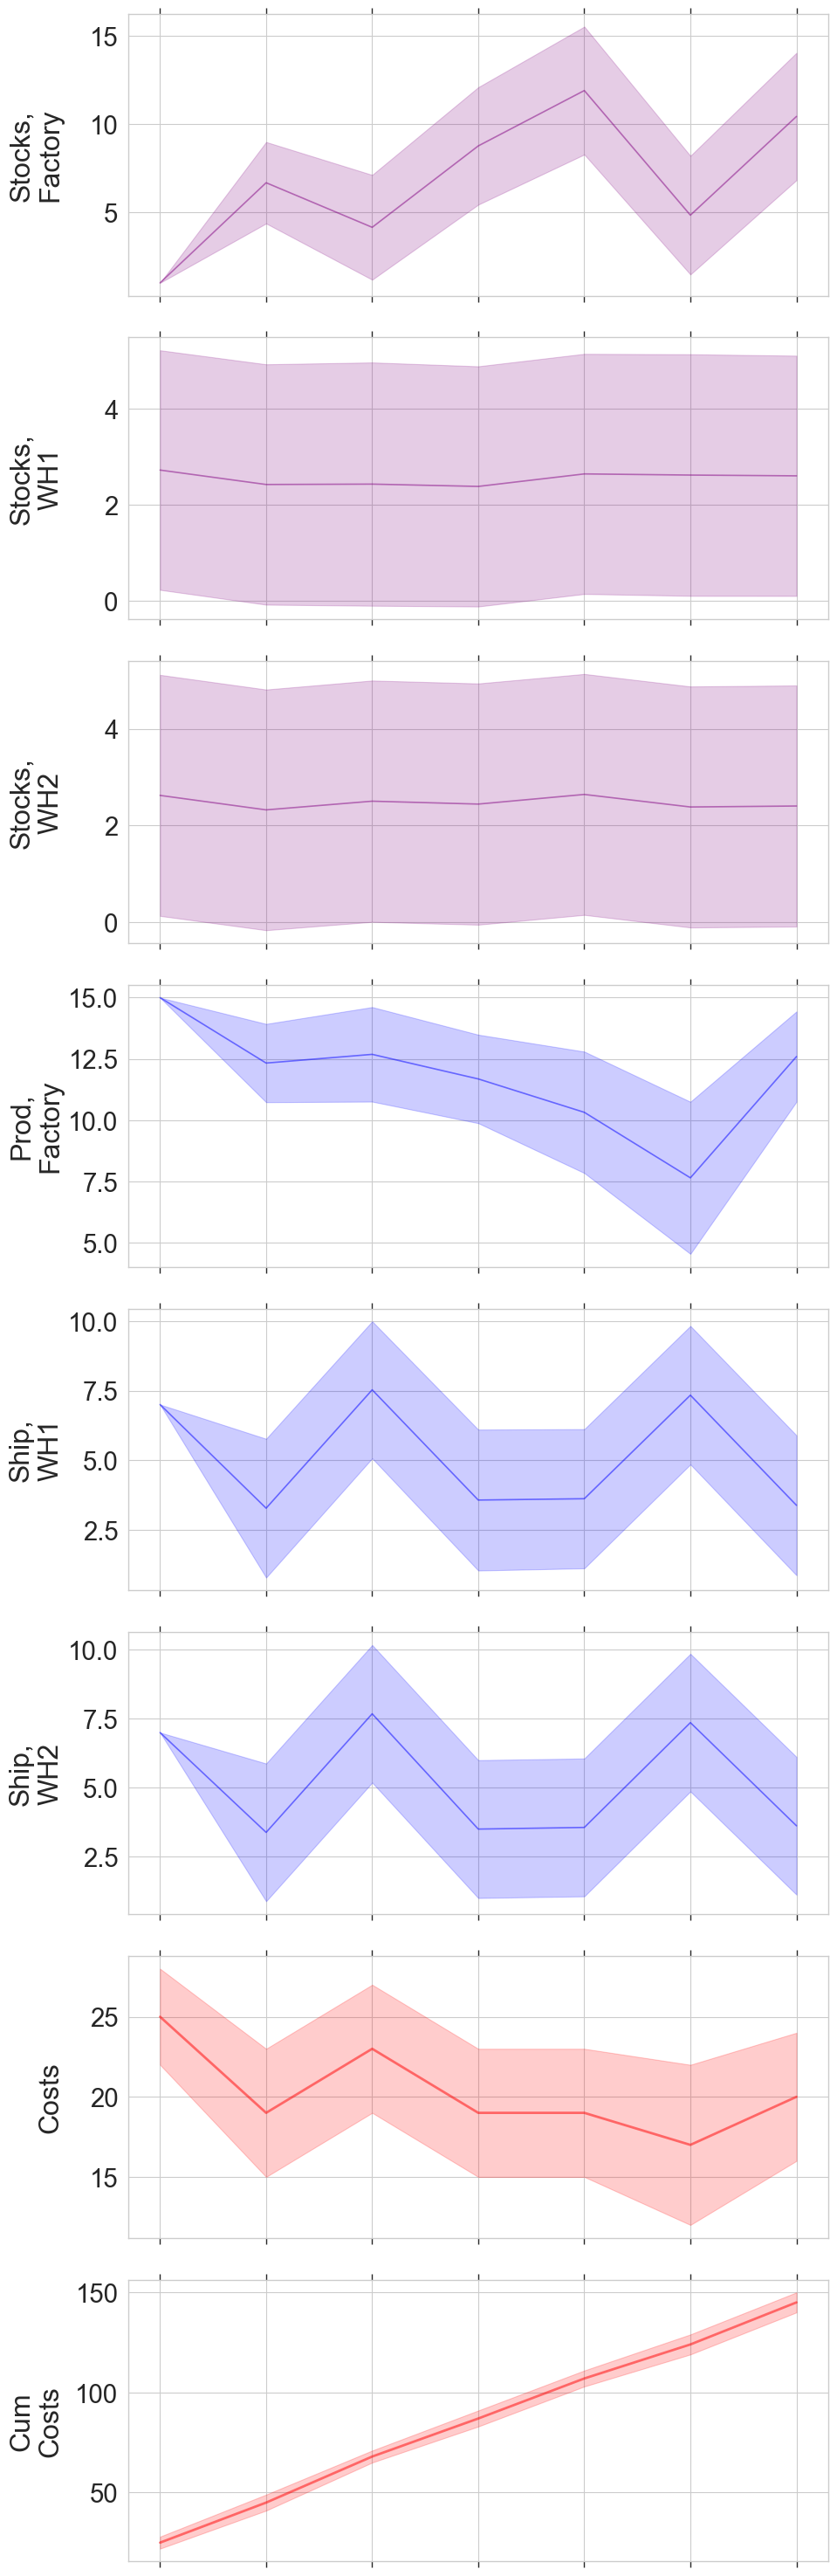

In [102]:
visualize_transitions(returns_trace_heuristic, 'DRL-MS')

In [103]:
# cumulative profit of the heuristic policy
cum_profit_heuristic = calculate_cum_profit(returns_trace_heuristic)

reward: mean 145.75779966596514, std 5.409079888961255, max 163.65999959781766, min 134.30999957956374


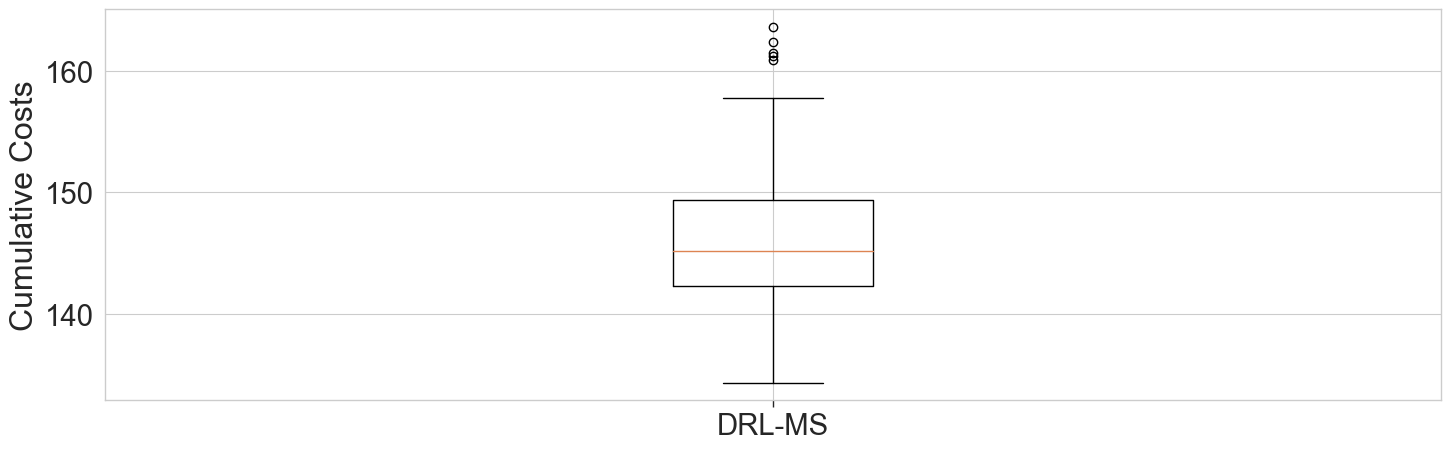

In [104]:
visualize_cum_profit(cum_profit_heuristic, 'DRL-MS')

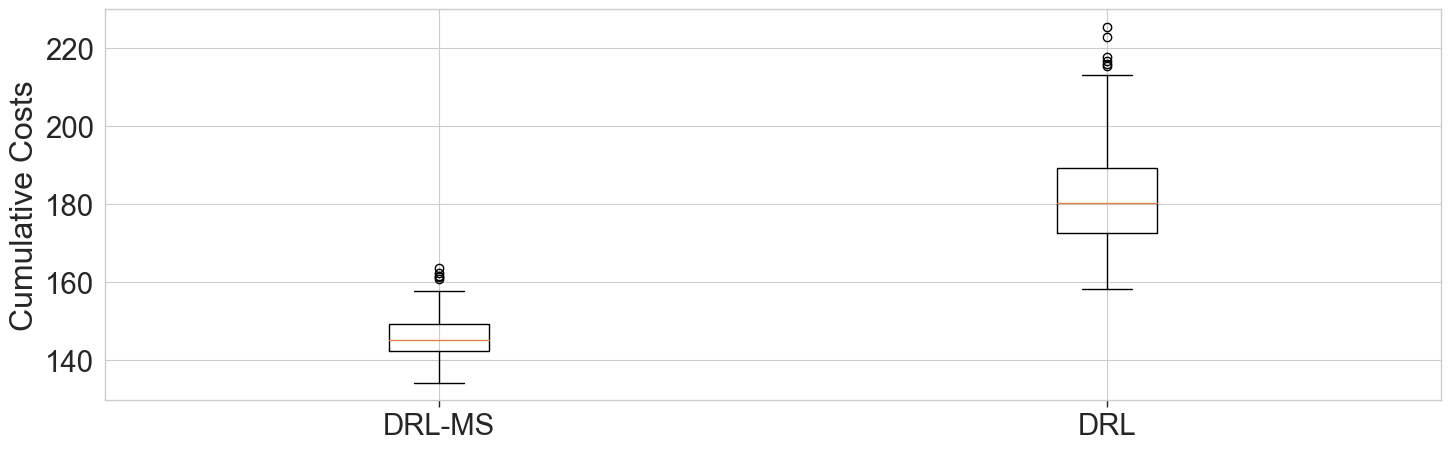

In [105]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_PPO],
                     ['DRL-MS',
                      'DRL'])

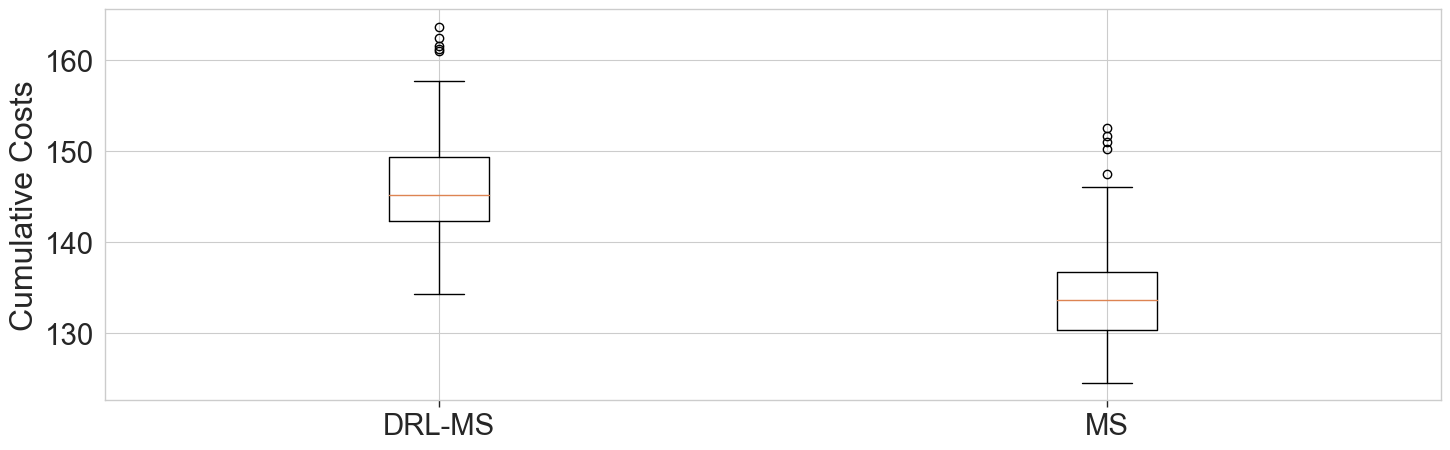

In [125]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_gurobi],
                     ['DRL-MS',
                      'MS'])

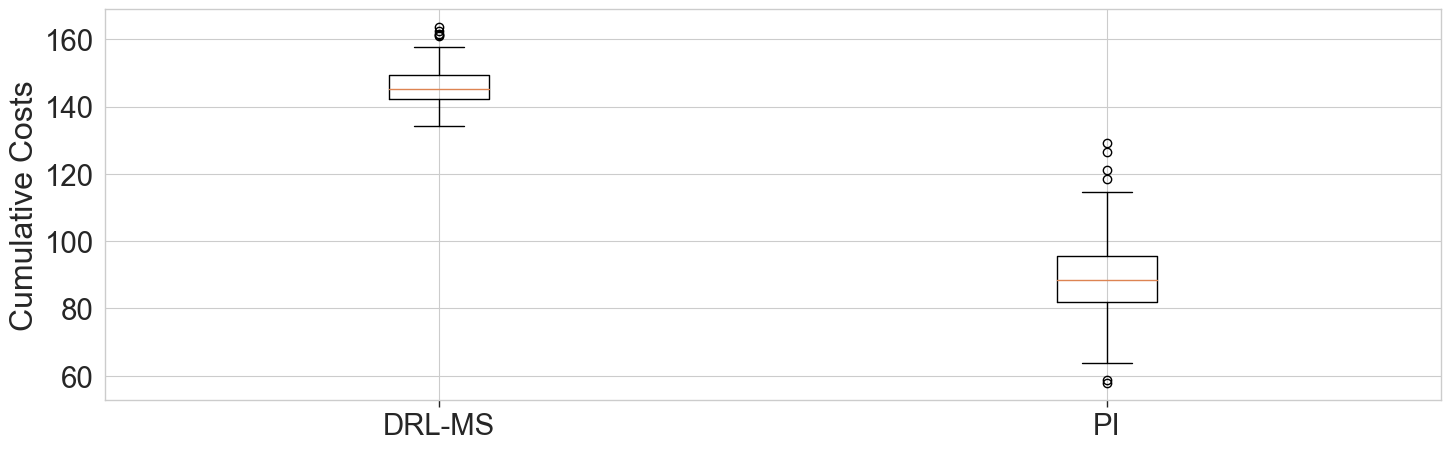

In [107]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_ortools_det],
                     ['DRL-MS',
                      'PI'])

In [ ]:
save_object(returns_trace_heuristic_full, 'transitions_full', 'DRL-MS')
save_object(returns_trace_heuristic, 'transitions', 'DRL-MS')
save_object(cum_profit_heuristic, 'cum_profit', 'DRL-MS')

# Final Results

## Cumulative Profit

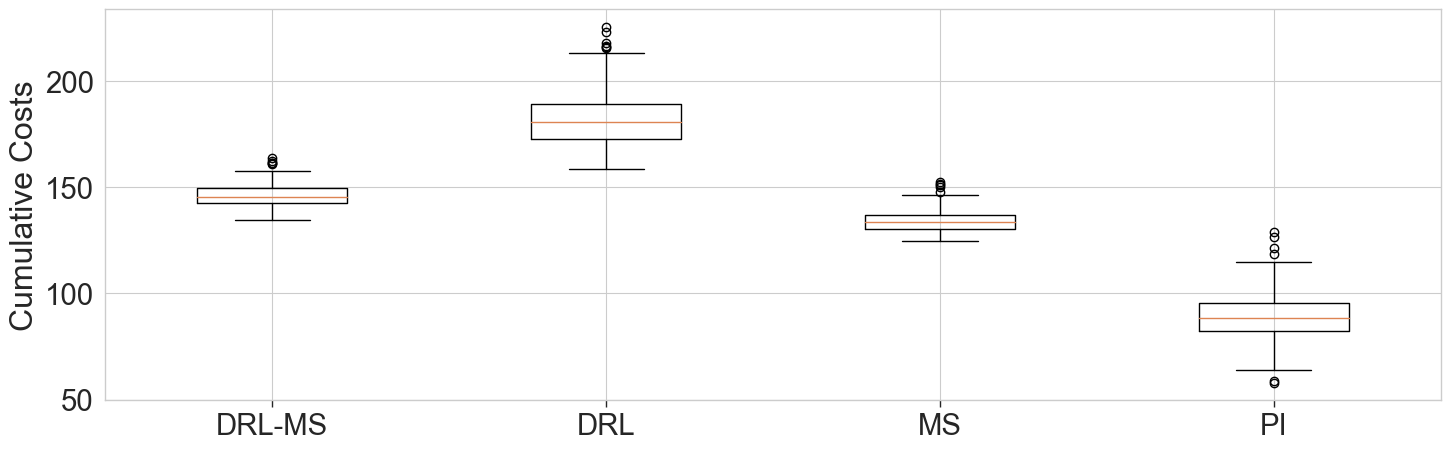

In [126]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_PPO,
                      cum_profit_gurobi,
                      cum_profit_ortools_det],
                     ['DRL-MS',
                      'DRL',
                      'MS',
                      'PI'])

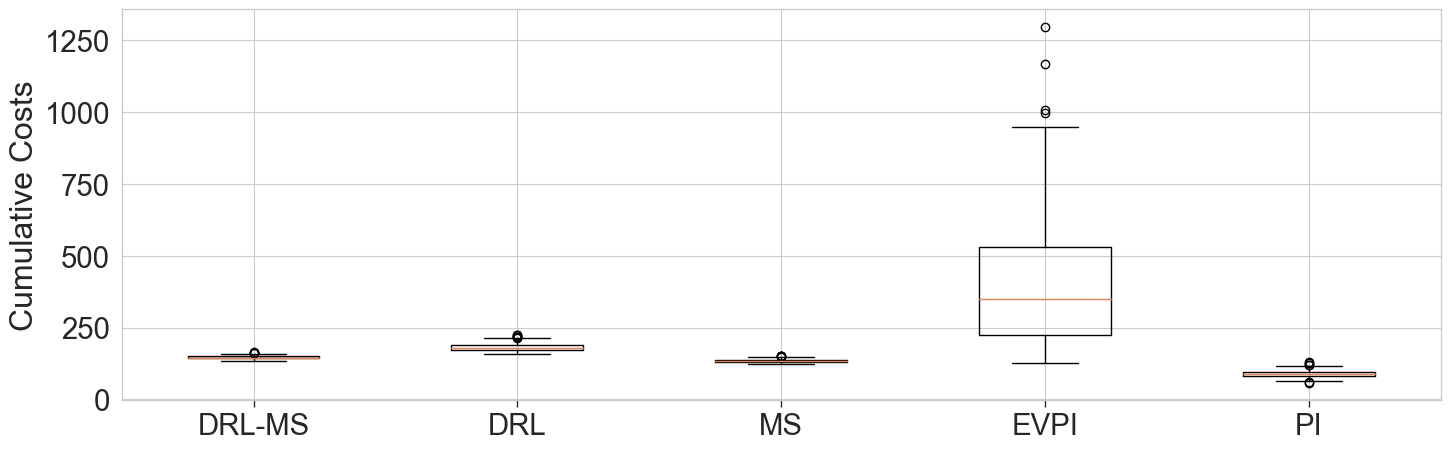

In [127]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_PPO,
                      cum_profit_gurobi,
                      cum_profit_ortools,
                      cum_profit_ortools_det],
                     ['DRL-MS',
                      'DRL',
                      'MS',
                      'EVPI',
                      'PI'])

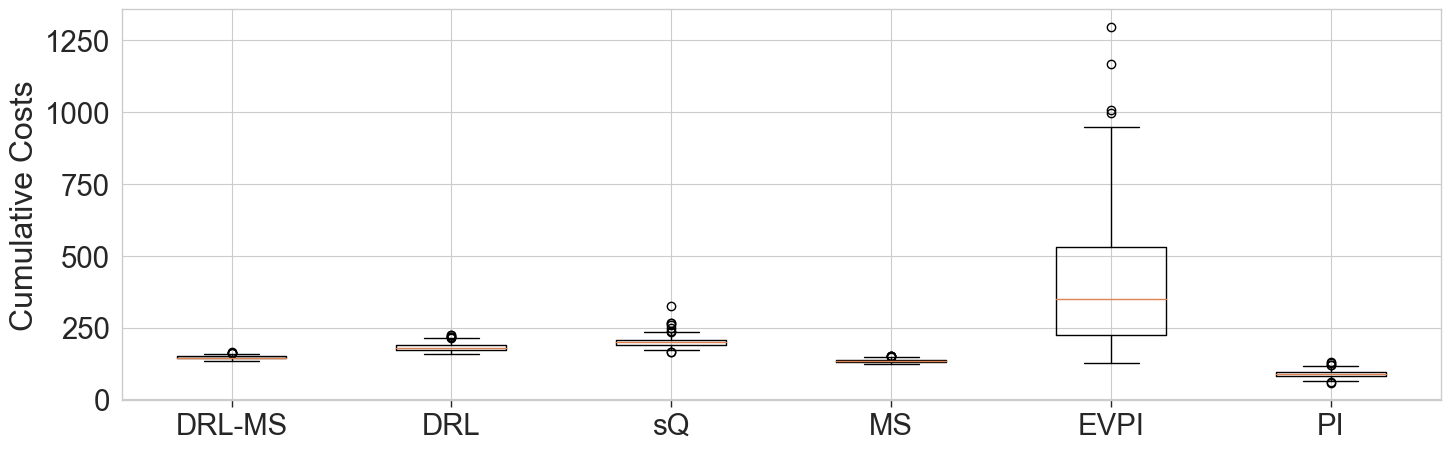

In [151]:
visualize_cum_profit([cum_profit_heuristic,
                      cum_profit_PPO,
                      best_cum_profit_sQ,
                      cum_profit_gurobi,
                      cum_profit_ortools,
                      cum_profit_ortools_det],
                     ['DRL-MS',
                      'DRL',
                      'sQ',
                      'MS',
                      'EVPI',
                      'PI'])

In [152]:
# cumulative profit of all policies
cum_profit_total = {
    'Algorithm':
    ['DRL-MS',
     'DRL',
     'sQ',
     'MS',
     'EVPI',
     'PI'],
    'Cumulative Costs':
    [f"{int(np.round(np.mean(cum_profit_heuristic), 0))}"
     f" +- {int(np.round(np.std(cum_profit_heuristic), 0))}",
     f"{int(np.round(np.mean(cum_profit_PPO), 0))}"
     f" +- {int(np.round(np.std(cum_profit_PPO), 0))}",
     f"{int(np.round(np.mean(best_cum_profit_sQ), 0))}"
     f" +- {int(np.round(np.std(best_cum_profit_sQ), 0))}",
     f"{int(np.round(np.mean(cum_profit_gurobi), 0))}"
     f" +- {int(np.round(np.std(cum_profit_gurobi), 0))}",
     f"{int(np.round(np.mean(cum_profit_ortools), 0))}"
     f" +- {int(np.round(np.std(cum_profit_ortools), 0))}",
     f"{int(np.round(np.mean(cum_profit_ortools_det), 0))}"
     f" +- {int(np.round(np.std(cum_profit_ortools_det), 0))}"]
}
# creating pandas DataFrame
cum_profit_total_df = pd.DataFrame(data=cum_profit_total)
cum_profit_total_df.set_index('Algorithm', inplace=True)
# saving pandas DataFrame as an image
dfi.export(cum_profit_total_df,
           f"{local_dir}/{plots_dir}"
           f"/cum_profit_total_df.png",
           table_conversion='matplotlib')
# saving pandas DataFrame as LaTeX table
f = open(f"{local_dir}/{plots_dir}"
         f"/cum_profit_total_df.tex",
         'w', encoding='utf-8')
f.write(cum_profit_total_df.style.to_latex())
f.close()
# printing training time of all policies
print(tabulate(cum_profit_total_df, headers='keys', tablefmt='grid'))

+-------------+--------------------+
| Algorithm   | Cumulative Costs   |
+=============+====================+
| DRL-MS      | 146 +- 5           |
+-------------+--------------------+
| DRL         | 182 +- 12          |
+-------------+--------------------+
| sQ          | 200 +- 17          |
+-------------+--------------------+
| MS          | 134 +- 5           |
+-------------+--------------------+
| EVPI        | 402 +- 222         |
+-------------+--------------------+
| PI          | 89 +- 12           |
+-------------+--------------------+


In [153]:
# optimality gap of all policies (with respect to the Gurobi policy)
cum_profit_heuristic = np.array(cum_profit_heuristic)
cum_profit_PPO = np.array(cum_profit_PPO)
best_cum_profit_sQ = np.array(best_cum_profit_sQ)
cum_profit_gurobi = np.array(cum_profit_gurobi)
cum_profit_ortools = np.array(cum_profit_ortools)
cum_profit_ortools_det = np.array(cum_profit_ortools_det)

gap_heuristic = (
    (cum_profit_heuristic - cum_profit_gurobi) / cum_profit_gurobi) * 100
gap_PPO = (
    (cum_profit_PPO - cum_profit_gurobi) / cum_profit_gurobi) * 100
gap_sQ = (
    (best_cum_profit_sQ - cum_profit_gurobi) / cum_profit_gurobi) * 100
gap_gurobi = (
    (cum_profit_gurobi - cum_profit_gurobi) / cum_profit_gurobi) * 100
gap_ortools = (
    (cum_profit_ortools - cum_profit_gurobi) / cum_profit_gurobi) * 100
gap_ortools_det = (
    (cum_profit_ortools_det - cum_profit_gurobi) / cum_profit_gurobi) * 100

gurobi_gap = {
    'Algorithm':
    ['DRL-MS',
     'DRL',
     'sQ',
     'MS',
     'EVPI',
     'PI'],
    'MS Gap':
    [f"{np.round(np.mean(gap_heuristic), 2)}"
     f" +- {np.round(np.std(gap_heuristic), 2)}",
     f"{np.round(np.mean(gap_PPO), 2)}"
     f" +- {np.round(np.std(gap_PPO), 2)}",
     f"{np.round(np.mean(gap_sQ), 2)}"
     f" +- {np.round(np.std(gap_sQ), 2)}",
     f"{np.round(np.mean(gap_gurobi), 2)}"
     f" +- {np.round(np.std(gap_gurobi), 2)}",
     f"{np.round(np.mean(gap_ortools), 2)}"
     f" +- {np.round(np.std(gap_ortools), 2)}",
     f"{np.round(np.mean(gap_ortools_det), 2)}"
     f" +- {np.round(np.std(gap_ortools_det), 2)}"]
}
# creating pandas DataFrame
gurobi_gap_df = pd.DataFrame(data=gurobi_gap)
gurobi_gap_df.set_index('Algorithm', inplace=True)
# saving pandas DataFrame as an image
dfi.export(gurobi_gap_df,
           f"{local_dir}/{plots_dir}"
           f"/gurobi_gap_df.png",
           table_conversion='matplotlib')
# saving pandas DataFrame as LaTeX table
f = open(f"{local_dir}/{plots_dir}"
         f"/gurobi_gap_df.tex",
         'w', encoding='utf-8')
f.write(gurobi_gap_df.style.to_latex())
f.close()
# printing training time of all policies
print(tabulate(gurobi_gap_df, headers='keys', tablefmt='grid'))

+-------------+-----------------+
| Algorithm   | MS Gap          |
+=============+=================+
| DRL-MS      | 8.87 +- 3.44    |
+-------------+-----------------+
| DRL         | 36.11 +- 8.94   |
+-------------+-----------------+
| sQ          | 49.79 +- 12.81  |
+-------------+-----------------+
| MS          | 0.0 +- 0.0      |
+-------------+-----------------+
| EVPI        | 198.62 +- 159.8 |
+-------------+-----------------+
| PI          | -33.63 +- 8.85  |
+-------------+-----------------+


In [154]:
def visualize_hist_costs(cum_profit_PPO, cum_profit_heuristic,
                   local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize an histogram between the PPO and heuristic gaps.
    """
    plt.figure(figsize=(8, 5))
    plt.ylabel('Frequency')
    plt.xlabel('Total Costs [k€]')

    plt.tight_layout()

    # plotting plot
    plt.hist(cum_profit_PPO, bins=22,
             color='blue', alpha=.5, histtype='bar', label='PPO')
    plt.hist(cum_profit_heuristic, bins=8,
             color='green', alpha=.5, histtype='bar', label='DRLBD')

    # plotting legend
    plt.legend()

    # saving plot
    plt.savefig(f"{local_dir}/{plots_dir}"
                f"/gurobi_gap_hist_costs.pdf",
                format='pdf', bbox_inches='tight')

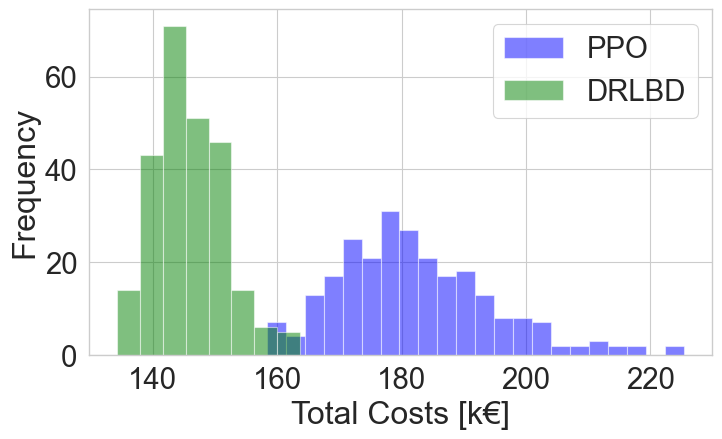

In [155]:
visualize_hist_costs(cum_profit_PPO, cum_profit_heuristic)

In [156]:
def visualize_hist_gap(gap_PPO, gap_heuristic,
                   local_dir=local_dir, plots_dir=plots_dir):
    """
    Visualize an histogram between the PPO and heuristic gaps.
    """
    plt.figure(figsize=(8, 5))
    plt.ylabel('Frequency')
    plt.xlabel('Opt-gap [%]')

    plt.tight_layout()

    # plotting plot
    plt.hist(gap_PPO, bins=20,
             color='blue', alpha=.5, histtype='bar', label='PPO')
    plt.hist(gap_heuristic, bins=15,
             color='green', alpha=.5, histtype='bar', label='DRLBD')

    # plotting legend
    plt.legend()

    # saving plot
    plt.savefig(f"{local_dir}/{plots_dir}"
                f"/gurobi_gap_hist_gap.pdf",
                format='pdf', bbox_inches='tight')

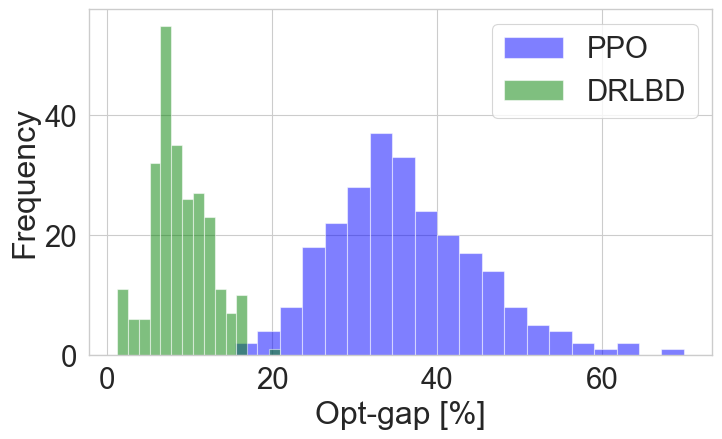

In [157]:
visualize_hist_gap(gap_PPO, gap_heuristic)

In [158]:
def compare_arrays(arr1, arr2):
    count = 0
    indices = []
    # Assume arr1 and arr2 have the same length
    for i in range(len(arr1)):
        if arr1[i] > arr2[i]:
            count += 1
            indices.append(i)
    return count, indices

In [159]:
compare_arrays(cum_profit_ortools_det, cum_profit_ortools)

(0, [])

In [160]:
compare_arrays(cum_profit_ortools_det, best_cum_profit_sQ)

(0, [])

In [161]:
compare_arrays(cum_profit_ortools_det, cum_profit_PPO)

(0, [])

In [162]:
compare_arrays(cum_profit_ortools_det, cum_profit_heuristic)

(0, [])

In [163]:
compare_arrays(cum_profit_gurobi, cum_profit_ortools)

(2, [218, 246])

In [164]:
compare_arrays(cum_profit_gurobi, best_cum_profit_sQ)

(0, [])

In [165]:
compare_arrays(cum_profit_gurobi, cum_profit_PPO)

(0, [])

In [166]:
compare_arrays(cum_profit_gurobi, cum_profit_heuristic)

(0, [])

In [167]:
# optimality gap of all policies (with respect to the ortools policy)
cum_profit_heuristic = np.array(cum_profit_heuristic)
cum_profit_PPO = np.array(cum_profit_PPO)
best_cum_profit_sQ = np.array(best_cum_profit_sQ)
cum_profit_gurobi = np.array(cum_profit_gurobi)
cum_profit_ortools = np.array(cum_profit_ortools)
cum_profit_ortools_det = np.array(cum_profit_ortools_det)

gap_heuristic = (
    (cum_profit_heuristic - cum_profit_ortools_det) / cum_profit_ortools_det) * 100
gap_PPO = (
    (cum_profit_PPO - cum_profit_ortools_det) / cum_profit_ortools_det) * 100
gap_sQ = (
    (best_cum_profit_sQ - cum_profit_ortools_det) / cum_profit_ortools_det) * 100
gap_gurobi = (
    (cum_profit_gurobi - cum_profit_ortools_det) / cum_profit_ortools_det) * 100
gap_ortools = (
    (cum_profit_ortools - cum_profit_ortools_det) / cum_profit_ortools_det) * 100
gap_ortools_det = (
    (cum_profit_ortools_det - cum_profit_ortools_det) / cum_profit_ortools_det) * 100

ortools_det_gap = {
    'Algorithm':
    ['DRL-MS',
     'DRL',
     'sQ',
     'MS',
     'EVPI',
     'PI'],
    'PI Gap':
    [f"{np.round(np.mean(gap_heuristic), 2)}"
     f" +- {np.round(np.std(gap_heuristic), 2)}",
     f"{np.round(np.mean(gap_PPO), 2)}"
     f" +- {np.round(np.std(gap_PPO), 2)}",
     f"{np.round(np.mean(gap_sQ), 2)}"
     f" +- {np.round(np.std(gap_sQ), 2)}",
     f"{np.round(np.mean(gap_gurobi), 2)}"
     f" +- {np.round(np.std(gap_gurobi), 2)}",
     f"{np.round(np.mean(gap_ortools), 2)}"
     f" +- {np.round(np.std(gap_ortools), 2)}",
     f"{np.round(np.mean(gap_ortools_det), 2)}"
     f" +- {np.round(np.std(gap_ortools_det), 2)}"]
}
# creating pandas DataFrame
ortools_det_gap_df = pd.DataFrame(data=ortools_det_gap)
ortools_det_gap_df.set_index('Algorithm', inplace=True)
# saving pandas DataFrame as an image
dfi.export(ortools_det_gap_df,
           f"{local_dir}/{plots_dir}"
           f"/ortools_det_gap_df.png",
           table_conversion='matplotlib')
# saving pandas DataFrame as LaTeX table
f = open(f"{local_dir}/{plots_dir}"
         f"/ortools_det_gap_df.tex",
         'w', encoding='utf-8')
f.write(ortools_det_gap_df.style.to_latex())
f.close()
# printing training time of all policies
print(tabulate(ortools_det_gap_df, headers='keys', tablefmt='grid'))

+-------------+------------------+
| Algorithm   | PI Gap           |
+=============+==================+
| DRL-MS      | 67.55 +- 27.28   |
+-------------+------------------+
| DRL         | 109.35 +- 35.78  |
+-------------+------------------+
| sQ          | 130.31 +- 40.34  |
+-------------+------------------+
| MS          | 53.51 +- 21.69   |
+-------------+------------------+
| EVPI        | 334.92 +- 191.01 |
+-------------+------------------+
| PI          | 0.0 +- 0.0       |
+-------------+------------------+


In [168]:
def move_dir_plots(local_dir=local_dir, plots_dir=plots_dir):
    """
    Move dirs whose name starts with 'BS_' (related to all optimizations) in
    the main BS dir.
    """
    try:
        # creating necessary subdir and saving plot
        if not os.path.exists(f"{local_dir}/{plots_dir}/cum_profit"):
            os.makedirs(f"{local_dir}/{plots_dir}/cum_profit")
        src_dir = f"{local_dir}/{plots_dir}/"
        dst_dir = f"{local_dir}/{plots_dir}/cum_profit"

        pattern = src_dir + "['*"
        for file in glob.iglob(pattern, recursive=True):
            shutil.move(file, dst_dir)
            print('moved:', file)
    except Exception as e:
        print(f"{e.__class__} occurred!")

In [169]:
move_dir_plots()

moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'DRL', 'MS', 'EVPI', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'DRL', 'MS', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'DRL', 'sQ', 'MS', 'EVPI', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'DRL']
moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'MS']
moved: 1P2W_2025-03-26_20-02-47/plots\['DRL-MS', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['EVPI', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['MS', 'EVPI', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['MS', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['PPO', 'PI']
moved: 1P2W_2025-03-26_20-02-47/plots\['sQ', 'PI']


## Training Time

In [170]:
# training time of all policies
times_training_total = {'Algorithm':
               ['DRL-MS',
                'DRL',
                'sQ',
                'MS',
                'EVPI',
                'PI'],
               f"Training Time":
                [f"{time_PPO_total_training} (in minutes)",
                f"{time_PPO_total_training} (in minutes)",
                f"{time_sQ_total_training} (in minutes)",
                f"-",
                f"{time_ortools_total_training} (in seconds)",
                f"-"],
               f"Testing Time ({NUM_EPISODES} Episodes)":
                [f"{time_heuristic_total_testing} (in seconds)",
                f"{time_PPO_total_testing} (in seconds)",
                f"{time_sQ_total_testing} (in seconds)",
                f"{time_gurobi_total_training} (in seconds)",
                f"{time_ortools_total_testing} (in seconds)",
                f"{time_ortools_det_total_training} (in seconds)"],
               f"Testing Time (Mean +- Std)":
                [f"{time_heuristic_mean_testing} +- {time_heuristic_std_testing} (in seconds)",
                f"{time_PPO_mean_testing} +- {time_PPO_std_testing} (in seconds)",
                f"{time_sQ_mean_testing} +- {time_sQ_std_testing} (in seconds)",
                f"{time_gurobi_mean_training} +- {time_gurobi_std_training} (in seconds)",
                f"{time_ortools_mean_testing} +- {time_ortools_std_testing} (in seconds)",
                f"{time_ortools_det_mean_training} +- {time_ortools_det_std_training} (in seconds)"]}
# creating pandas DataFrame
times_training_total_df = pd.DataFrame(data=times_training_total)
times_training_total_df.set_index('Algorithm', inplace=True)
# saving pandas DataFrame as an image
dfi.export(times_training_total_df,
           f"{local_dir}/{plots_dir}"
           f"/times_training_total_df.png",
           table_conversion='matplotlib')
# saving pandas DataFrame as LaTeX table
f = open(f"{local_dir}/{plots_dir}"
         f"/times_training_total_df.tex",
         'w', encoding='utf-8')
f.write(times_training_total_df.style.to_latex())
f.close()
# printing training time of all policies
print(tabulate(times_training_total_df, headers='keys', tablefmt='grid'))

+-------------+------------------------+-------------------------------+-----------------------------------+
| Algorithm   | Training Time          | Testing Time (250 Episodes)   | Testing Time (Mean +- Std)        |
+=============+========================+===============================+===================================+
| DRL-MS      | 11.329831 (in minutes) | 10.034453 (in seconds)        | 0.040138 +- 0.003669 (in seconds) |
+-------------+------------------------+-------------------------------+-----------------------------------+
| DRL         | 11.329831 (in minutes) | 8.016422 (in seconds)         | 0.032066 +- 0.004072 (in seconds) |
+-------------+------------------------+-------------------------------+-----------------------------------+
| sQ          | 8.18642 (in minutes)   | 4.713993 (in seconds)         | 0.018856 +- 0.002652 (in seconds) |
+-------------+------------------------+-------------------------------+-----------------------------------+
| MS          | -  

# Compress Final Results

In [171]:
# creating a tar file containing plots and Ray results
try:
    cmd = f"tar -zcvf {local_dir}.tar.gz ./{local_dir}"
    print(f"cmd is {cmd}")
    os.system(cmd)
except Exception as e:
    print(f"{e.__class__} occurred!")

cmd is tar -zcvf 1P2W_2025-03-26_20-02-47.tar.gz ./1P2W_2025-03-26_20-02-47


# TensorBoard

In [172]:
# checking if PPO best checkpoint is defined
try:
    best_checkpoint_PPO
except Exception as e:
    print(f"{e.__class__} occurred!")
    best_checkpoint_PPO = None

In [173]:
# TensorBoard dir for Ray results (the first best checkpoint not None)
tb_dir = next(checkpoint for checkpoint in [best_checkpoint_PPO]
              if checkpoint is not None).rsplit('/', 4)[0]
tb_dir

'D:\\UoE\\Informatics\\Year4\\MLP\\Group Project\\source code\\Optimizing-Supply-Chain-Drcision-Through-Reinforcement-Learning\\SCIMAI-Gym-main\\1P2W_2025-03-26_20-02-47\\ray_results\\PPO_2025-03-26_20-07-51\\PPO_SupplyChain_ff3d7_00000_0_lr=0.0001,fcnet_activation=relu,fcnet_hiddens=64_64,num_sgd_iter=15,rollout_fragment_length=auto,sgd_2025-03-26_20-07-51\\checkpoint_000057'

In [174]:
# loading TensorBoard
try:
    %load_ext tensorboard
    %tensorboard --logdir $tb_dir
except Exception as e:
    print(f"{e.__class__} occurred!")

<class 'ModuleNotFoundError'> occurred!
